<a href="https://www.kaggle.com/code/amirst/g-research-crypto-forecasting-solution-true-env?scriptVersionId=184370626" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a class="anchor" id="0"></a>
# Competition "[G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting)"

**Криптовалюта** - это набор двоичных данных, предназначенный для использования в качестве средства обмена. Записи о владельцах отдельных монет хранятся в реестре, который представляет собой компьютеризированную базу данных, использующую надежную криптографию для защиты записей о транзакциях, контроля создания дополнительных монет и проверки передачи права собственности на монеты.

Криптовалюта, форма цифровых токенов или “монет”, которые существуют в распределенном и децентрализованном реестре, называемом блокчейном, в настоящее время является популярной инвестицией.

**Оценка результатов**

Для оценки результатов будем использовать корреляцию Писрона.

Коэффициент корреляции Пирсона (или r-Пирсона) применяется для исследования взаимосвязи двух переменных, измеренных в метрических шкалах на одной и той же выборке. Он позволяет определить, насколько пропорциональная изменчивость двух переменных.

Этот коэффициент измеряет степень линейной зависимости между двумя переменными. Если коэффициент равен по модулю единице, это свидетельствует о функциональной связи, то есть, изменения двух величин можно описать математической функцией. Однако следует помнить, что коэффициенты корреляции устанавливают лишь статистические взаимосвязи и не обязательно имеют причинно-следственный характер.

<a class="anchor" id="0.1"></a>

## Table of Contents

1. [Import libraries](#1)
1. [Download datasets](#2)
1. [EDA](#3)
1. [Проверка Target-а](#4)
1. [Feature Engineering](#5)
1. [Model training](#6)
    - [Скользящее среднее (MV)](#6.1)
    - [LinearRegression](#6.2)
    - [kNN](#6.3)
    - [Prophet](#6.4)
    - [ARIMA](#6.5)
    - [AutoARIMA](#6.6)
    - [LGBM](#6.7)
    - [LSTM](#6.8)
1. [Tests](#7)

In [7]:
!pip list

Package                               Version          Editable project location
------------------------------------- ---------------- -------------------------
absl-py                               0.15.0
access                                1.1.3
affine                                2.3.0
aiobotocore                           2.0.1
aiohttp                               3.8.1
aioitertools                          0.8.0
aiosignal                             1.2.0
albumentations                        1.1.0
alembic                               1.7.5
allennlp                              2.8.0
altair                                4.1.0
annoy                                 1.17.0
ansiwrap                              0.8.4
anyio                                 3.4.0
apache-beam                           2.34.0
aplus                                 0.11.0
appdirs                               1.4.4
argcomplete                           1.12.3
argon2-cffi                           21.

In [1]:
!pip install pmdarima==1.8.2

     |████████████████████████████████| 1.5 MB 3.3 MB/s            


## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [2]:
#standart
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import time
from datetime import datetime

from tqdm import tqdm

import pickle
import gc
import zipfile
import os
import gresearch_crypto

import pyarrow.csv as pc
import plotly.express as px

# lgb
from lightgbm import LGBMRegressor
import lightgbm as lgb

# linear model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import GridSearchCV

#arima
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product

#autoarima
# import pmdarima as pm

#lstm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings("ignore")

from sklearn import neighbors

use_supple_for_train = True
data_folder = "/kaggle/input/g-research-crypto-forecasting/"
directory_path = '/kaggle/working/'
lgb_list = ['/kaggle/input/new-lgb']
n_fold_list= [7]
n_fold = 7
tf.device('/GPU:0'),

# and create standart functions
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


fix_all_seeds(42)


def reduce_memory_usage(df):
    """ RAM optimizer
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df


# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# Log Return 
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def clean_output(os_dir=directory_path):
    file_names = os.listdir(os_dir)
    if clean_output:
        for file_name in file_names:
            if file_name != 'submission.csv':
                os.remove(file_name)

def save_model(model, asset_name):    
    #save model 
    file = f'trained_model_name_{asset_name}.pkl'
    pickle.dump(model, open(file, 'wb'))
    print(f"Trained model was saved to 'trained_model_fold_{asset_name}.pkl'")
    
    
def save_zip_file(os_dir=directory_path, zip_file_name='new_zip_file.zip'):
    # Получаем список файлов в директории
    file_names = os.listdir(os_dir)
    # Создаем объект ZipFile
    with zipfile.ZipFile(zip_file_name, 'w') as zip_object:
        # Добавляем каждый файл в zip-архив
        for file_name in file_names:
            if file_name != 'submission.csv':
                file_path = os.path.join(directory_path, file_name)
                zip_object.write(file_path, compress_type=zipfile.ZIP_DEFLATED)
    print('Zip archive created')


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

### API for test

In [3]:
# Данный api я взыл отсюда https://www.kaggle.com/code/jagofc/local-api/

dtypes = {'timestamp': np.int64, 'Asset_ID': np.int8,
          'Count': np.int32,     'Open': np.float64,
          'High': np.float64,    'Low': np.float64,
          'Close': np.float64,   'Volume': np.float64,
          'VWAP': np.float64,    'Target': np.float64}

id_2_weight = {0:  4.30406509320417,
               1:  6.779921907472252,
               2:  2.3978952727983707,
               3:  4.406719247264253,               
               4:  3.555348061489413,
               5:  1.3862943611198906,
               6:  5.8944028342648505,
               7:  2.079441541679836,
               8:  1.0986122886681098,
               9:  2.3978952727983707,
               10: 1.0986122886681098,
               11: 1.6094379124341005,
               12: 2.079441541679836,
               13: 1.791759469228055}

name_2_code = {
    'Bitcoin Cash': 'BCH',
    'Binance Coin': 'BNB',
    'Bitcoin': 'BTC',
    'EOS.IO': 'EOS',
    'Ethereum Classic': 'ETC',
    'Ethereum': 'ETH',
    'Litecoin': 'LTC',
    'Monero': 'XMR',
    'TRON': 'TRX',
    'Stellar': 'XLM',
    'Cardano': 'ADA',
    'IOTA': 'MIOTA',
    'Maker': 'MKR',
    'Dogecoin': 'DOGE'
}


def datestring_to_timestamp(ts):
    return int(pd.Timestamp(ts).timestamp())


def read_csv_slice(file_path, dtypes=dtypes, use_window=None):
    df = pd.read_csv(file_path, dtype=dtypes)
    if use_window is not None:
        df = df[(df.timestamp >= use_window[0]) &
                (df.timestamp < use_window[1])]
    return df


def weighted_correlation(a, b, weights):
    w = np.ravel(weights)
    a = np.ravel(a)
    b = np.ravel(b)
    sum_w = np.sum(w)
    mean_a = np.sum(a * w) / sum_w
    mean_b = np.sum(b * w) / sum_w
    var_a = np.sum(w * np.square(a - mean_a)) / sum_w
    var_b = np.sum(w * np.square(b - mean_b)) / sum_w
    cov = np.sum((a * b * w)) / np.sum(w) - mean_a * mean_b
    corr = cov / np.sqrt(var_a * var_b)
    return corr


LB_WINDOW = (datestring_to_timestamp('2021-06-13T00:00'),
             datestring_to_timestamp('2021-09-22T00:00'))


class API:
    def __init__(self, df, use_window=None):
        df = df.astype(dtypes)
        if use_window is not None:
            df = df[(df.timestamp >= use_window[0]) &
                    (df.timestamp <= use_window[1])]
        df['row_id'] = df.index
        dfg = df.groupby('timestamp')

        self.data_iter = dfg.__iter__()
        self.init_num_times = len(dfg)
        self.next_calls = 0
        self.pred_calls = 0
        self.predictions = []
        self.targets = []

        print("This version of the API is not optimized and should not be used to",
              "estimate the runtime of your code on the hidden test set. ;)")

    def __iter__(self):
        return self

    def __len__(self):
        return self.init_num_times - self.next_calls

    def __next__(self):
        assert self.pred_calls == self.next_calls, \
            "You must call `predict()` successfully before you can get the next batch of data."
        timestamp, df = next(self.data_iter)
        self.next_calls += 1
        data_df = df.drop(columns=['Target'])
        true_df = df.drop(
            columns=['timestamp', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP'])
        true_df = true_df[['row_id', 'Target', 'Asset_ID']]
        self.targets.append(true_df)
        pred_df = true_df.drop(columns=['Asset_ID'])
        pred_df['Target'] = 0.
        return data_df, pred_df

    def predict(self, pred_df):
        assert self.pred_calls == self.next_calls - 1, \
            "You must get the next batch of data from the API before making a new prediction."
        assert pred_df.columns.to_list() == ['row_id', 'Target'], \
            "Prediction dataframe should have columns `row_id` and `Target`."
        pred_df = pred_df.astype({'row_id': np.int64, 'Target': np.float64})
        self.predictions.append(pred_df)
        self.pred_calls += 1

    def score(self, id_2_weight=id_2_weight):
        pred_df = pd.concat(self.predictions).rename(
            columns={'Target': 'Prediction'})
        true_df = pd.concat(self.targets)
        scoring_df = pd.merge(true_df, pred_df, on='row_id', how='left')
        scoring_df['Weight'] = scoring_df.Asset_ID.map(id_2_weight)
        scoring_df = scoring_df[scoring_df.Target.isna() == False]
        if scoring_df.Prediction.var(ddof=0) < 1e-10:
            score = -1
        else:
            score = weighted_correlation(
                scoring_df.Prediction, scoring_df.Target, scoring_df.Weight)
        return scoring_df, score


## 2. Download datasets <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [3]:
train_df = pc.read_csv(data_folder + "train.csv").to_pandas()
train_df = reduce_memory_usage(train_df)
train_df.head()

Memory usage of dataframe is 1849.12 MB
Memory usage after optimization is: 716.53 MB
Decreased by 61.2%


timestamp  Asset_ID  Count          Open          High          Low  \
0  1514764860         2   40.0   2376.000000   2400.000000   2358.00000   
1  1514764860         0    5.0      8.531250      8.531250      8.53125   
2  1514764860         1  229.0  13832.000000  14016.000000  13664.00000   
3  1514764860         5   32.0      7.660156      7.660156      7.65625   
4  1514764860         7    5.0     25.921875     25.921875     25.87500   

         Close       Volume          VWAP    Target  
0   2374.00000    19.233006   2373.116392 -0.004219  
1      8.53125    78.379997      8.530000 -0.014397  
2  13848.00000    31.550062  13827.062093 -0.014641  
3      7.65625  6626.713379      7.657713 -0.013924  
4     25.87500   121.087311     25.891363 -0.008263

Немного о данных:
- Asset_id - идентификатор актива
- count - общее количество сделок за временной интервал
- open - цена открытия временного интервала
- high - самая высокая цена, достигнутая за временной интервал
- low - самая низкая цена, достигнутая за временной интервал
- close - цена закрытия временного интервала
- volume - количество купленных или проданных активов
- vwap - средняя цена актива за временной интервал, взвешенная по объему
- target - остаточный журнал, доходность актива за 15-минутный период

In [4]:
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
asset_details

Asset_ID    Weight        Asset_Name
0          2  2.397895      Bitcoin Cash
1          0  4.304065      Binance Coin
2          1  6.779922           Bitcoin
3          5  1.386294            EOS.IO
4          7  2.079442  Ethereum Classic
5          6  5.894403          Ethereum
6          9  2.397895          Litecoin
7         11  1.609438            Monero
8         13  1.791759              TRON
9         12  2.079442           Stellar
10         3  4.406719           Cardano
11         8  1.098612              IOTA
12        10  1.098612             Maker
13         4  3.555348          Dogecoin

В asset_details содержатся данные о названиях активов и их вес

In [5]:
asset_details.sort_values(by=['Asset_ID'], inplace=True, ascending=False)

In [8]:
df_test = pd.read_csv(data_folder + "example_test.csv")
mapping = dict(asset_details[['Asset_ID', 'Asset_Name']].values)
train_df["Asset name"] = train_df["Asset_ID"].map(mapping)

## 3. EDA <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

### Посмотрим на распределение весов валют

In [23]:
asset_details.sort_values(by=['Weight'], inplace=True, ascending=False)

<AxesSubplot:xlabel='Asset_Name', ylabel='Weight'>

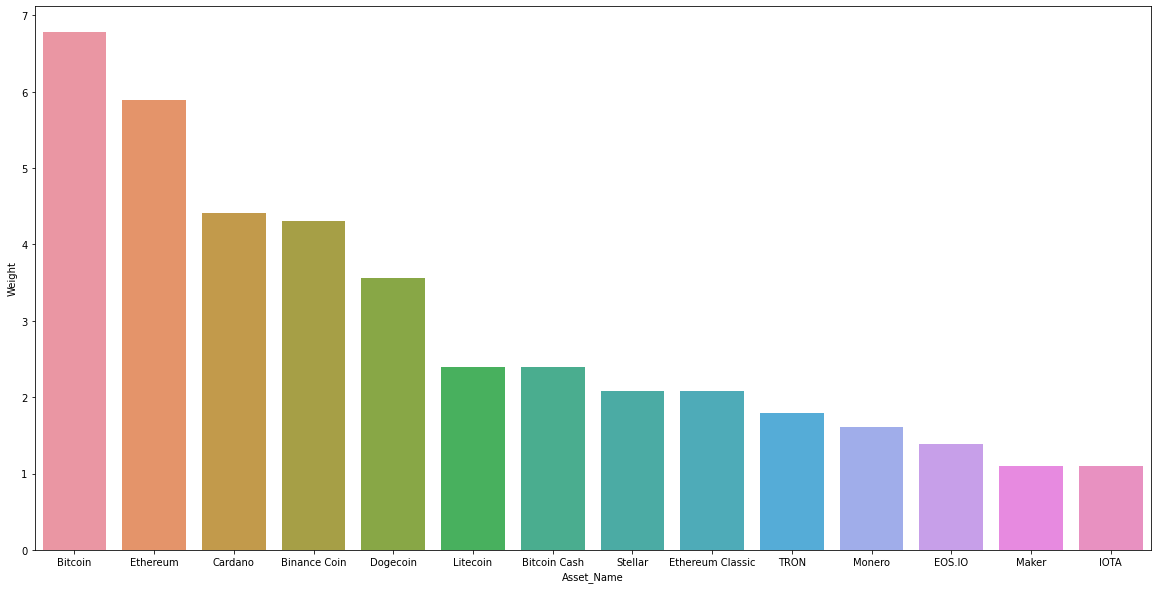

In [16]:
plt.subplots(figsize=(20,10))
sns.barplot(x='Asset_Name', y='Weight', data=asset_details)

In [ ]:
asset_details["Weight"].sum()

In [17]:
asset_det_percentage = asset_details.copy()
asset_det_percentage["weight_percentage"] = (asset_details["Weight"] / asset_details["Weight"].sum()) * 100
asset_det_percentage.sort_values("Weight", ascending=False)

Asset_ID    Weight        Asset_Name  weight_percentage
2          1  6.779922           Bitcoin          16.584998
5          6  5.894403          Ethereum          14.418848
10         3  4.406719           Cardano          10.779686
1          0  4.304065      Binance Coin          10.528574
13         4  3.555348          Dogecoin           8.697068
6          9  2.397895          Litecoin           5.865715
0          2  2.397895      Bitcoin Cash           5.865715
9         12  2.079442           Stellar           5.086716
4          7  2.079442  Ethereum Classic           5.086716
8         13  1.791759              TRON           4.382990
7         11  1.609438            Monero           3.936996
3          5  1.386294            EOS.IO           3.391144
12        10  1.098612             Maker           2.687418
11         8  1.098612              IOTA           2.687418

In [18]:
fig = px.pie(asset_det_percentage, values='weight_percentage', names='Asset_Name', title='Weights given to each cryptocurrency')
fig.show()

In [7]:
asset_names_dict = {row["Asset_Name"]:row["Asset_ID"] for ind, row in asset_details.iterrows()}

asset_names = [
    'Bitcoin',
    'Ethereum',
    'Cardano',
    'Binance Coin',
    'Dogecoin',
    'Bitcoin Cash',
    'Litecoin',
    'Ethereum Classic',
    'Stellar',
    'TRON',
    'Monero',
    'EOS.IO',
    'IOTA',
    'Maker'
]

time_list = []
for coin in asset_names:
    coin_df = train_df[train_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    start_time = coin_df.index[0].astype('datetime64[s]')
    end_time = coin_df.index[-1].astype('datetime64[s]')
    time_list.append([coin, start_time, end_time])
time_df = pd.DataFrame(time_list)
time_df.columns = ["Asset_Name", "Start_Time", "End_Time"]
time_df

Asset_Name          Start_Time   End_Time
0            Bitcoin 2018-01-01 00:01:00 2021-09-21
1           Ethereum 2018-01-01 00:01:00 2021-09-21
2            Cardano 2018-04-17 09:11:00 2021-09-21
3       Binance Coin 2018-01-01 00:01:00 2021-09-21
4           Dogecoin 2019-04-12 14:34:00 2021-09-21
5       Bitcoin Cash 2018-01-01 00:01:00 2021-09-21
6           Litecoin 2018-01-01 00:01:00 2021-09-21
7   Ethereum Classic 2018-01-01 00:01:00 2021-09-21
8            Stellar 2018-02-16 23:53:00 2021-09-21
9               TRON 2018-02-06 21:37:00 2021-09-21
10            Monero 2018-01-01 00:01:00 2021-09-21
11            EOS.IO 2018-01-01 00:01:00 2021-09-21
12              IOTA 2018-05-09 08:07:00 2021-09-21
13             Maker 2018-05-10 15:21:00 2021-09-21

In [8]:
train_df.columns

Index(['timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close',
       'Volume', 'VWAP', 'Target'],
      dtype='object')

In [9]:
missing_list = []
for coin in asset_names:
    coin_df = train_df[train_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    missing_list.append([coin, coin_df.shape[0]] + coin_df.isna().sum().tolist())
missing_df = pd.DataFrame(missing_list)
missing_df.columns = ["Asset_Name", "TotalRows", 'Missing_Asset_ID', 'Missing_Count', 'Missing_Open', 
                      'Missing_High', 'Missing_Low', 'Missing_Close', 'Missing_Volume', 'Missing_VWAP', 'Missing_Target']

In [10]:
missing_df

Asset_Name  TotalRows  Missing_Asset_ID  Missing_Count  \
0            Bitcoin    1956282                 0              0   
1           Ethereum    1956200                 0              0   
2            Cardano    1791867                 0              0   
3       Binance Coin    1942619                 0              0   
4           Dogecoin    1156866                 0              0   
5       Bitcoin Cash    1953537                 0              0   
6           Litecoin    1956030                 0              0   
7   Ethereum Classic    1951127                 0              0   
8            Stellar    1778749                 0              0   
9               TRON    1874560                 0              0   
10            Monero    1701261                 0              0   
11            EOS.IO    1955140                 0              0   
12              IOTA    1592071                 0              0   
13             Maker     670497                 0              0   

    Missing_Open  Missing_High  Missing_Low  Missing_Close  Missing_Volume  \
0              0             0            0              0               0   
1              0             0            0              0               0   
2              0             0            0              0               0   
3              0             0            0              0               0   
4              0             0            0              0               0   
5              0             0            0              0               0   
6              0             0            0              0               0   
7              0             0            0              0               0   
8              0             0            0              0               0   
9              0             0            0              0               0   
10             0             0            0              0               0   
11             0             0            0              0               0   
12             0             0            0              0               0   
13             0             0            0              0               0   

    Missing_VWAP  Missing_Target  
0              0             304  
1              0             340  
2              0           18731  
3              0           13415  
4              0          144974  
5              0            4861  
6              0             521  
7              0            9326  
8              0           61816  
9              0           21014  
10             0          239603  
11             0            2302  
12             0          193106  
13             9           40025

Мы знаем, что данные собираются каждые 60 секунд. Если у нас есть карта с интервалом более одной минуты между последовательными строками, то это означает, что данные отсутствуют между ними. Давайте проверим это для каждой из монет.

In [11]:
gap_list = []
for coin in asset_names:
    coin_df = train_df[train_df["Asset_ID"] ==
                       asset_names_dict[coin]].set_index("timestamp")
    gap_df = (coin_df.index[1:]-coin_df.index[:-1]
              ).value_counts().reset_index()
    n_gaps = gap_df[gap_df["index"] != 60]["timestamp"].sum()
    max_gap = gap_df["index"].max()
    gap_list.append([coin, n_gaps, max_gap])
gap_df = pd.DataFrame(gap_list)
gap_df.columns = ["Asset_Name", "number_of_gaps", "max_gap_in_seconds"]
gap_df

Asset_Name  number_of_gaps  max_gap_in_seconds
0            Bitcoin             145                2400
1           Ethereum             156                7200
2            Cardano            9360                4800
3       Binance Coin            6600              120720
4           Dogecoin           76652                7260
5       Bitcoin Cash            2502                4380
6           Litecoin             291                5280
7   Ethereum Classic            4707                3780
8            Stellar           37770                8520
9               TRON           12225                3000
10            Monero          131837                3180
11            EOS.IO            1188                3960
12              IOTA          107741               10920
13             Maker           26497              281700

Вывод:

В наборе данных есть несколько пробелов, и нам нужно внимательно отнестись к ним
Максимальный пробел в Maker coin составляет 281 700 секунд, или около 78 часов
Когда у нас есть пробелы в данных, мы не можем рассчитать доходность за период времени, который наступает сразу после этих пробелов. Я думаю, что именно по этой причине в наших данных отсутствуют целевые значения.

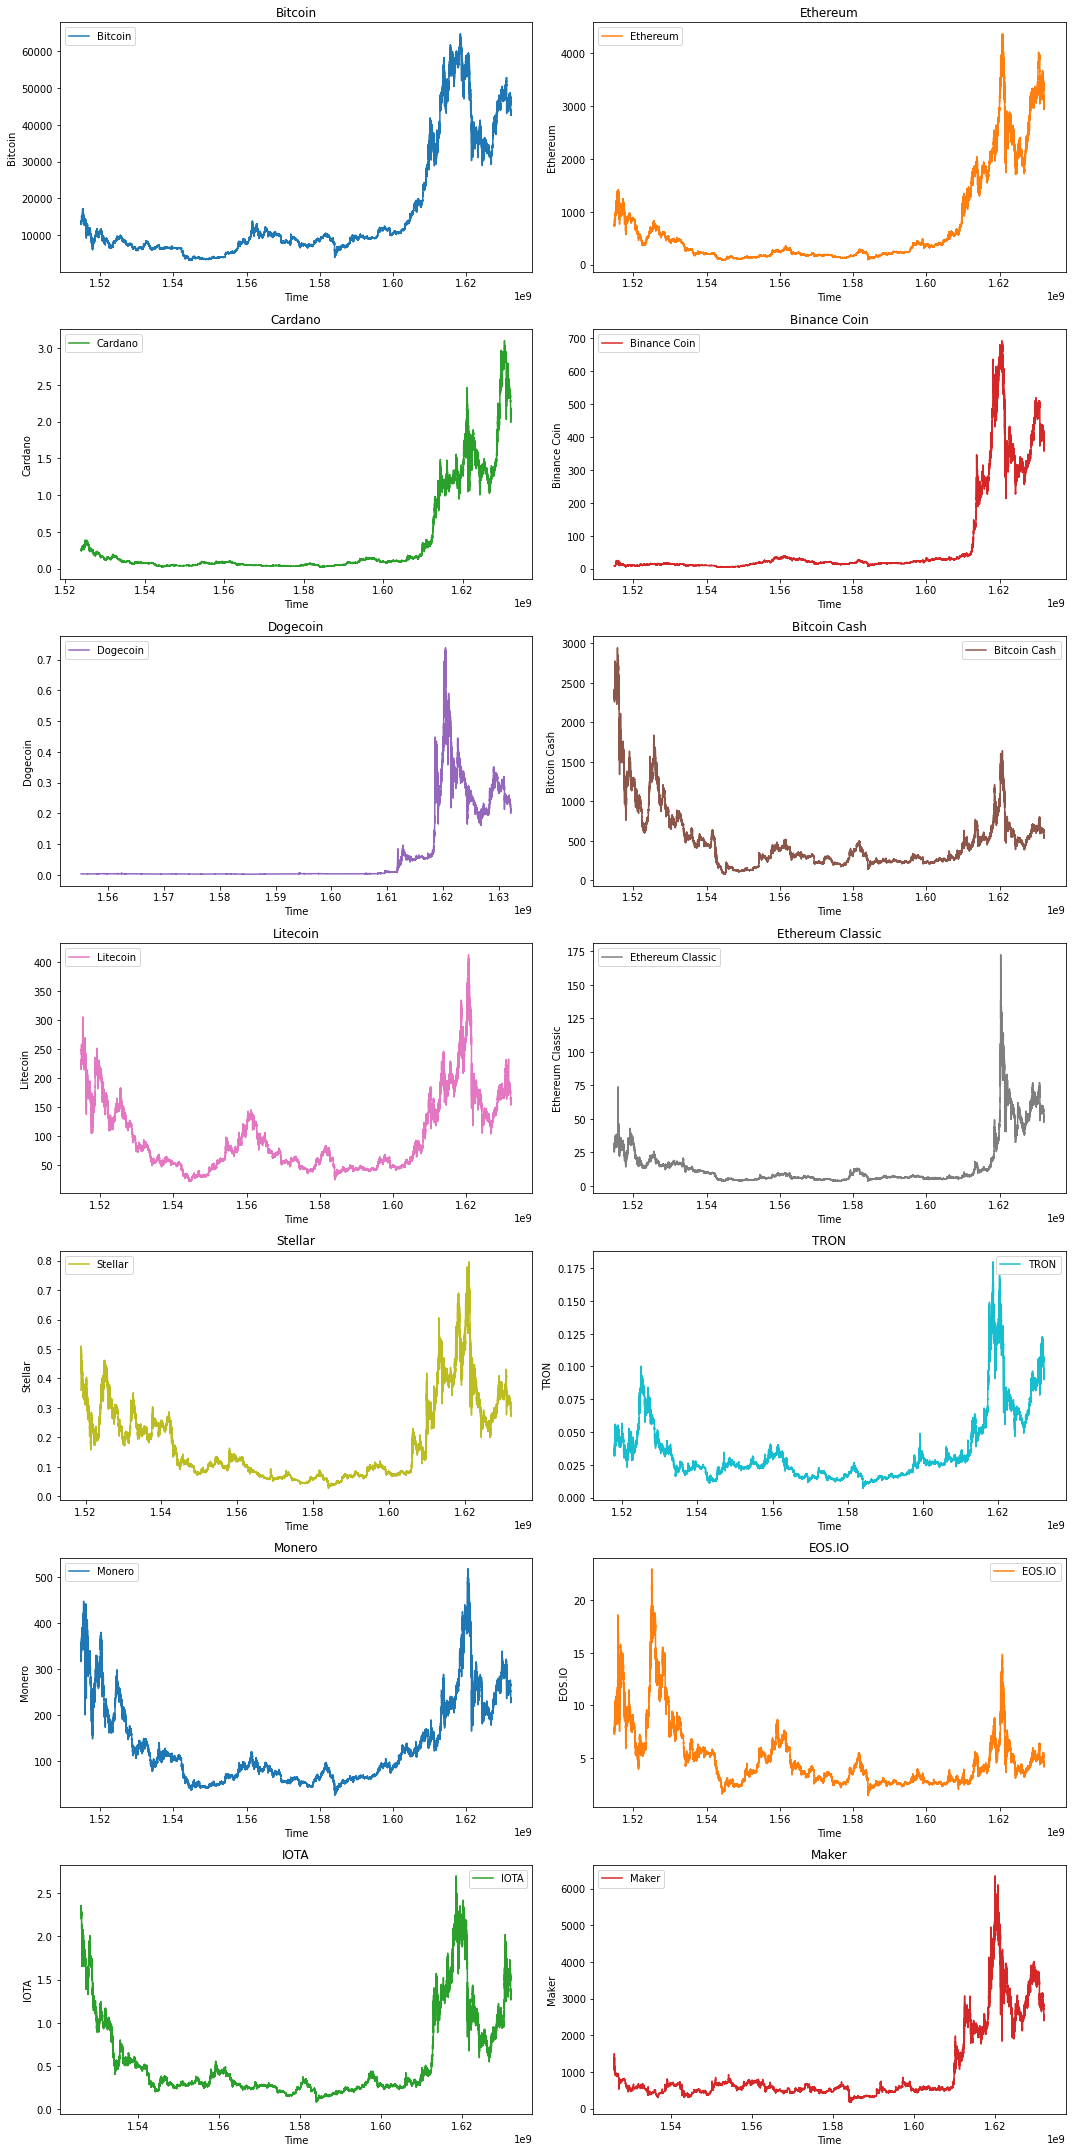

In [19]:
import matplotlib.colors as mcolors
# cmap = mcolors.ListedColormap(["w", "grey", "green", "red"])

cmap = plt.cm.get_cmap('tab10')
f = plt.figure(figsize=(15, 30))

for ind, coin in enumerate(asset_names):
    coin_df = train_df[train_df["Asset_ID"] ==
                       asset_names_dict[coin]].set_index("timestamp")
    # fill missing values
    coin_df = coin_df.reindex(
        range(coin_df.index[0], coin_df.index[-1]+60, 60), method='pad')
    ax = f.add_subplot(7, 2, ind+1)
    plt.plot(coin_df['Close'], label=coin, color=cmap.colors[ind % 10])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(coin)
    plt.title(coin)

plt.tight_layout()
plt.show()

Вывод:

По-видимому, существует хорошая корреляция между различными криптоактивами, а также, по-видимому, они различаются на разных временных шкалах.
У нас есть данные о медвежьих показателях за 2018 год, массовые данные за 2021 год, побочные данные за 2019 и 2020 годы. Таким образом, этот набор данных отражает различные типы рынков, которые мы можем смоделировать.

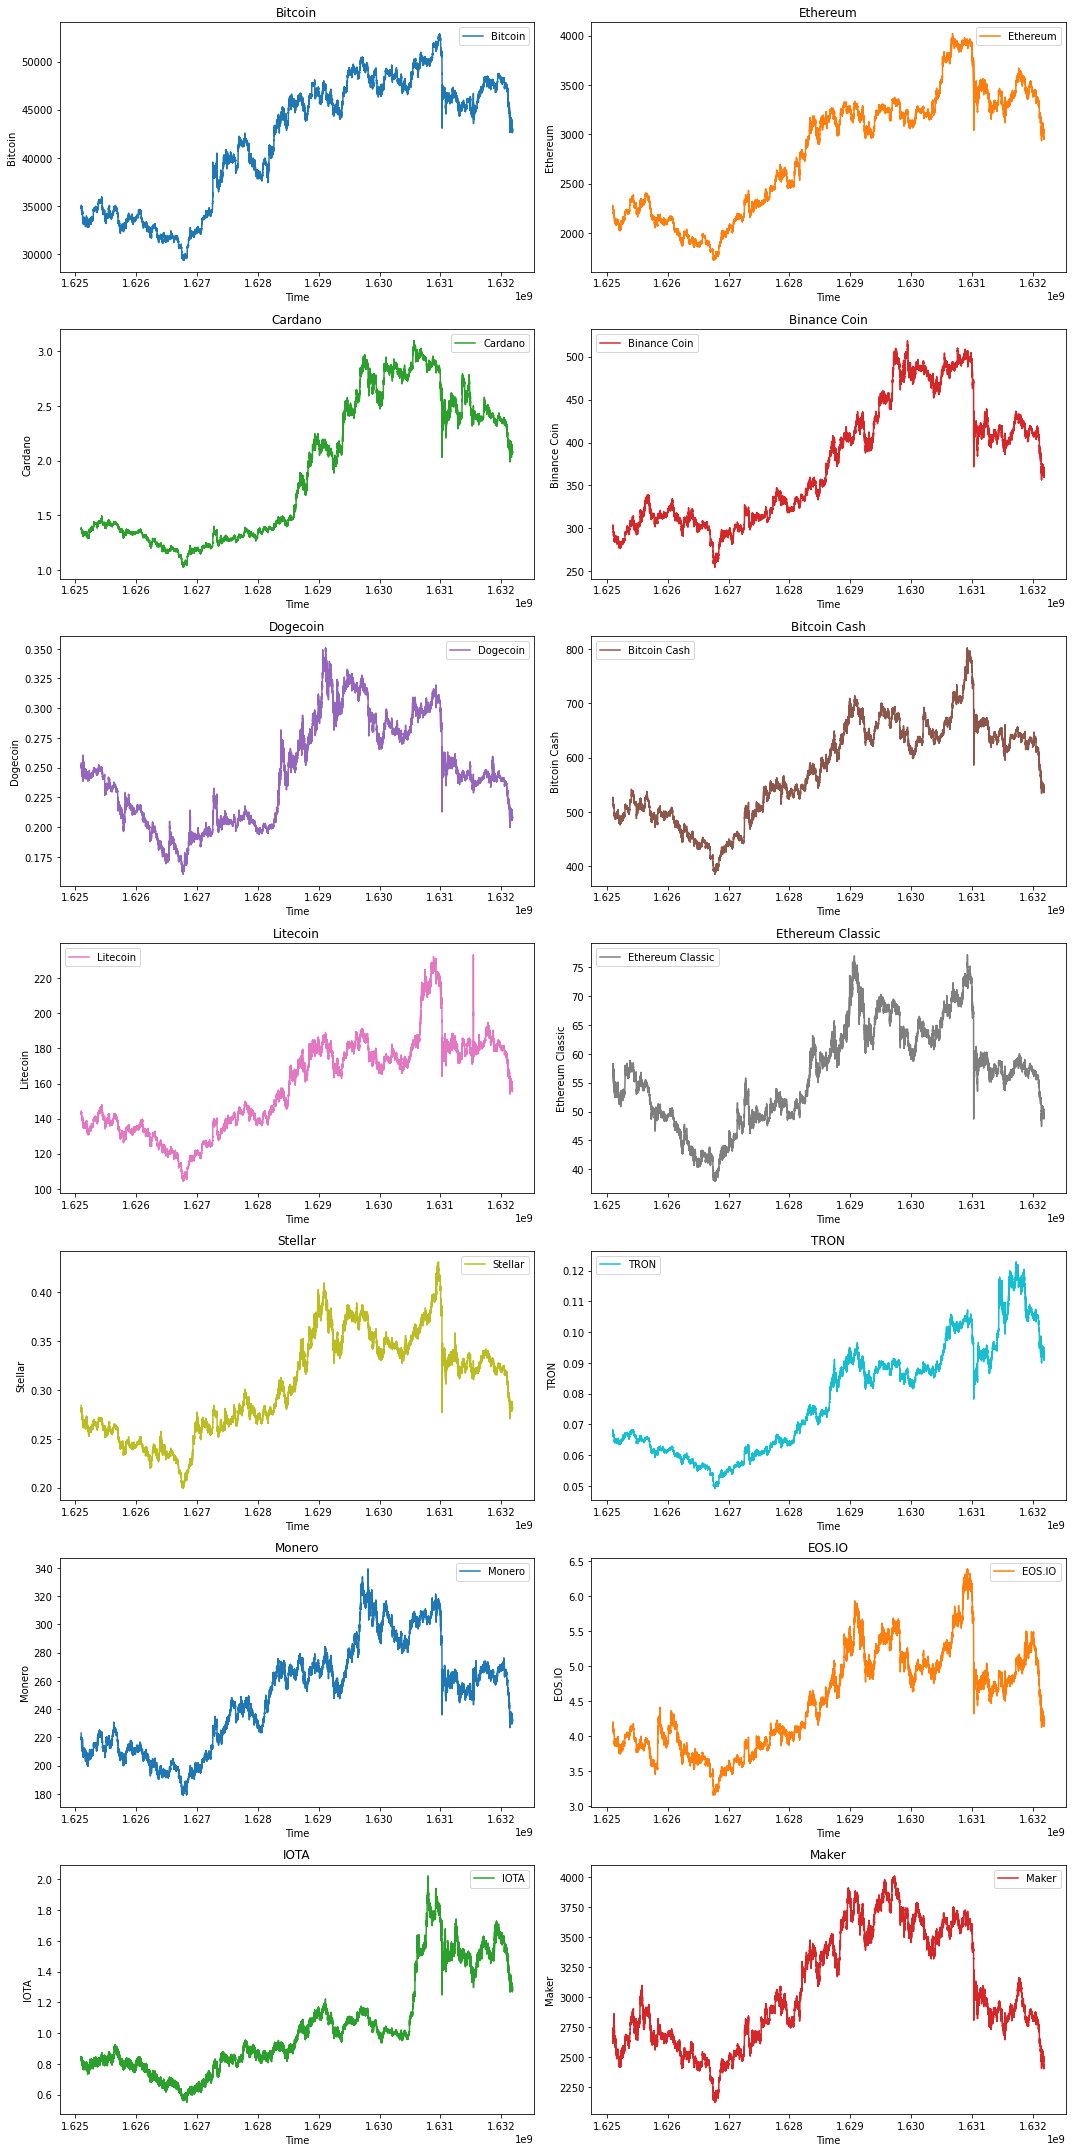

In [20]:
# create intervals
f = plt.figure(figsize=(15,30))

for ind, coin in enumerate(asset_names):
    coin_df = train_df[train_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    # fill missing values 
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    coin_df = coin_df.loc[totimestamp('01/07/2021'):totimestamp('21/09/2021')]
    ax = f.add_subplot(7,2,ind+1)
    plt.plot(coin_df['Close'], label=coin, color=cmap.colors[ind%10])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(coin)
    plt.title(coin)

plt.tight_layout()
plt.show()

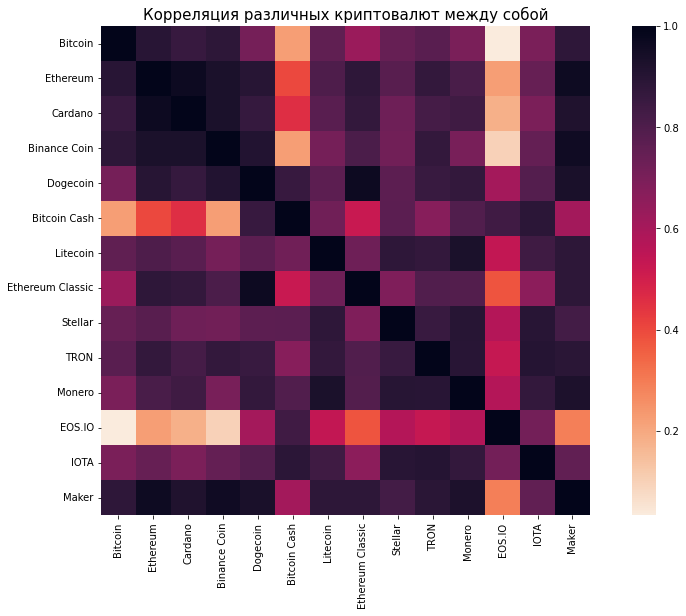

In [9]:
all_assets_df = pd.DataFrame([])
for ind, coin in enumerate(asset_names):
    coin_df = train_df[train_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    # fill missing values
    coin_df = coin_df#.loc[totimestamp('01/07/2021'):totimestamp('21/09/2021')]
    close_values = coin_df["Close"].fillna(0)
    close_values.name = coin
    all_assets_df = all_assets_df.join(close_values, how="outer")

corrmat = all_assets_df.corr()
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corrmat, vmax=1., square=True, cmap="rocket_r")
plt.title("Корреляция различных криптовалют между собой", fontsize=15)
plt.show()

Вывод:

Мы могли четко видеть высокую корреляцию между различными активами
Самая низкая корреляция находится в диапазоне 0,4x
Существует высокая корреляция между
Bitcoin и Ethereum
Cardano и Binance coin
Bitcoin Cash и Litecoin


Корреляция на основе логарифмических данных
Но мы получили корреляцию на основе фактических значений. Разные монеты находятся в разных ценовых диапазонах. Поэтому давайте воспользуемся логарифмическими данными, как предложено в учебном пособии, и проверим корреляцию за последний период времени.

Из учебного пособия,

Логарифмические данные

Чтобы проанализировать изменения цен на актив, мы можем учитывать разницу в цене. Однако разные активы имеют разный масштаб цен, поэтому их доходность не всегда сопоставима. Мы можем решить эту проблему, рассчитав процентное изменение цены, также известное как доходность. Эта доходность совпадает с процентным изменением нашего инвестированного капитала.

Доходность широко используется в финансах, однако логарифмическая доходность предпочтительнее для математического моделирования временных рядов, поскольку она аддитивна во времени. Кроме того, хотя обычная доходность не может быть ниже -100%, логарифмическая доходность не ограничена.

Чтобы вычислить логарифмический результат, мы можем просто взять логарифм отношения между двумя последовательными ценами. Первая строка будет содержать пустой результат, поскольку предыдущее значение неизвестно, поэтому пустая точка данных для возврата будет удалена.

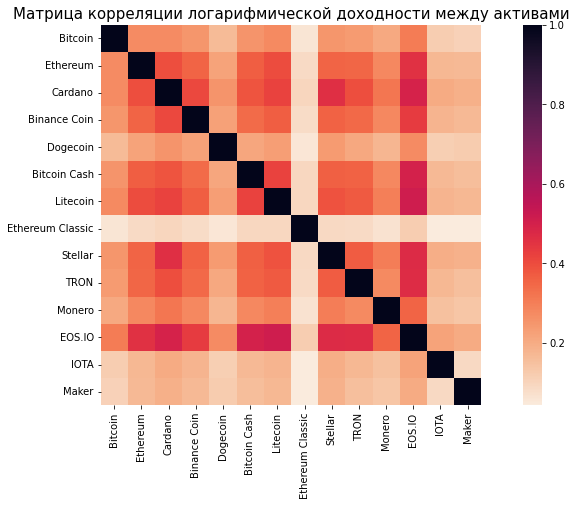

In [12]:

all_assets_df = pd.DataFrame([])
for ind, coin in enumerate(asset_names):
    coin_df = train_df[train_df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    # fill missing values
    coin_df = coin_df.loc[totimestamp('01/07/2019'):totimestamp('21/09/2021')]
    return_values = log_return(coin_df["Close"].fillna(0))[1:]
    return_values.name = coin
    all_assets_df = all_assets_df.join(return_values, how="outer")

corrmat = all_assets_df.corr()
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(corrmat, vmax=1., square=True, cmap="rocket_r")
plt.title("Матрица корреляции логарифмической доходности между активами", fontsize=15)
plt.show()


Вывод:

В последние месяцы, когда мы смотрим на доходность журналов, у IOTA очень низкая корреляция с другими монетами
Биткоин и Эфириум по-прежнему демонстрируют высокую корреляцию.
Похоже, что корреляция между активами меняется с течением времени, и поэтому это необходимо учитывать при построении моделей

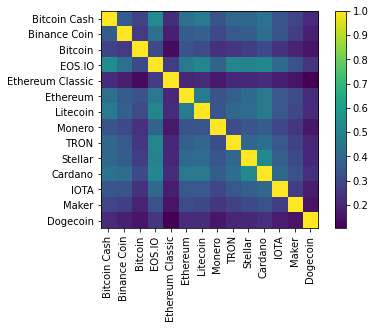

In [31]:
all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
  asset = train_df[train_df["Asset_ID"] == asset_id].set_index("timestamp")
  asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/05/2021')]
  asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
  lret = log_return(asset.Close.fillna(0))[1:]
  all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")

plt.imshow(all_assets_2021.corr());
plt.yticks(range(14), asset_details.Asset_Name.values);
plt.xticks(range(14), asset_details.Asset_Name.values, rotation='vertical');
plt.colorbar();

#### Далее основной датасет

In [25]:
train_df.isna().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [26]:
train_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   timestamp  24236806 non-null  int32  
 1   Asset_ID   24236806 non-null  int8   
 2   Count      24236806 non-null  float32
 3   Open       24236806 non-null  float16
 4   High       24236806 non-null  float16
 5   Low        24236806 non-null  float16
 6   Close      24236806 non-null  float16
 7   Volume     24236806 non-null  float32
 8   VWAP       24236797 non-null  float64
 9   Target     23486468 non-null  float16
dtypes: float16(5), float32(2), float64(1), int32(1), int8(1)
memory usage: 716.5 MB


In [32]:
temp = train_df.reset_index(drop = True) 
temp['TIME'] = pd.to_datetime(temp['timestamp'], unit='s')

In [33]:
temp['Year'] = temp['TIME'].dt.year
temp.columns = [column.replace(" ", "_") for column in temp.columns]
temp.dropna()[['Open', 'High', 'Low', 'Close', 'Volume','VWAP']]
volume_yr = temp.groupby(['Year','Asset_name'])['Volume'].max().reset_index()
volume_yr = volume_yr.query("Year == 2021")

KeyError: 'Asset_name'

NameError: name 'volume_yr' is not defined

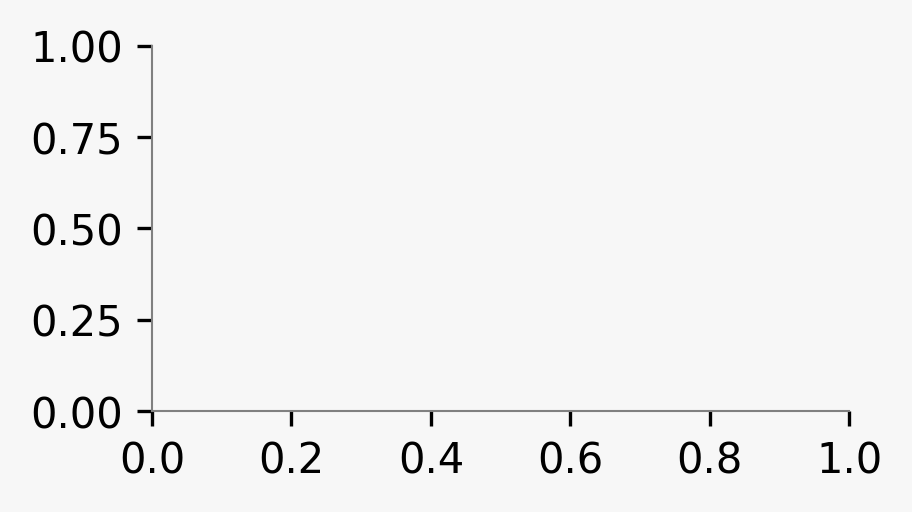

In [34]:
# plt.rcParams['figure.dpi'] = 300
# fig = plt.figure(figsize=(3, 5), facecolor='#F7F7F7')
# gs = fig.add_gridspec(2, 1)
# gs.update(wspace=1.5, hspace=1.1)

# background_color = "#F7F7F7"
# color_map = ["#E8F0F2" for _ in range(20)]
# color_map[4] = "#C9CCD5" #F2A154 79B4B7
# color_map[1] = "#F2A154"
# color_map[6] = "#F2A154"
# sns.set_palette(sns.color_palette(color_map))

# ax0 = fig.add_subplot(gs[0, 0])
# ax0.set_facecolor(background_color)

# for s in ["right", "top"]:
#     ax0.spines[s].set_visible(False)

# for s in ['bottom','left']:
#   ax0.spines[s].set_linewidth(0.5)
#   ax0.spines[s].set_color('grey')
    
# #graph
# ax0 = sns.barplot(ax=ax0, y=volume_yr['Volume']/1000, x=volume_yr['Asset_name'], 
#                       zorder=2, linewidth=0.3, edgecolor="#7F7C82", 
#                       orient='v', saturation=0.9, alpha=0.7)
# ax0.grid(which='major', axis='y', zorder=0, color='#CDD0CB', linewidth=0.2, alpha=0.5)
# ax0.set_yscale('symlog')

# #format axis
# ax0.set_ylabel("Volume",fontsize=3, weight='semibold')
# ax0.set_xlabel("Crypto Currency",fontsize=3, weight='semibold')
# ax0.tick_params(labelsize=3, width=0.2, length=1)
# plt.setp( ax0.xaxis.get_majorticklabels(), rotation=45, ha="right" )

# #title
# x0, x1 = ax0.get_xlim()
# y0, y1 = ax0.get_ylim()
# ax0.text(x0, y1+2000000, 'Volume by Year', fontsize=4, ha='left', va='top', weight='semibold')

# y_format = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
# ax0.yaxis.set_major_formatter(y_format)

# plt.show()

Для технического анализа будем использовать скользящую среднюю(SMA) и индекс относительной силы(RSI).

In [36]:
# import plotly.graph_objects as go
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode()

# for currency_id in asset_details.Asset_ID:
#     currency_value = train_df[train_df["Asset_ID"] == currency_id].iloc[-365:].set_index("timestamp")
#     fig = go.Figure(data=go.Candlestick(x=currency_value.index, open=currency_value['Open'], high=currency_value['High'], low=currency_value['Low'], close=currency_value['Close']))
#     name = asset_details[asset_details.Asset_ID == currency_id]['Asset_Name']
#     fig.update_layout(title=f"{name}")
#     fig.show()

TypeError: unsupported datatype in numpy array

In [37]:
print("Total Null Target Rows = " ,train_df["Target"].isnull().sum())
print("Percentage of NUll rows in Training Data = {:.2f}%".format(train_df["Target"].isnull().sum()*100 / train_df.shape[0] ))

Total Null Target Rows =  750338
Percentage of NUll rows in Training Data = 3.10%


Иногда отсутсвие данных выражается не ввиде NaN, а в виде отсутсвия этих строк.

Не так уж много данных пропущено. Мы можем удалить эти строки, вычислить значения и т.д.

Более скрытая потеря данных - это когда у нас вообще нет никакой информации за определенную минуту. Это означает, что в нашем наборе данных могут отсутствовать целые строки.

У нас должна быть одна строка в минуту для каждого актива. Поскольку мы извлекли данные для одного актива, мы ожидаем, что в последовательных строках разница между значениями индекса составит 60 секунд.

Первый шаг - посмотреть на временную задержку между последовательными записями в нашем наборе данных.

In [38]:
for currency_id in asset_details.Asset_ID:
    currency_value = train_df[train_df["Asset_ID"] == currency_id]
    print(asset_details[asset_details['Asset_ID'] == currency_id]['Asset_Name'], (currency_value.index[1:] - currency_value.index[:-1]).value_counts().head())

0    Bitcoin Cash
Name: Asset_Name, dtype: object 14    596531
12    493328
13    443577
11    211790
8      78561
dtype: int64
1    Binance Coin
Name: Asset_Name, dtype: object 14    596458
12    490884
13    442942
11    207287
8      77327
dtype: int64
2    Bitcoin
Name: Asset_Name, dtype: object 14    596514
12    495202
13    443611
11    214273
8      78696
dtype: int64
3    EOS.IO
Name: Asset_Name, dtype: object 14    596453
12    496216
13    443265
11    213996
8      77880
dtype: int64
4    Ethereum Classic
Name: Asset_Name, dtype: object 14    596133
12    494421
13    442192
11    212210
8      77610
dtype: int64
5    Ethereum
Name: Asset_Name, dtype: object 14    596323
12    496301
13    443256
11    213929
8      78792
dtype: int64
6    Litecoin
Name: Asset_Name, dtype: object 14    596262
12    496675
13    443059
11    214006
8      78740
dtype: int64
7    Monero
Name: Asset_Name, dtype: object 14    592232
13    412362
12    393022
8      55912
11     51740
dtype: int

Поскольку пробелы в данных очень малы, мы можем использовать простой метод вычисления: заполнить недостающие данные значением за последнюю доступную минуту.

Именно это делает параметр method = 'pad' функции напоминания, приведенной ниже.

In [39]:
currency_values = {}
for currency_id in asset_details.Asset_ID:
    
    currency_value = train_df[train_df["Asset_ID"] == currency_id]
    currency_value = currency_value.reindex(range(currency_value.index[0], currency_value.index[-1] + 60, 60), method='pad')
    name = asset_details[asset_details.Asset_ID == currency_id]['Asset_Name'].values[0]
    currency_values[str(name)] = currency_value
    
    print(name, (currency_value.index[1:] - currency_value.index[:-1]).value_counts().head())

Bitcoin Cash 60    403947
dtype: int64
Binance Coin 60    403947
dtype: int64
Bitcoin 60    403947
dtype: int64
EOS.IO 60    403947
dtype: int64
Ethereum Classic 60    403947
dtype: int64
Ethereum 60    403947
dtype: int64
Litecoin 60    403947
dtype: int64
Monero 60    403947
dtype: int64
TRON 60    396970
dtype: int64
Stellar 60    394961
dtype: int64
Cardano 60    382369
dtype: int64
IOTA 60    377039
dtype: int64
Maker 60    376699
dtype: int64
Dogecoin 60    282795
dtype: int64


Все, в нашем датасете нет временных пробелов

### Data Visualisation

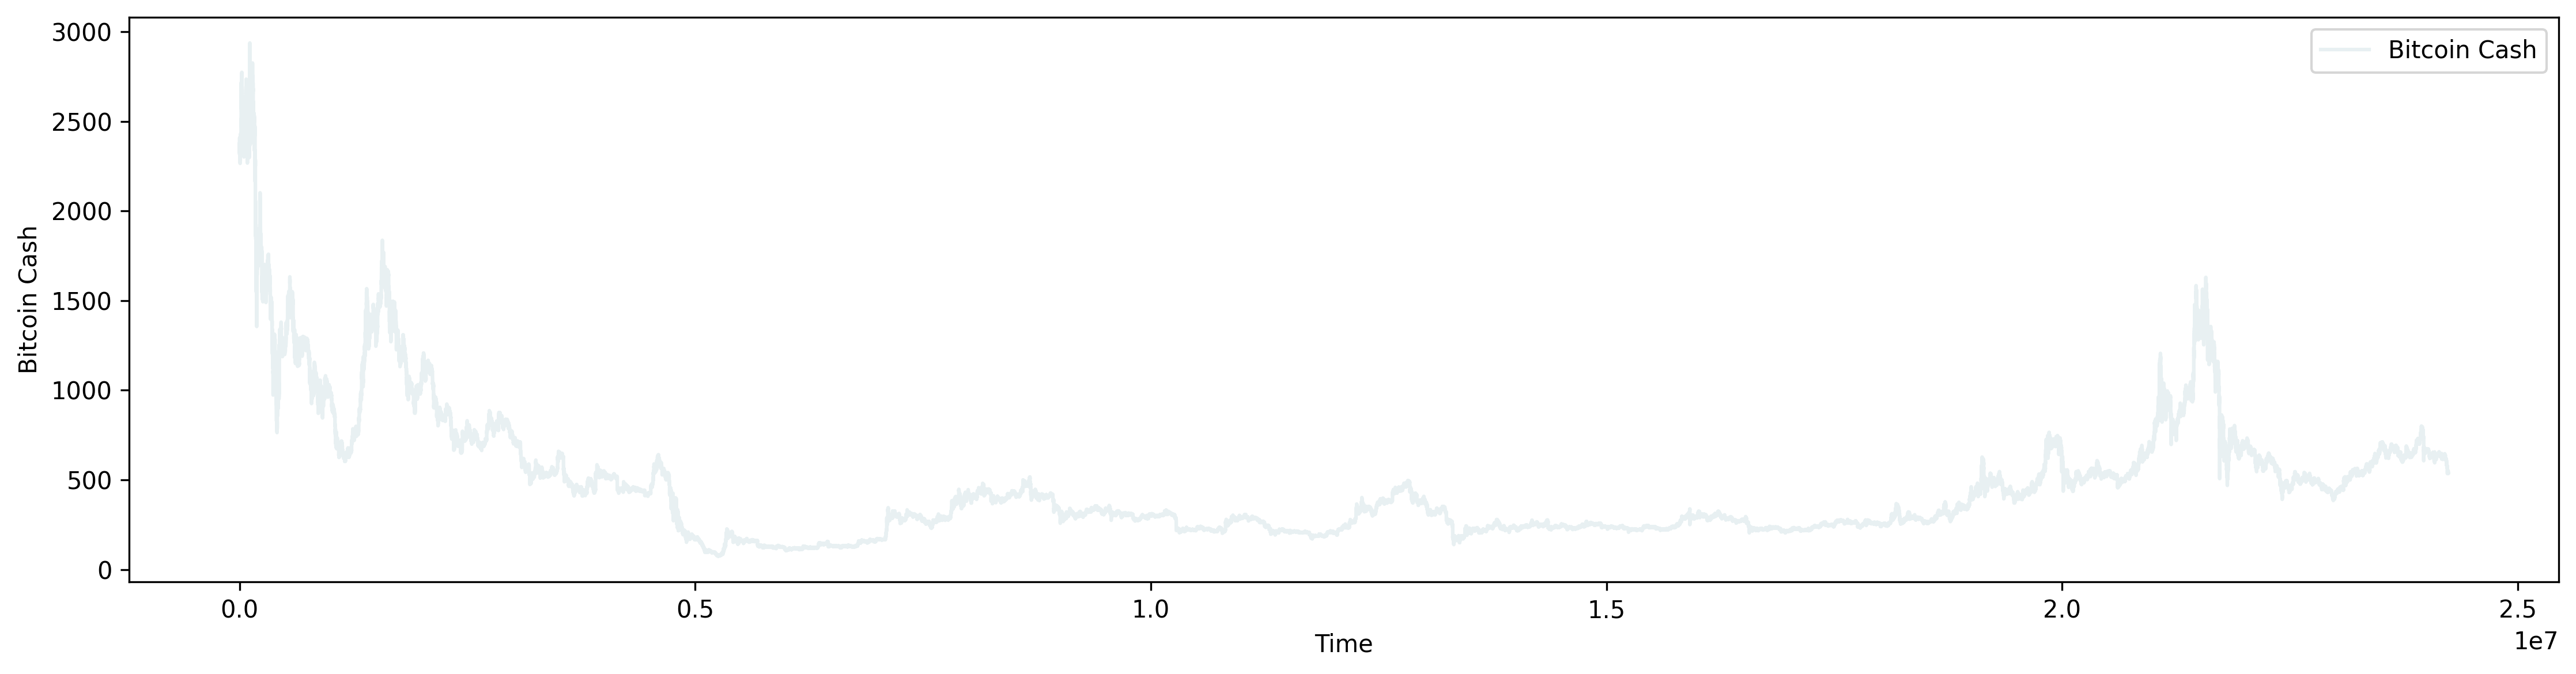

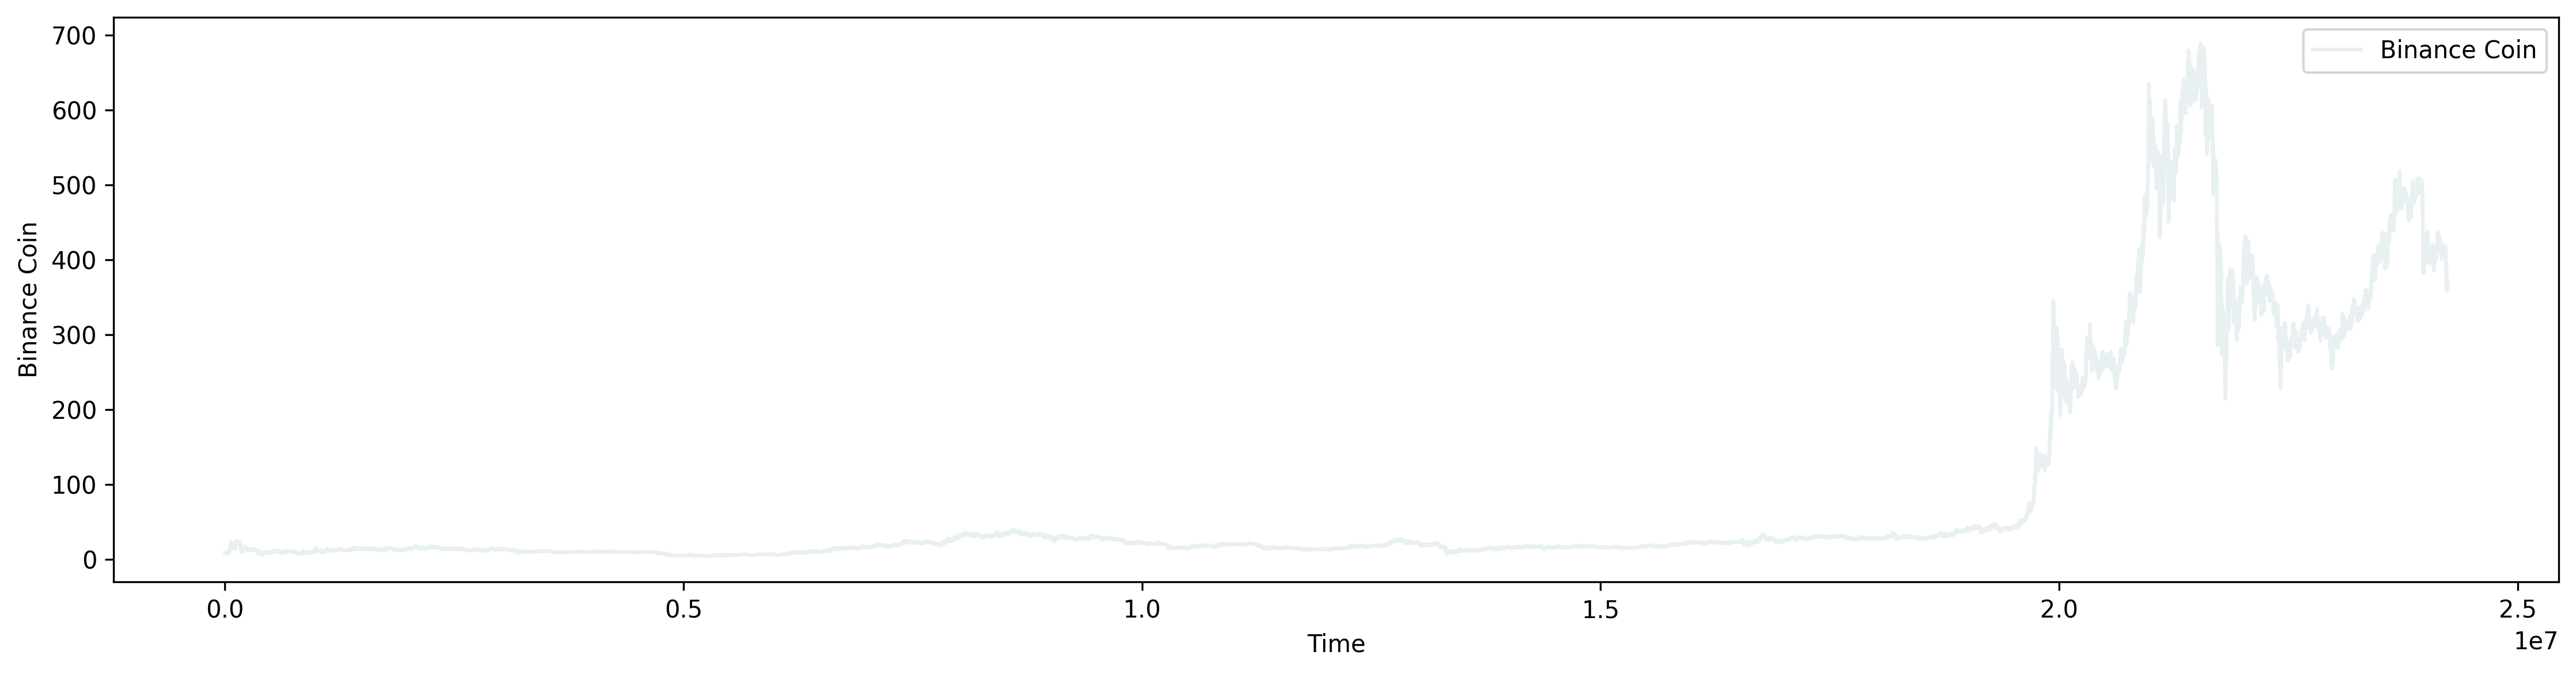

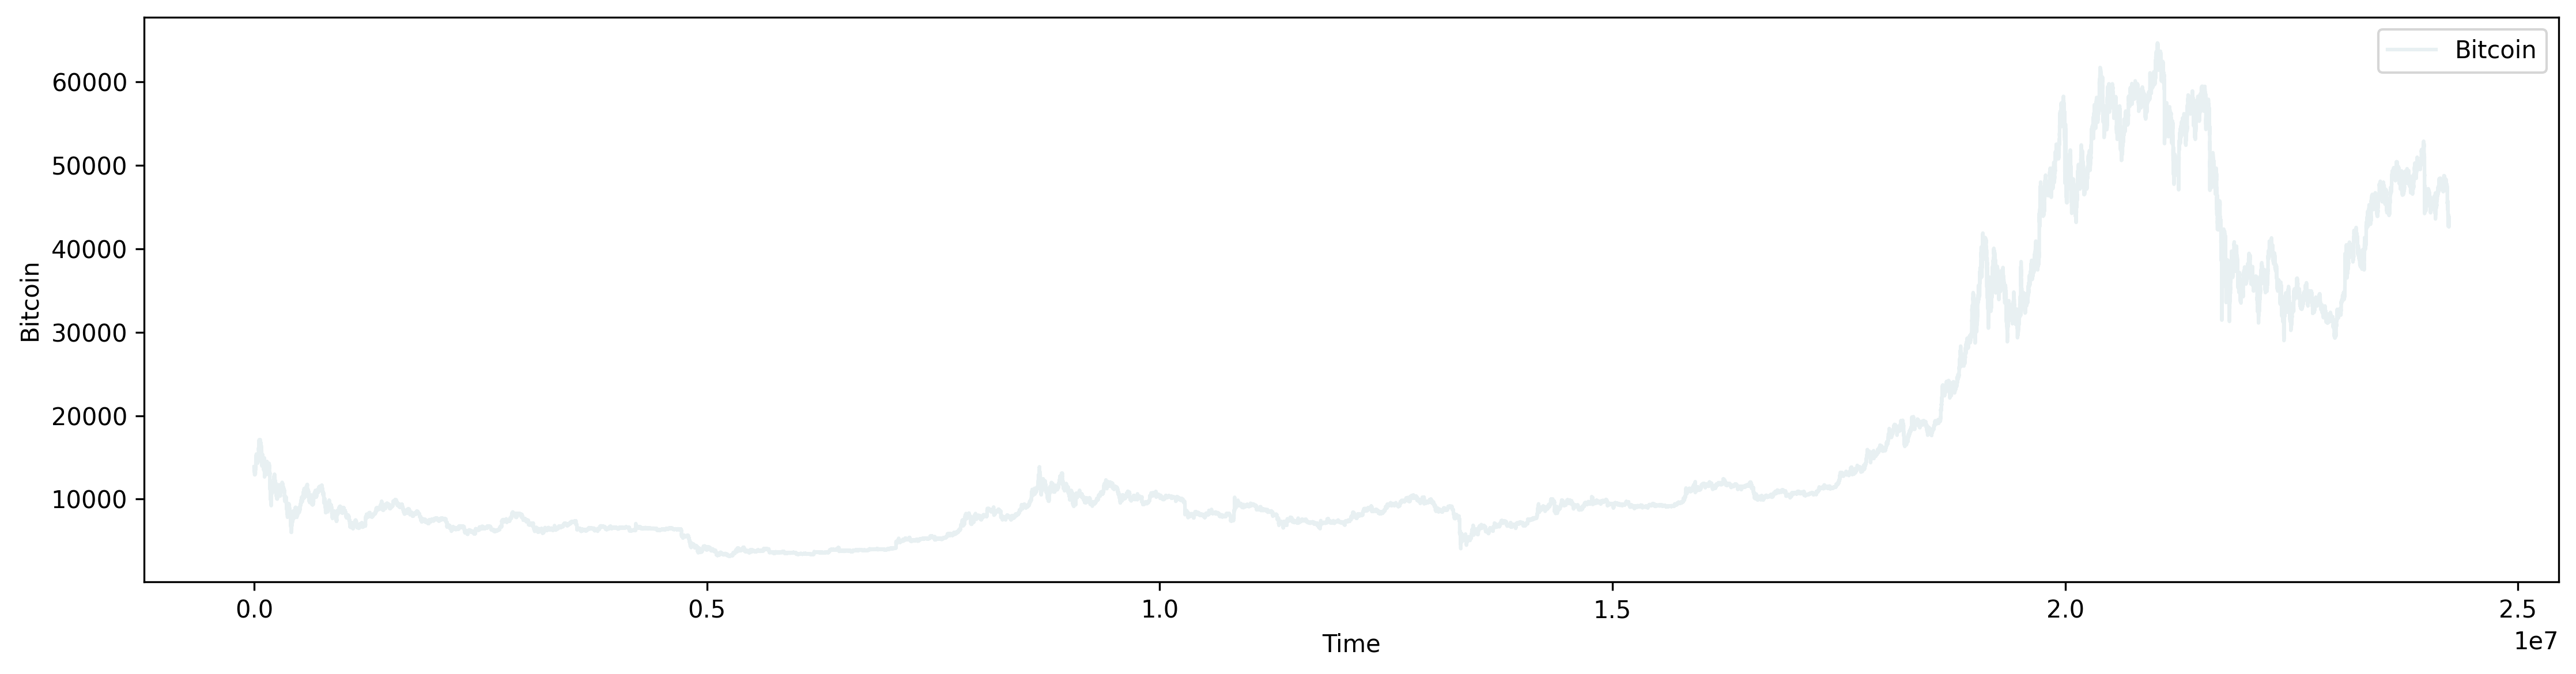

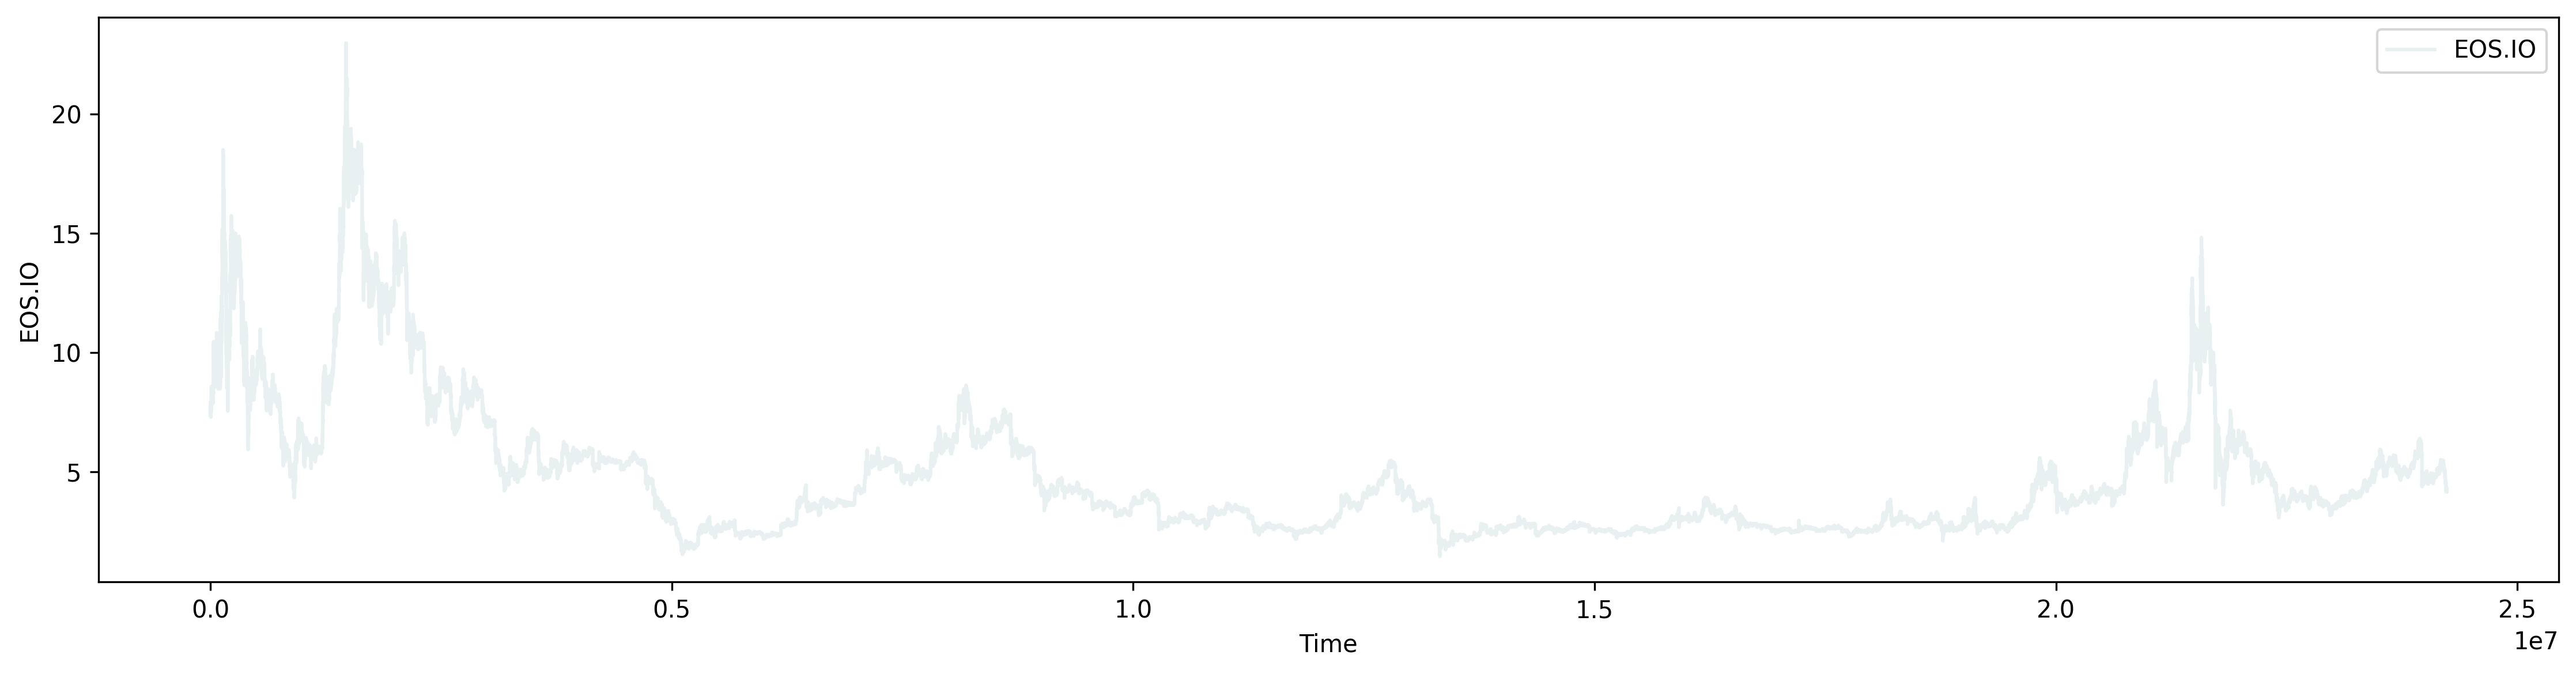

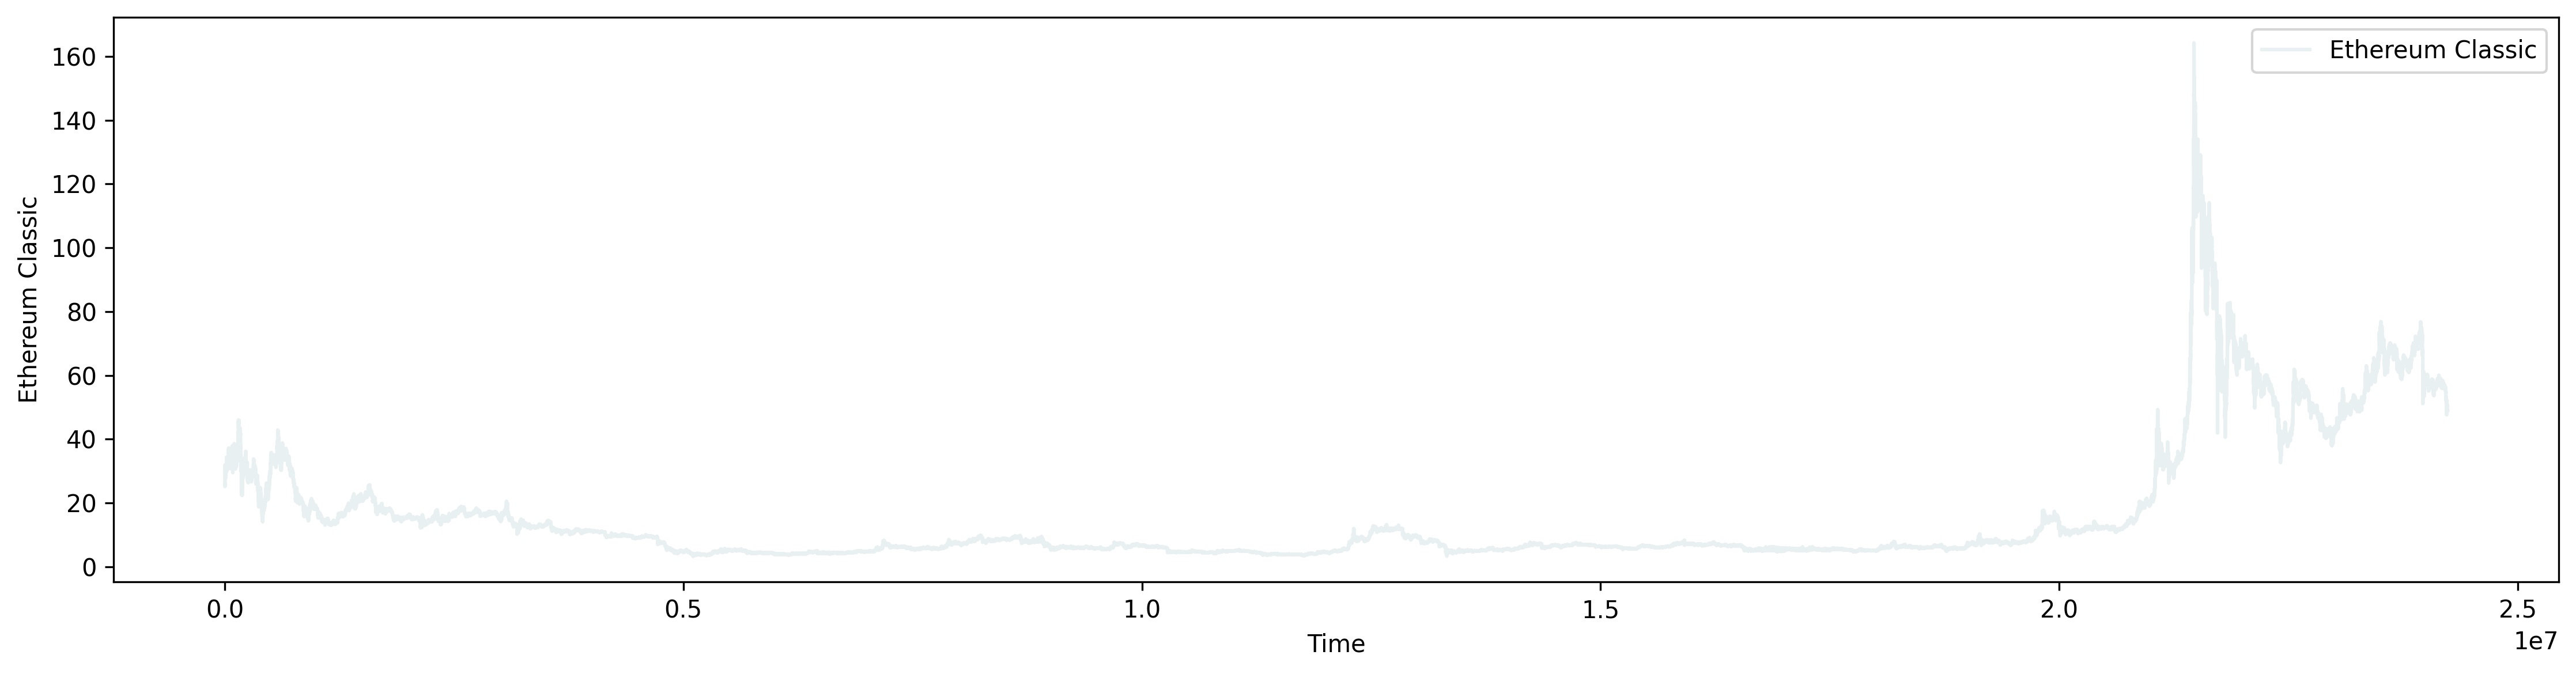

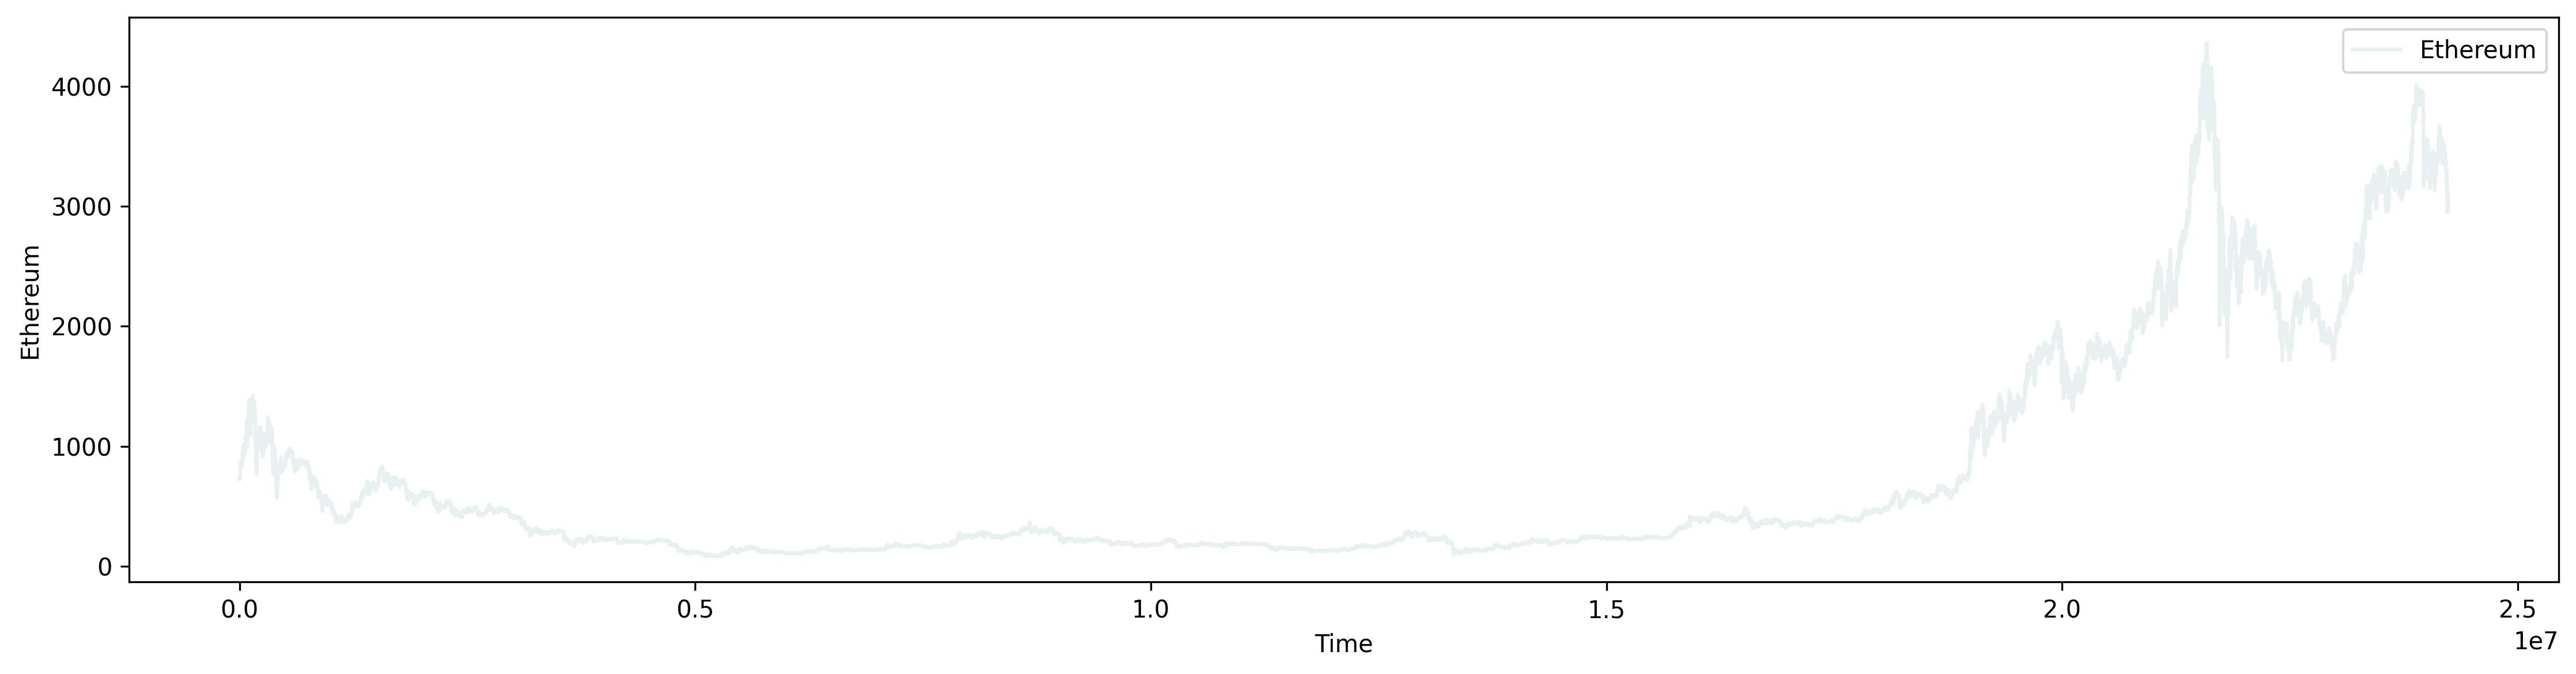

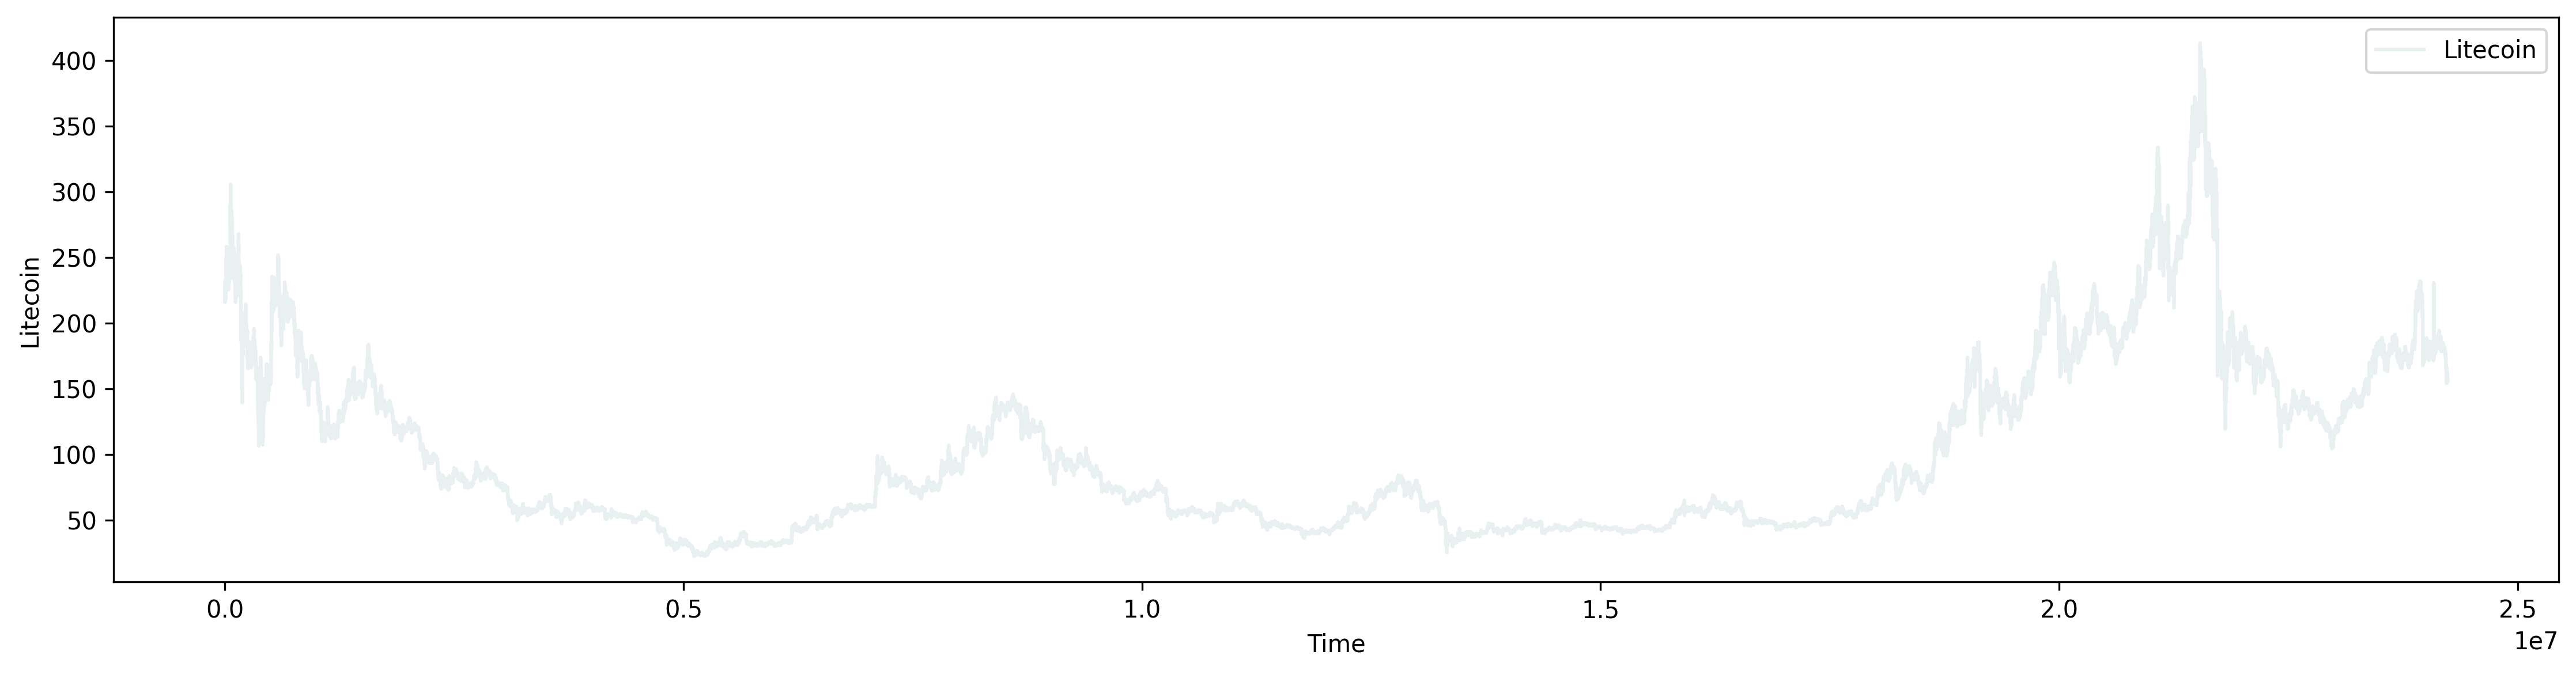

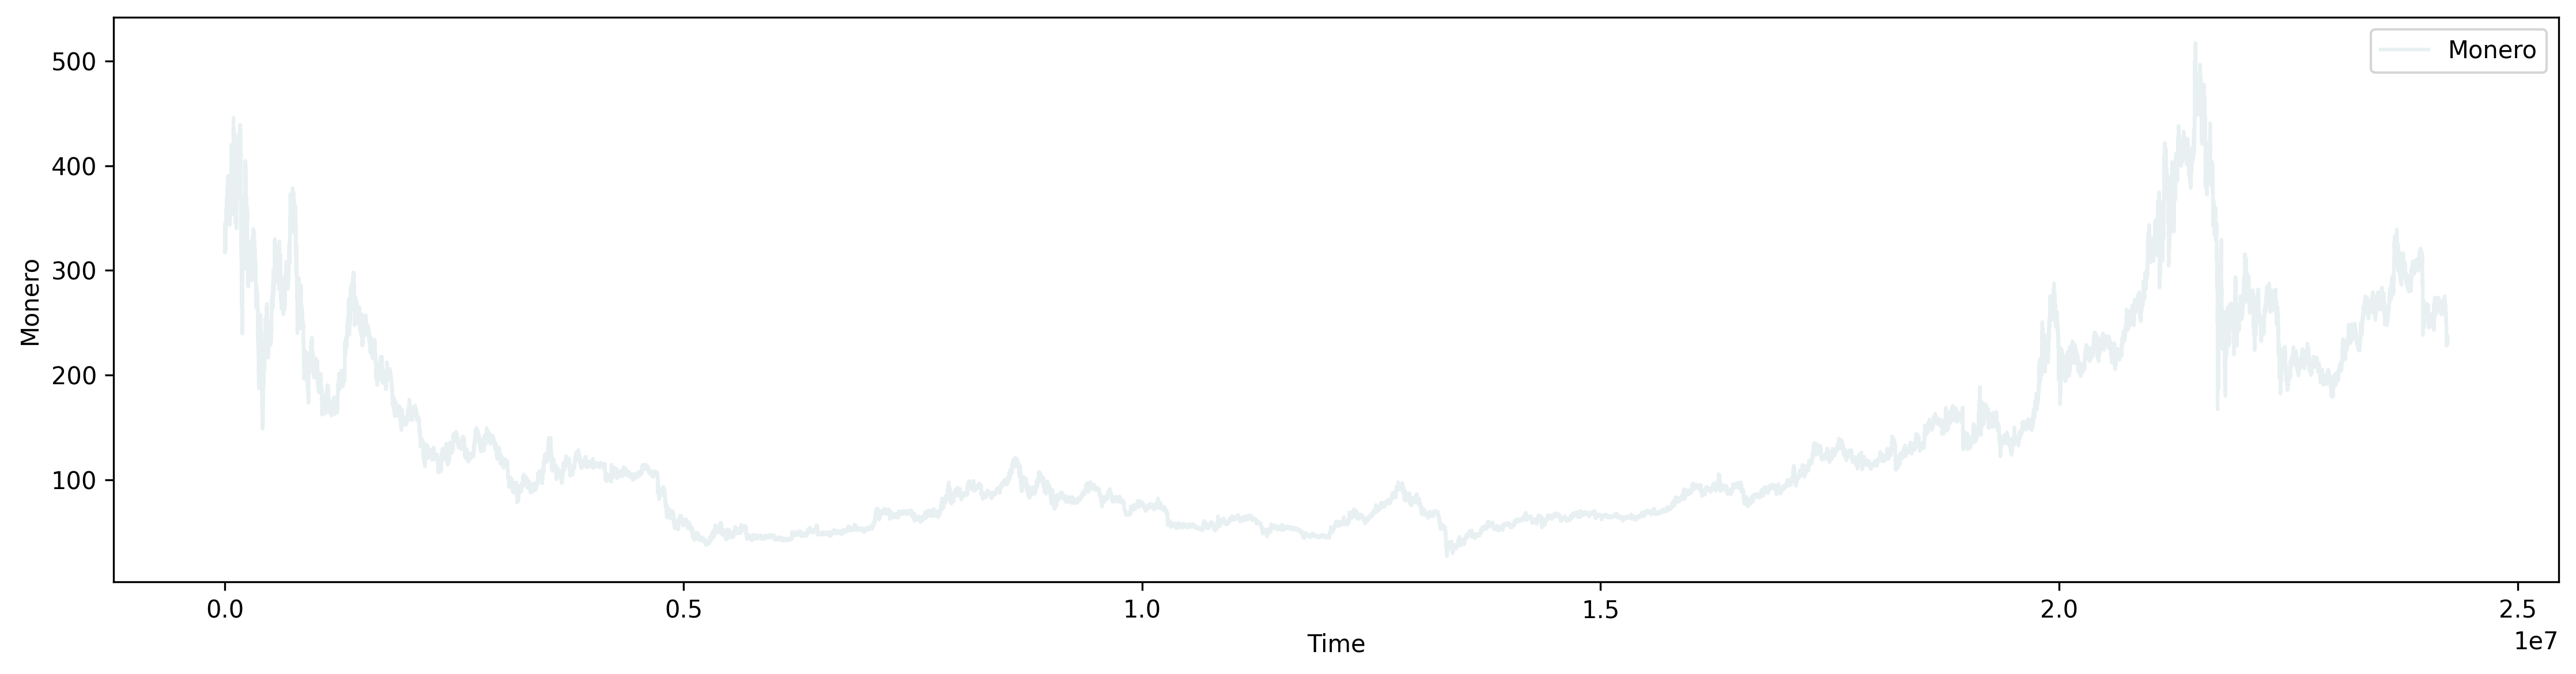

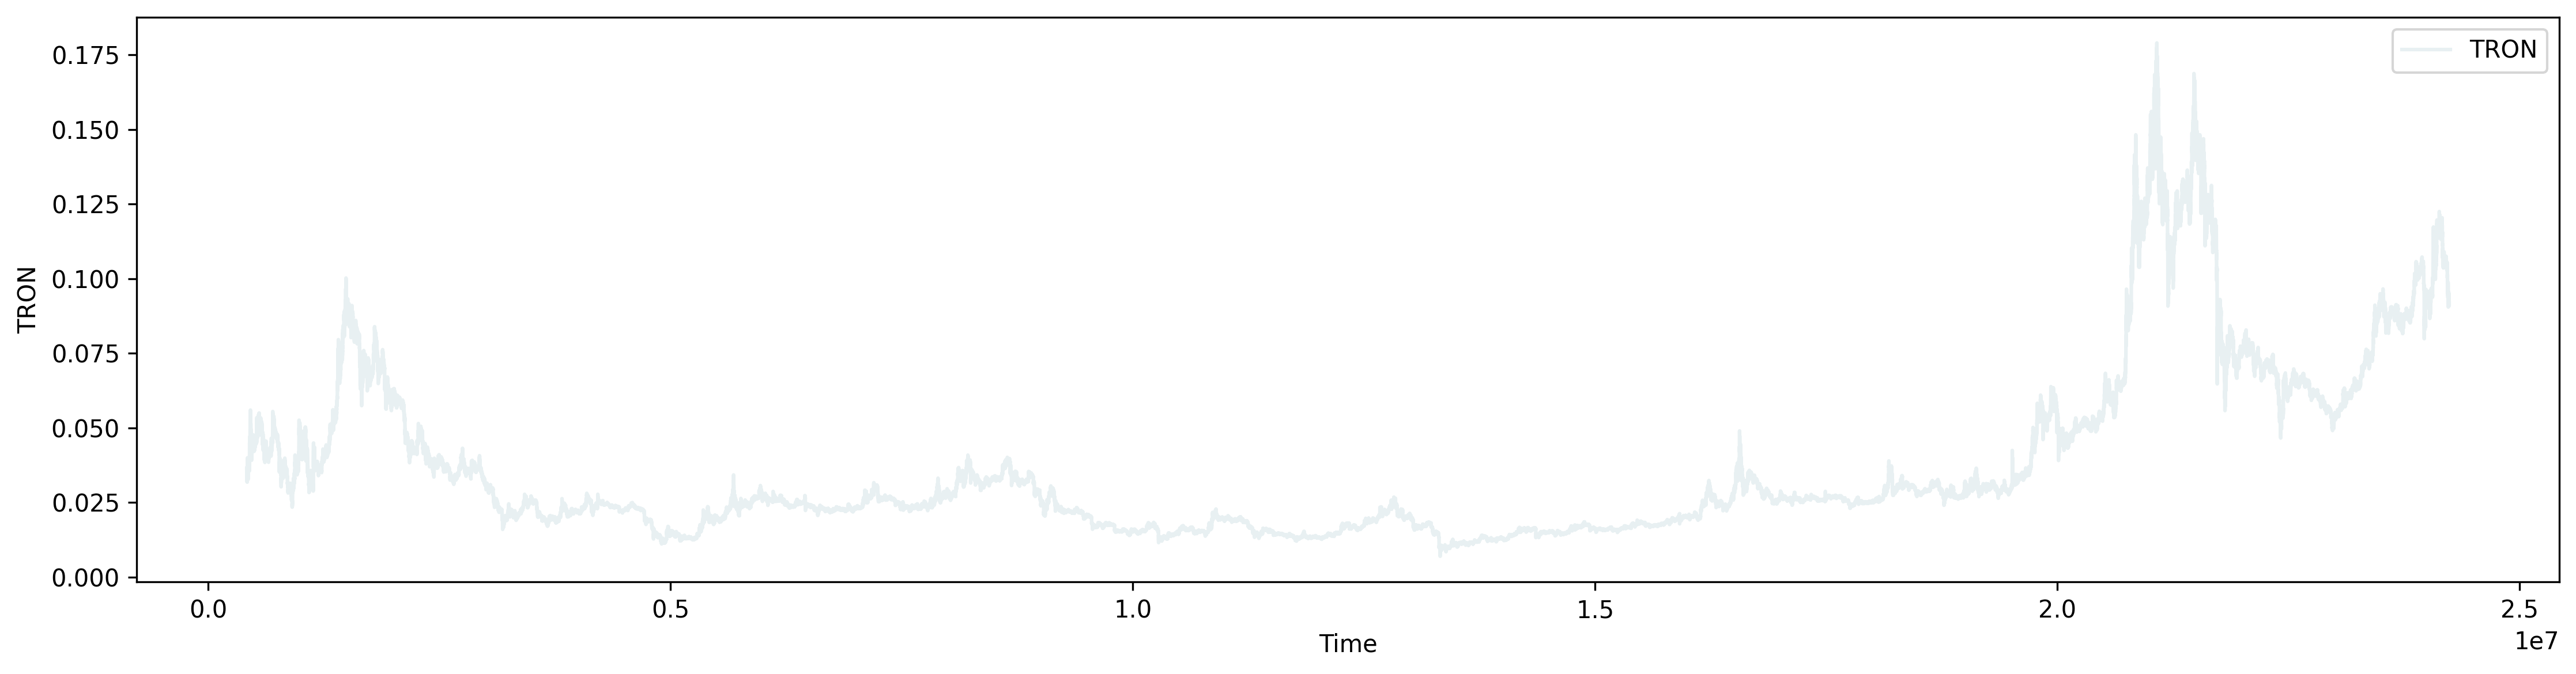

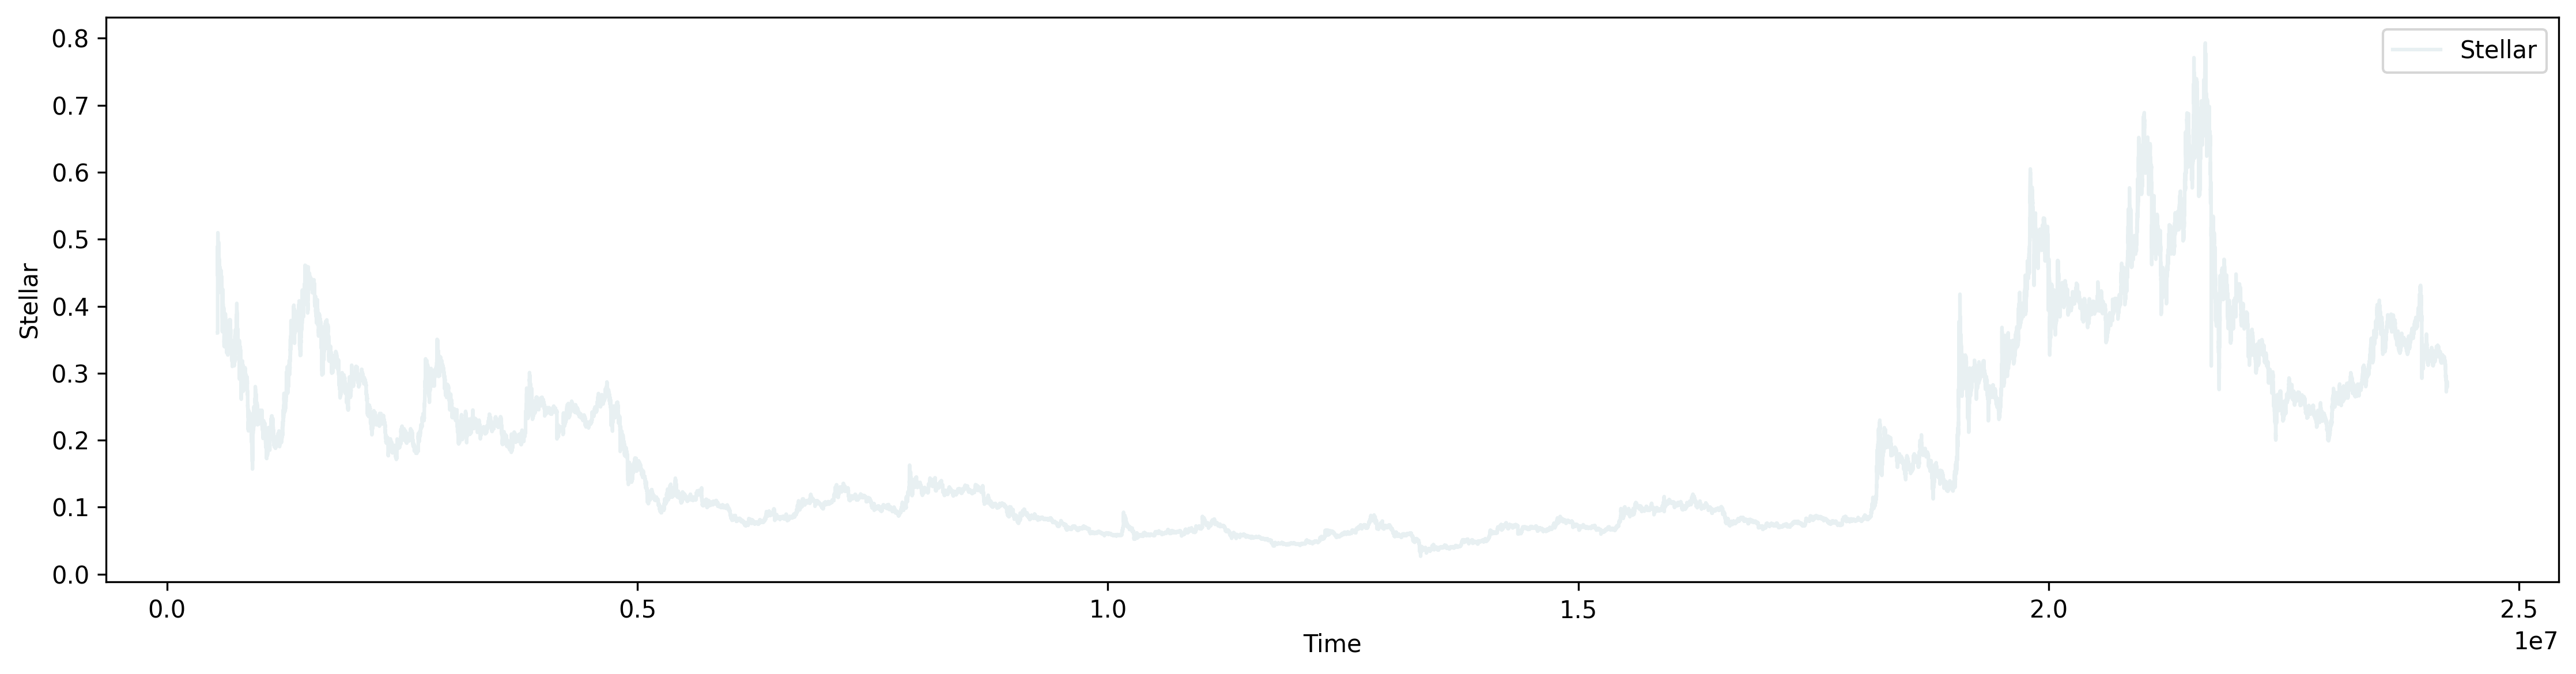

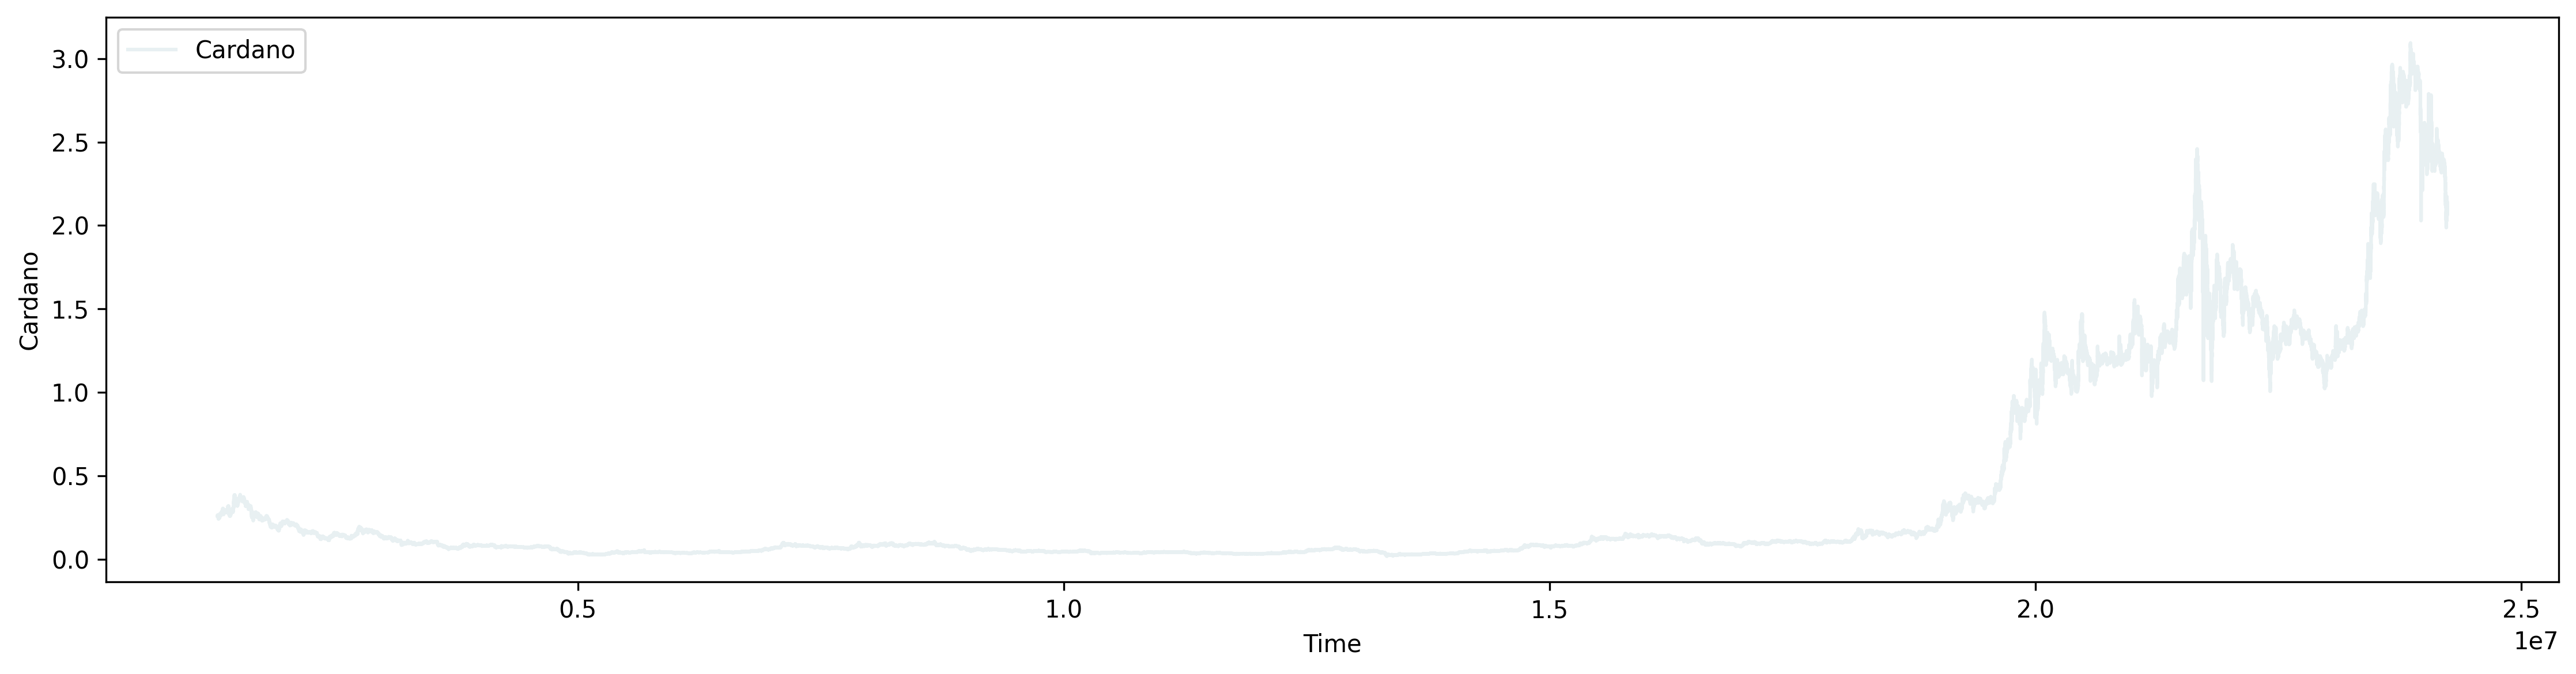

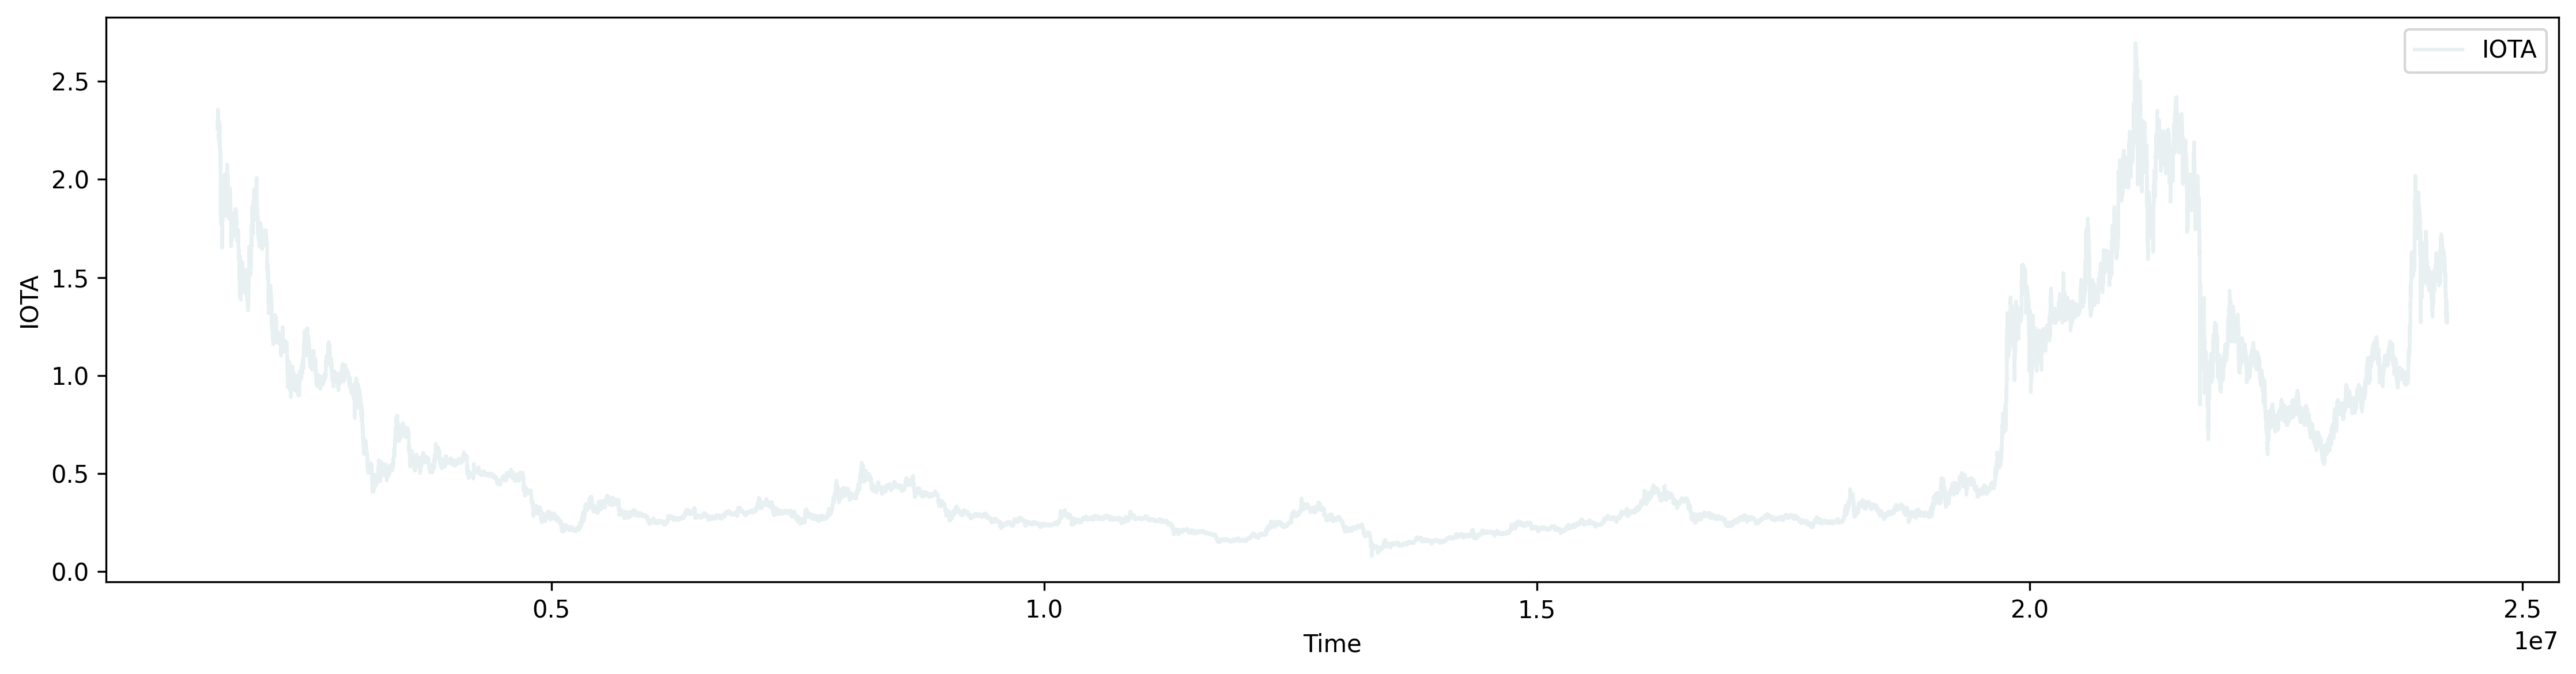

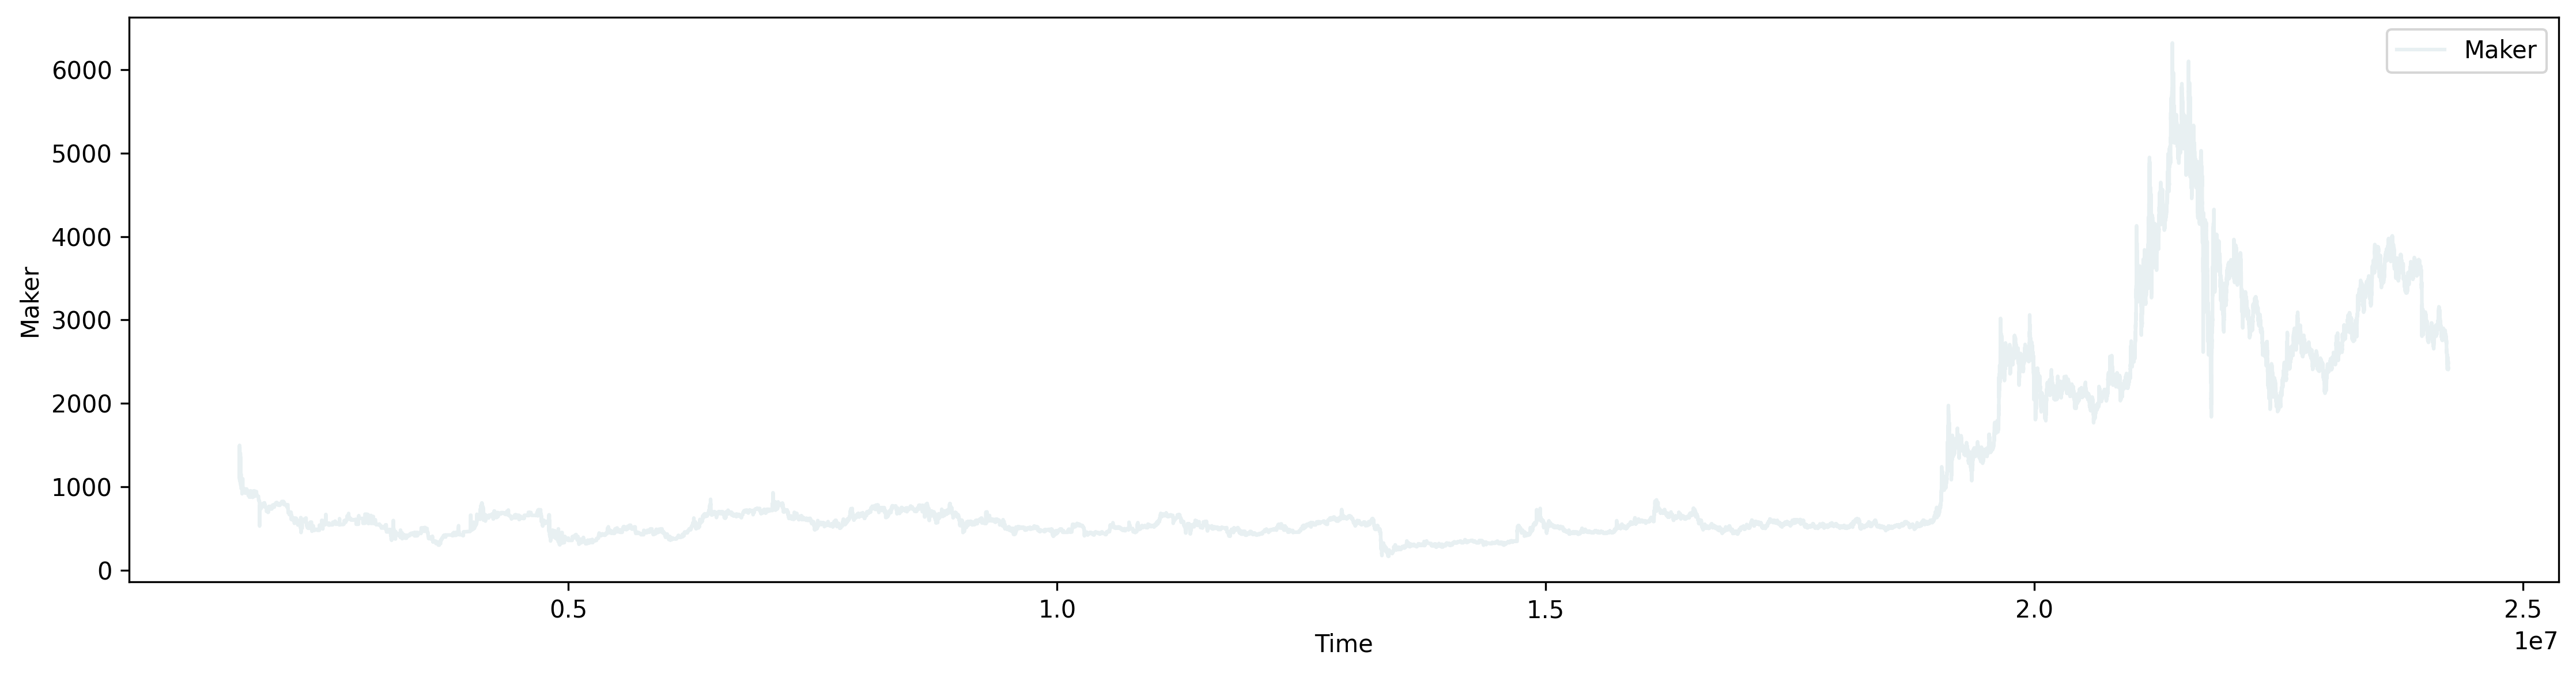

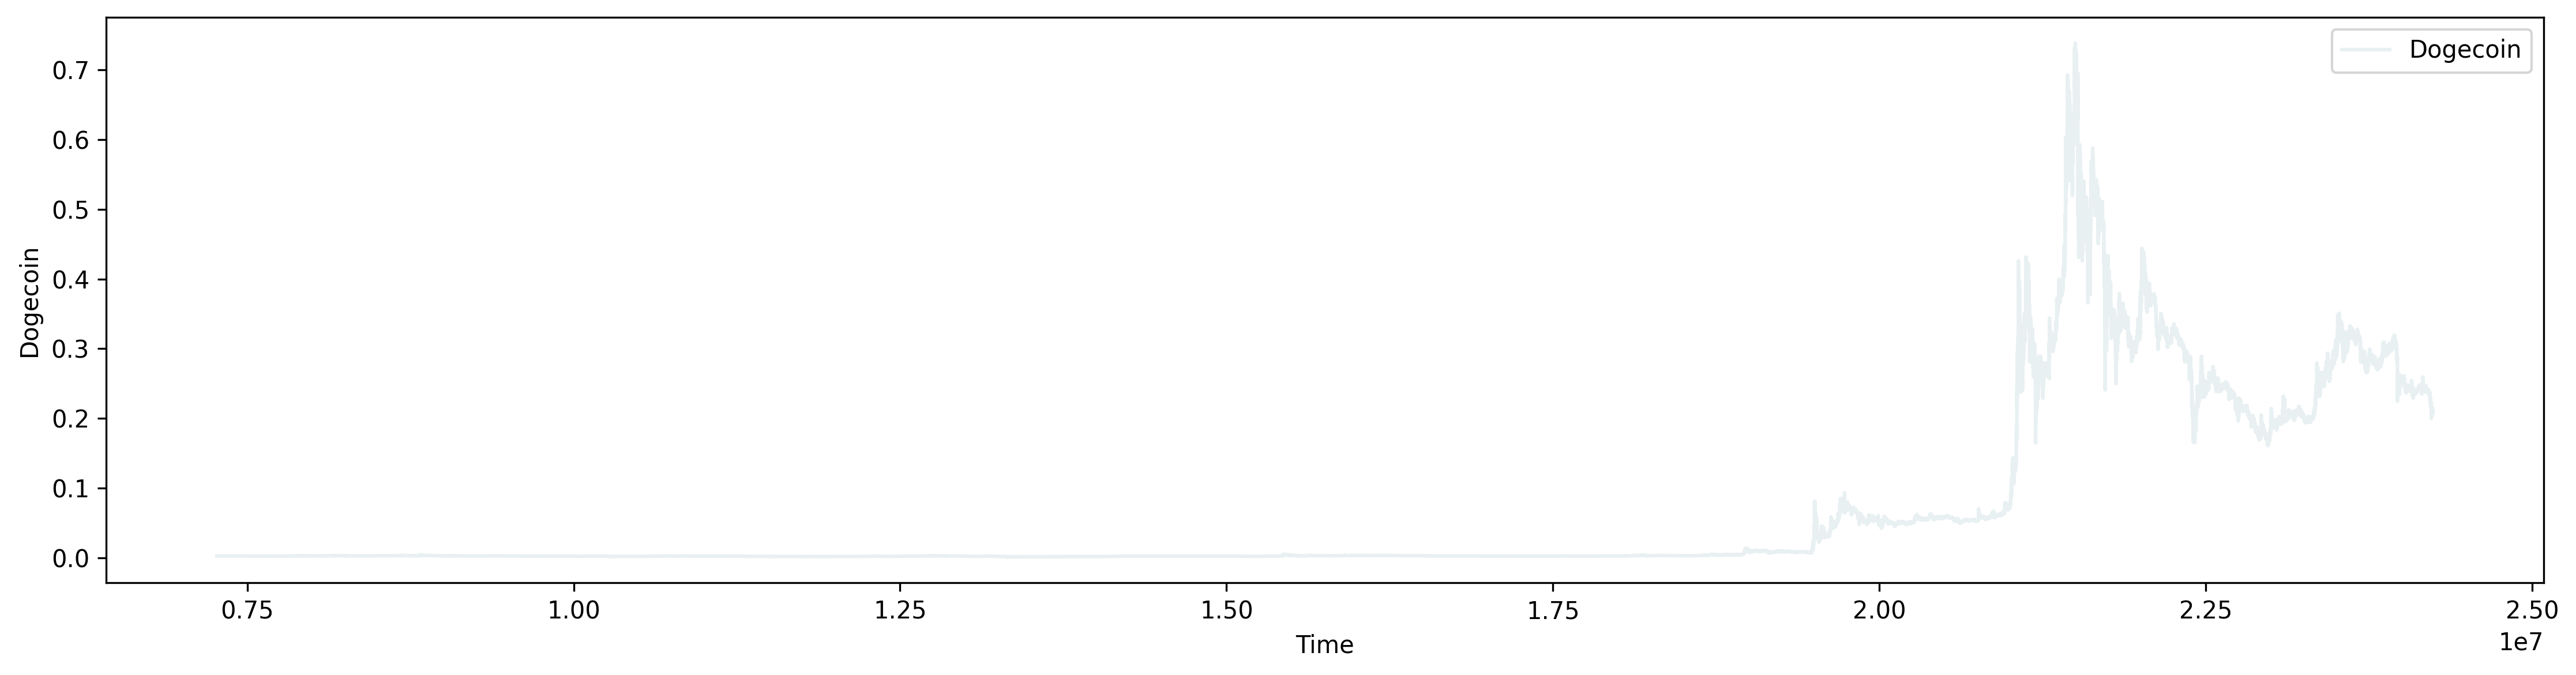

In [40]:
for key,value in currency_values.items():
    f = plt.figure(figsize=(15, 4))
    plt.plot(value['Close'], label=f'{key}')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(f'{key}')

    plt.tight_layout()
plt.show()

#### Добавим датасет asset_details для анализа

In [41]:
df_analysis = pd.merge(train_df, asset_details, how='left', on=['Asset_ID'])
df_analysis.head()

timestamp  Asset_ID  Count          Open          High          Low  \
0  1514764860         2   40.0   2376.000000   2400.000000   2358.00000   
1  1514764860         0    5.0      8.531250      8.531250      8.53125   
2  1514764860         1  229.0  13832.000000  14016.000000  13664.00000   
3  1514764860         5   32.0      7.660156      7.660156      7.65625   
4  1514764860         7    5.0     25.921875     25.921875     25.87500   

         Close       Volume          VWAP    Target    Weight  \
0   2374.00000    19.233006   2373.116392 -0.004219  2.397895   
1      8.53125    78.379997      8.530000 -0.014397  4.304065   
2  13848.00000    31.550062  13827.062093 -0.014641  6.779922   
3      7.65625  6626.713379      7.657713 -0.013924  1.386294   
4     25.87500   121.087311     25.891363 -0.008263  2.079442   

         Asset_Name  
0      Bitcoin Cash  
1      Binance Coin  
2           Bitcoin  
3            EOS.IO  
4  Ethereum Classic

<AxesSubplot:xlabel='Asset_Name', ylabel='count'>

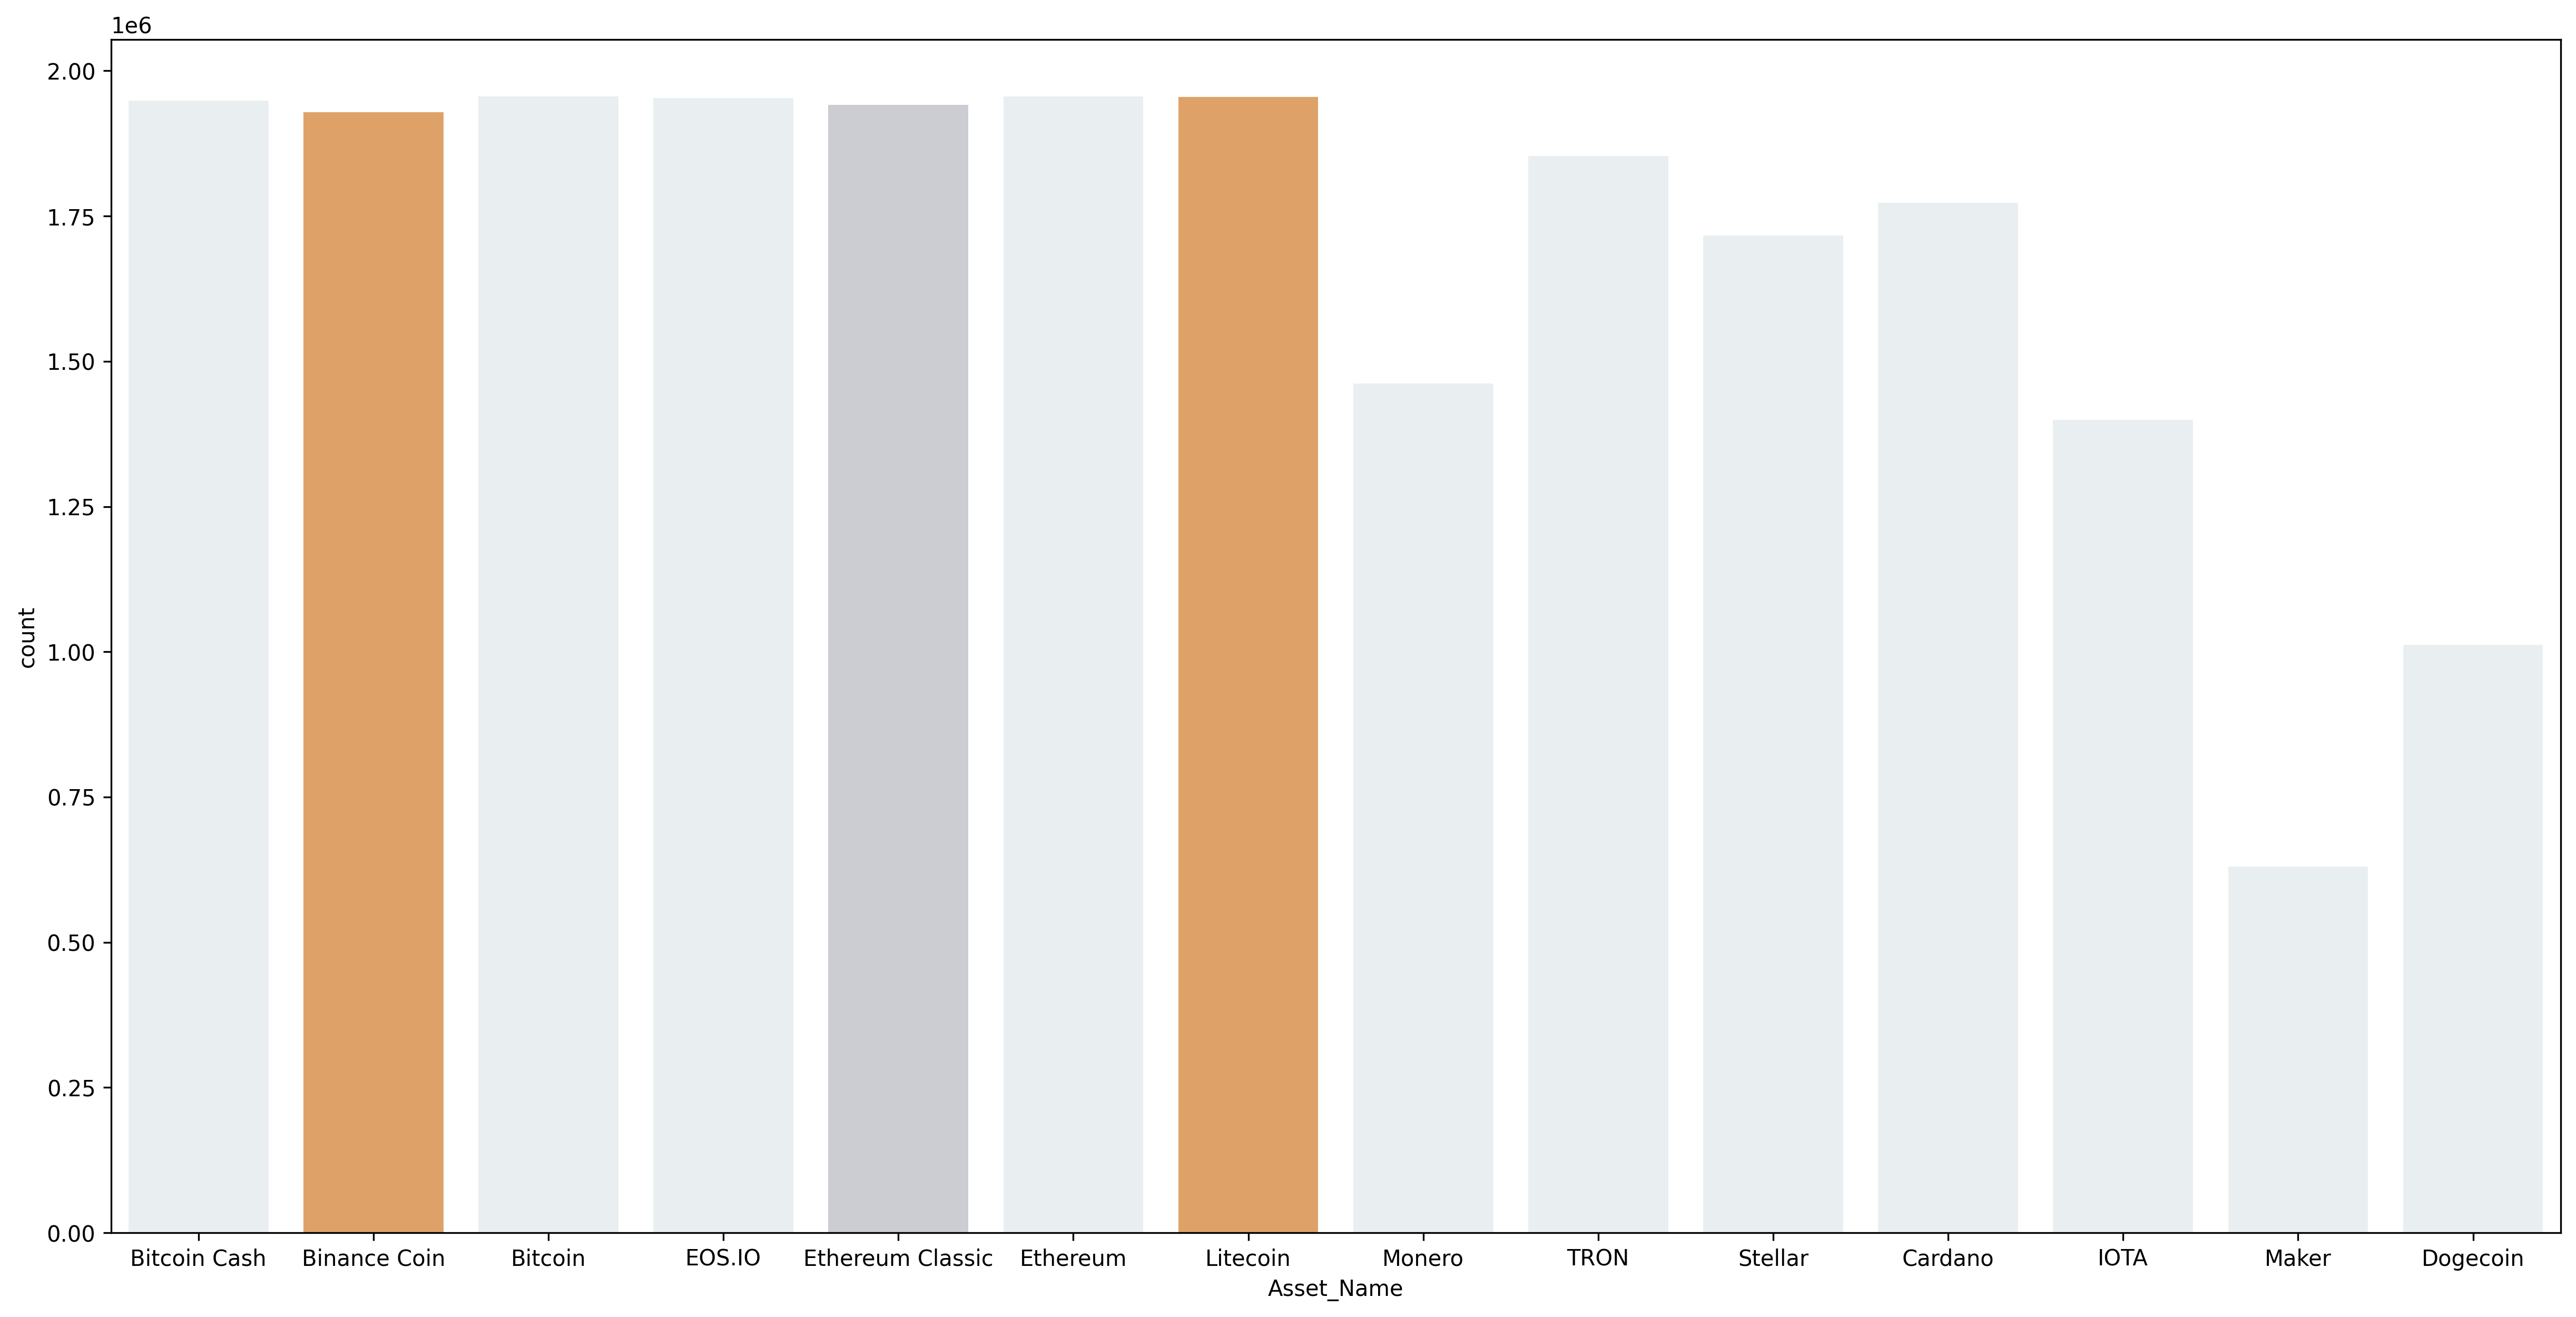

In [42]:
plt.subplots(figsize=(20,10))
sns.countplot(x='Asset_Name', data = df_analysis.dropna())

In [43]:
df = df_analysis.dropna()

<AxesSubplot:>

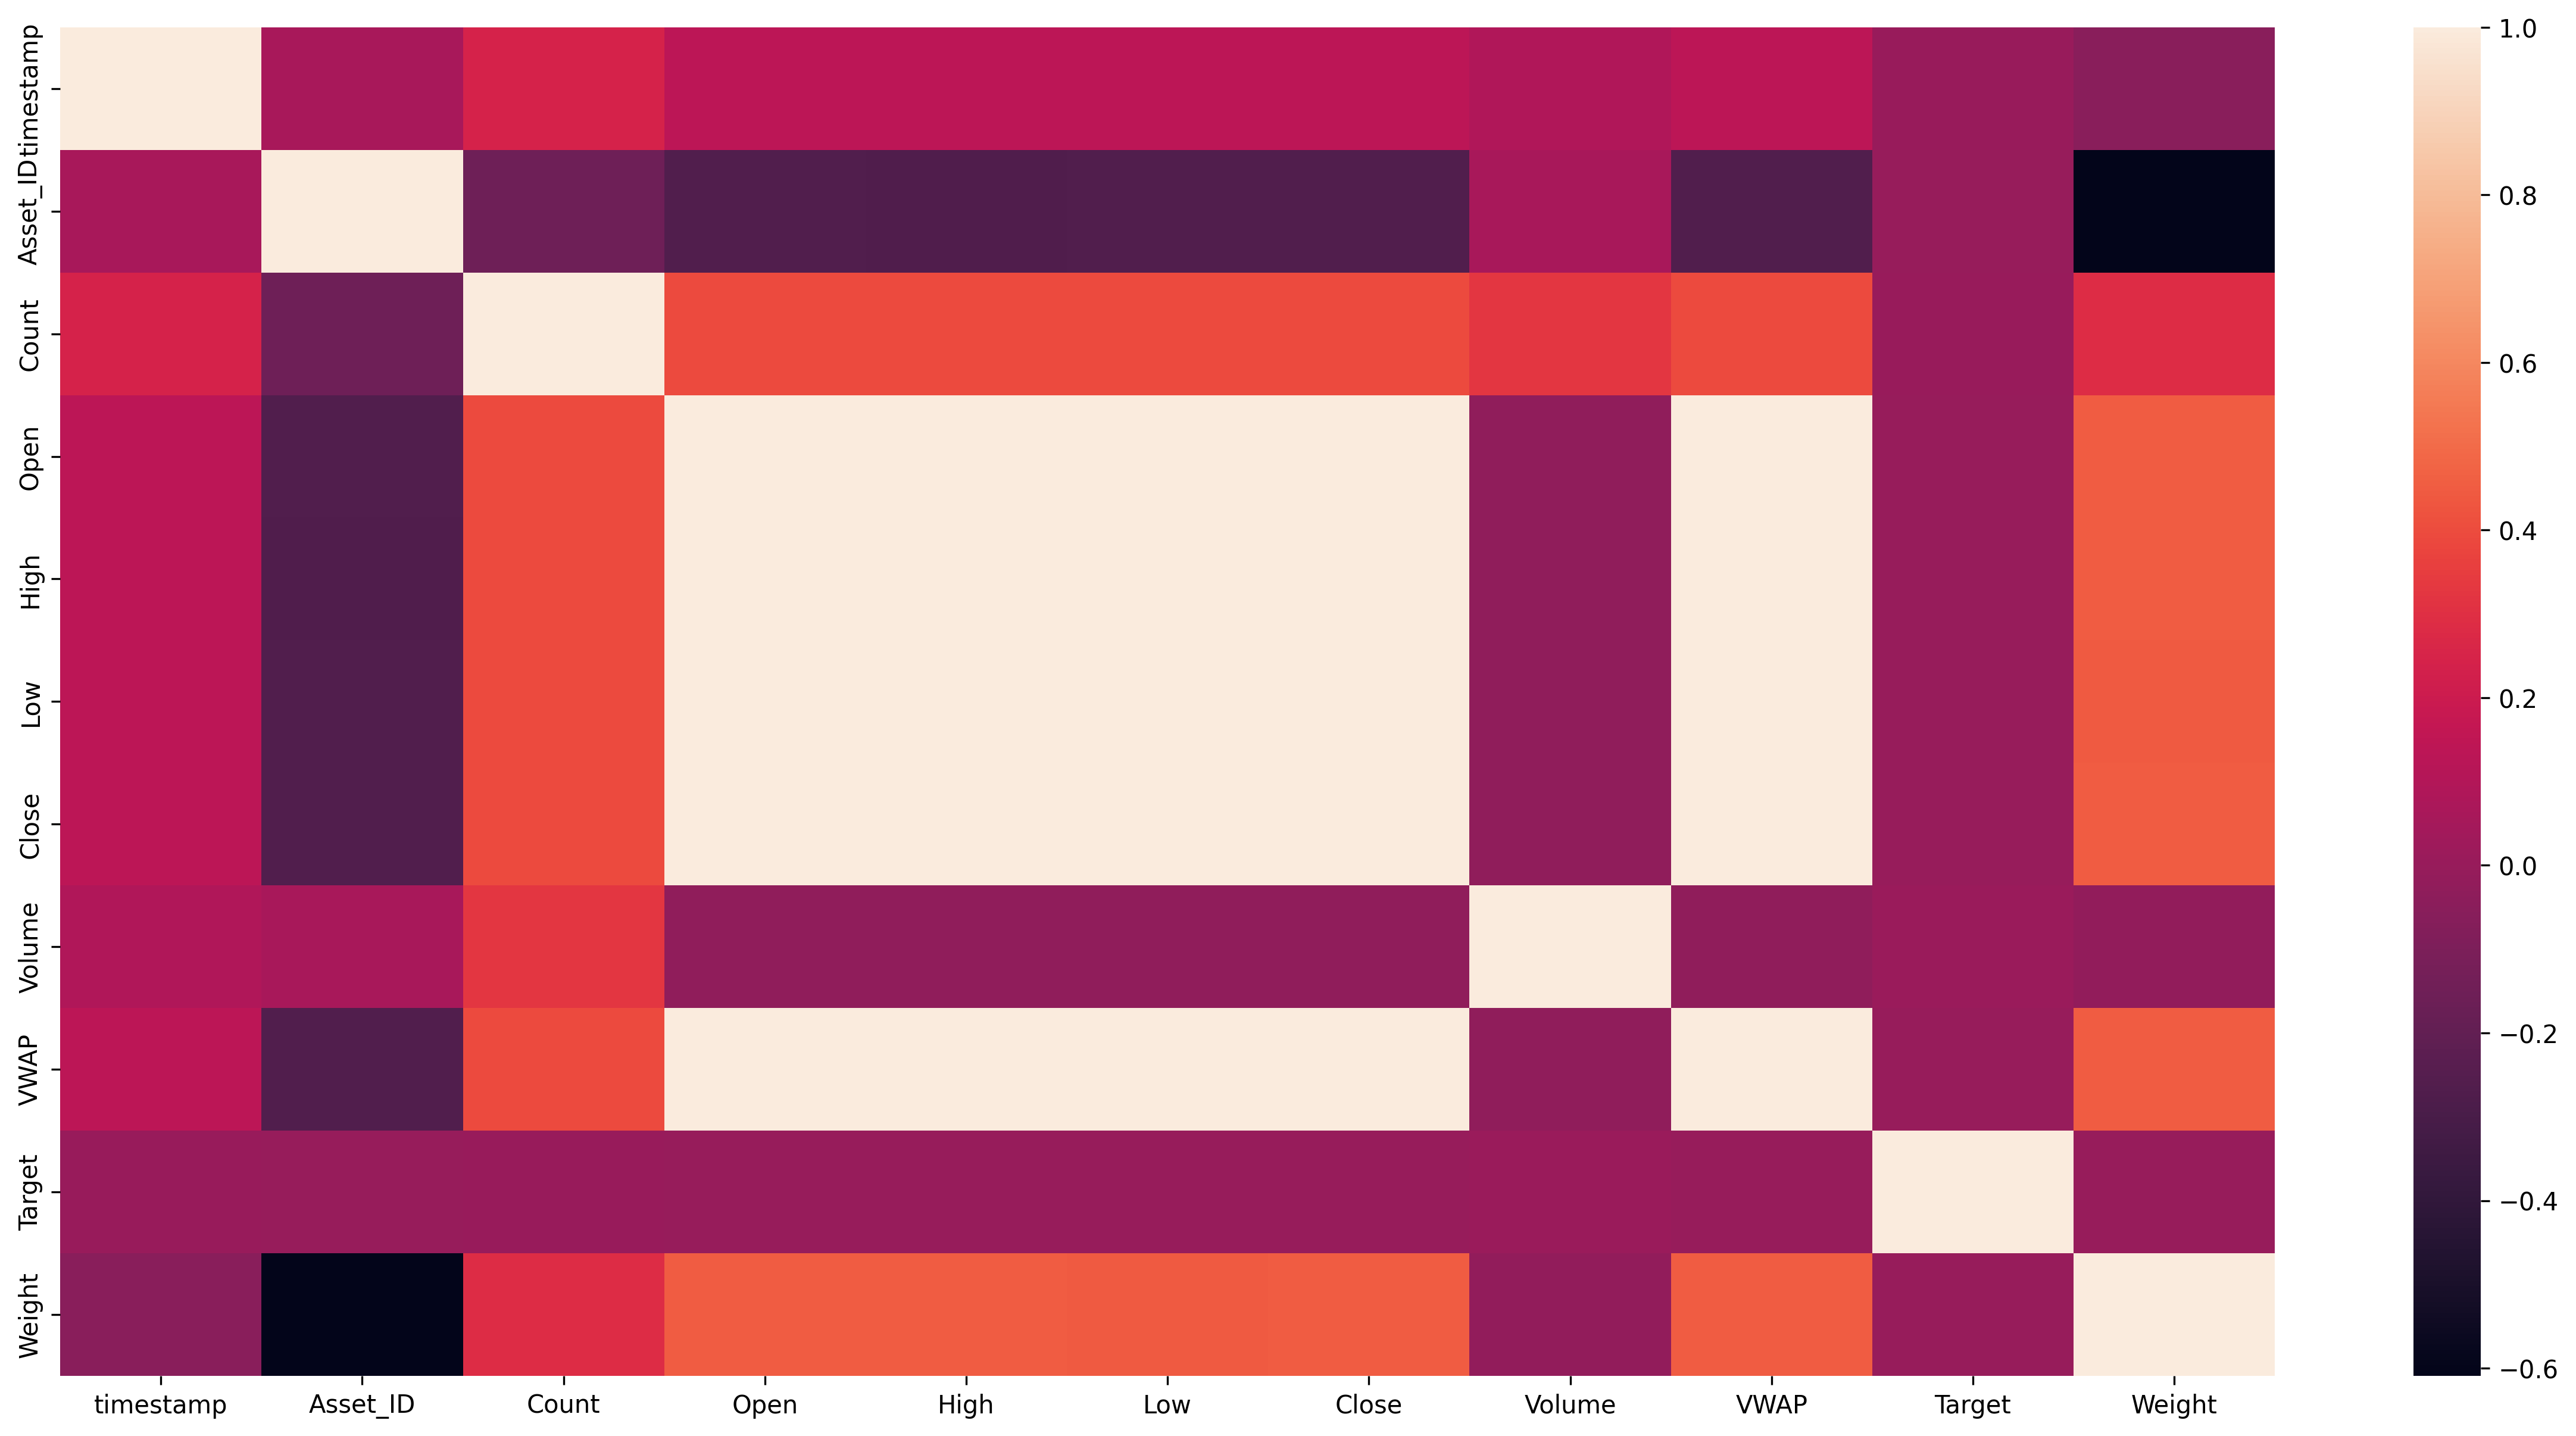

In [44]:
plt.subplots(figsize=(20,10))
sns.heatmap(df.corr())

In [45]:
df['fulldate'] = pd.to_datetime(df['timestamp'], unit='s')
df['date'] = df['fulldate'].apply(lambda d: d.date())
df['time'] = df['fulldate'].apply(lambda d: d.time())
df.head()

timestamp  Asset_ID  Count          Open          High          Low  \
0  1514764860         2   40.0   2376.000000   2400.000000   2358.00000   
1  1514764860         0    5.0      8.531250      8.531250      8.53125   
2  1514764860         1  229.0  13832.000000  14016.000000  13664.00000   
3  1514764860         5   32.0      7.660156      7.660156      7.65625   
4  1514764860         7    5.0     25.921875     25.921875     25.87500   

         Close       Volume          VWAP    Target    Weight  \
0   2374.00000    19.233006   2373.116392 -0.004219  2.397895   
1      8.53125    78.379997      8.530000 -0.014397  4.304065   
2  13848.00000    31.550062  13827.062093 -0.014641  6.779922   
3      7.65625  6626.713379      7.657713 -0.013924  1.386294   
4     25.87500   121.087311     25.891363 -0.008263  2.079442   

         Asset_Name            fulldate        date      time  
0      Bitcoin Cash 2018-01-01 00:01:00  2018-01-01  00:01:00  
1      Binance Coin 2018-01-01 00:01:00  2018-01-01  00:01:00  
2           Bitcoin 2018-01-01 00:01:00  2018-01-01  00:01:00  
3            EOS.IO 2018-01-01 00:01:00  2018-01-01  00:01:00  
4  Ethereum Classic 2018-01-01 00:01:00  2018-01-01  00:01:00

In [46]:
dtrain_sample = df.sample(10000)

In [51]:
# fig, axes = plt.subplots(7, 2, figsize=(20, 50))
# for i,asset in enumerate(asset_details['Asset_Name']):
#     df_crypt = dtrain_sample[dtrain_sample['Asset_Name'] == asset]
#     sns.lineplot(x="date", y="VWAP", data=df_crypt, ax=axes[int(i/2),i%2])
#     axes[int(i/2),i%2].set_title(asset)

In [ ]:
print("Available data period")
for i,asset in enumerate(asset_details['Asset_Name']):
    df_crypt = df[df['Asset_Name'] == asset]
    print( "{} to {} ------> {}".format(df_crypt.sort_values(by=['timestamp'])['date'].iloc[0], df_crypt.sort_values(by=['timestamp'])['date'].iloc[-1], asset ))

In [49]:
intervals_currency = {}
for currency_id in asset_details.Asset_ID:
    currency_value = train_df[train_df["Asset_ID"] == currency_id].set_index('timestamp')
    name = asset_details[asset_details.Asset_ID == currency_id]['Asset_Name'].values[0]
    intervals_currency[f"{name}_min_2021"] = currency_value.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]

In [50]:
for key, value in intervals_currency.items():
    f = plt.figure(figsize=(8, 4))
    plt.plot(value['Close'], label=f'{key}')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(f'{key}')

    plt.tight_layout()
plt.show()

## 4. Проверка Target-а <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [ ]:
check_df = train_df.copy()
check_df['Time'] = pd.to_datetime(check_df['timestamp'], unit='s')

Затем рассчитаем Target по следующей формуле

$$R^a(t) = log (P^a(t+16)\ /\ P^a(t+1))$$

Это делается для каждого актива отдельно. Мы не знаем, какую цену следует использовать. Существует пять различных цен: Открытие, Максимум, минимум, закрытие и VWAP. Вероятно, существует такая комбинация, как цена открытия за время + 1 минута и цена закрытия за время + 16 минут. В приведенных ниже расчетах мы используем цену закрытия.

In [ ]:
# use mix price
price_column = 'Close'

ids = list(asset_details.Asset_ID)
chunks = []

for id in ids:
    asset = check_df[train_df.Asset_ID == id].copy()
    asset.sort_values(by='Time', inplace=True)
    asset.set_index(keys='Time', inplace=True)
    asset['p1'] = asset[price_column].shift(freq='-1T')
    asset['p16'] = asset[price_column].shift(freq='-16T')
    asset['r'] = np.log(asset.p16/asset.p1)
    asset.drop(['p1', 'p16'], axis=1, inplace=True)
    asset.reset_index(inplace=True)
    chunks.append(asset)
    
check_df = pd.concat(chunks)
check_df.sort_values(by='Time', inplace=True)

Затем назначим вес для каждой строки. И рассчитаем M(t). Обратите внимание, что M(t) одинаков для всех активов и зависит только от времени.

$$M(t) = \frac{\sum_a w^a R^a(t)}{\sum_a w^a}$$

Не известно, ${\sum_a w^a}$ должна быть рассчитана для всех активов или только для активов, имеющих данные на момент времени t.


In [ ]:
check_df['w'] = check_df['Asset_ID'].map(asset_details.set_index(keys='Asset_ID')['Weight'])
weight_sum = asset_details.Weight.sum()

check_df['weighted_asset_r'] = check_df.w * check_df.r
time_group = check_df.groupby('Time')

m = time_group['weighted_asset_r'].sum() / time_group['w'].sum()

check_df.set_index(keys=['Time'], inplace=True)
check_df['m'] = m
check_df.reset_index(inplace=True)

После этого рассчитывается бета-версия. В скобках $\langle .\rangle$ представляет собой скользящее среднее значение по времени (3750-минутные интервалы). Если нет полного 3750-минутного интервала, $\beta$ становится нулевым.
$$\beta^a = \frac{\langle M \cdot R^a \rangle}{\langle M^2 \rangle}$$

In [ ]:
check_df['m2'] = check_df.m ** 2
check_df['mr'] = check_df.m * check_df.r

chunks = []

for id in ids:
    asset = check_df[check_df.Asset_ID == id].copy()
    asset.sort_values(by='Time', inplace=True)
    asset.set_index(keys='Time', inplace=True)
    asset['mr_rolling'] = asset['mr'].rolling(window='3750T', min_periods=3750).mean()
    asset['m2_rolling'] = asset['m2'].rolling(window='3750T', min_periods=3750).mean()
    asset.reset_index(inplace=True)
    chunks.append(asset)
    
    debug = 1
    
check_df = pd.concat(chunks)
check_df.sort_values(by='Time', inplace=True)
check_df['beta'] = check_df['mr_rolling'] / check_df['m2_rolling']

Все, target вычислен
$$\text{Target}^a(t) = R^a(t) - \beta^a M(t)$$

In [ ]:
check_df['Target_recreated'] = check_df['r'] - check_df['beta'] * check_df['m']

Теперь сравним воссозданный Target

In [ ]:
check_df['Target_diff'] = np.abs(check_df['Target'] - check_df['Target_recreated'])

print(f'Average absolute error {check_df.Target_diff.mean():8.6f}')
print(f'Max absolute error {check_df.Target_diff.max():8.6f}')
print(f'Standart absolute error {check_df.Target_diff.std():8.6f}')

Нормальная цель изменяется в диапазоне [-0.5, 0.96], поэтому максимальная абсолютная ошибка 2.4 означает, что воссозданная цель полностью неверна для некоторых записей.

In [ ]:
check_df['Target'].agg(['min', 'max'])

Проверим сколько записей у нас с неправильными Targetами

In [ ]:
(check_df.Target_recreated < -0.509351).sum(), (check_df.Target_recreated > 0.964170).sum()

Я пробовал разные цены, менял временные интервалы в формуле, заменял скользящее среднее с 3750 минут на 3750 последних записей и т.д., но результат тот же или хуже. Можно минимизировать максимальную ошибку, но среднее значение стало выше.

Пожалуйста, дайте мне знать, если вы обнаружите ошибку в расчетах или у вас будет какое-то представление о том, как на самом деле вычисляется исходный целевой показатель.

Добавьте код, добавляющий Markdown
Оказывается, что этот код дает много значений NA в воссозданном целевом показателе, поэтому минимизация ошибок Abs/Max, возможно, вводила в заблуждение.

Проблема такая, что выше пречиленный код создает много значений NA, которых не было в оригинале. Для решения этой проблемы попробуем другой способ.

In [ ]:
pd.isna(data.Target).sum()

In [ ]:
pd.isna(data.Target_recreated).sum()pd.isna(data.Target_recreated).sum()pd.isna(data.Target_recreated).sum()pd.isna(data.Target_recreated).sum()pd.isna(data.Target_recreated).sum()pd.isna(data.Target_recreated).sum()

В результате воссозданный целевой объект имеет более чем в 10 раз больше значений NA. Давайте проверим, когда были введены эти NA.

In [ ]:
pd.isna(data.r).sum()

При расчете R количество NA практически равно количеству целевых NA. Разница составляет 1086. Это может быть объяснено отсутствием первой минуты каждого месяца для каждого актива.

Интересно, что цель присутствует в наборе данных о поездах для таких дат, как ГГГГ-ММ-01 23:44:00 (t+16) и ГГГГ-ММ-01 23:59:00 (t+1). Для этих случаев алгоритм расчета требует наличия цены на момент ГГГГ-ММ-01 00:00:00, но это время отсутствует в тестовых данных. Это можно рассматривать как доказательство того, что цель была вычислена на основе других данных, а затем набор обучающих данных был создан с уже вычисленной целью.

Ошибка, из-за которой отсутствует первая минута месяца, дает приблизительно 44 месяца х 2 (каждая строка влияет на две цели для смены 1 и 16) х 14 (количество активов) => 1232. В некоторых активах отсутствуют данные за все месяцы.

Единственное другое место, где можно получить NA, - это следующий код

переход(window='3750T', min_periods=3750)

пропущенные значения в интервале 3750 минут приводят к значениям NA.

Теперь давайте посмотрим на код, предоставленный хостом:

число = df.умножение(mkt.значения, ось=0).переход (окно).среднее значение().значения
значение = mkt.умножение(mkt.значения, ось=0).переход(окно).среднее значение().значения

Существует два возможных типа окна, которые принимает rolling - это может быть либо shift/int (количество строк для сдвига), либо time offset (количество минут для сдвига), но параметра min_periods нет. Это означает, что для int shift он вообще не выдает NA, а для time offset он может выдавать NA, только если нет данных за последние 3750 минут.

Следующая строка кода вычисляет beta и удаляет все результирующие значения, отличные от чисел, с нулем:

бета = np.nan_to_num( число.T / denom, nan=0., posinf=0., neginf=0.)

Вывод здесь заключается в том, что добавление min_periods=3750, которое, казалось бы, улучшило наши показатели, на самом деле добавило множество значений NA, эффективно минимизируя данные, в которых эти показатели вычислялись. Основной код показывает, что скользящее среднее значение не приводит к дополнительным значениям NA.

Более оптимизированная версия¶
Здесь мы пытаемся сделать две вещи: решить проблему с NA и ускорить работу этого кода, а также повторно использовать код с хостинга. Код из хостинга показывает, что данные должны быть представлены немного по-другому, чтобы избежать дорогостоящих операций сдвига/переноса на основе минут и выполнить расчет для всех ресурсов сразу.

добавить код, добавить уценку
Мы начинаем с создания нового фрейма данных, в котором присутствуют все временные метки (минуты). В поезде для некоторых целей может не хватить нескольких минут.

In [ ]:
ids = list(asset_details.Asset_ID)
asset_names = list(asset_details.Asset_Name)

all_timestamps = np.sort(check_df['timestamp'].unique())
targets = pd.DataFrame(index=all_timestamps)

calcualte r, некоторые столбцы могут содержать NA, так как некоторые даты со свдигом могут отсутствовать

Далее мы вычисляем R для каждого актива и добавляем его значения в виде столбца в новый целевой фрейм данных. Обратите внимание, что некоторые строки будут содержать NA, так как требуемые цены со сдвигом могут отсутствовать.

In [ ]:
for i, id in enumerate(ids):
    asset = check_df[check_df.Asset_ID == id].set_index(keys='timestamp')
    price = pd.Series(index=all_timestamps, data=asset[price_column])
    
    targets[asset_names[i]] = (
        price.shift(periods=-16)/price.shift(periods=-1)
    ) - 1

Затем вычисляется как средневзвешенное значение столбцов (в настоящее время содержащих значение R для каждого актива) для каждой строки. В этой реализации недоступные значения R считаются равными нулю. Пожалуйста, обратите внимание, что это не единственный способ обработки значений NA при расчете средневзвешенного значения.

In [ ]:
weights = np.array(list(asset_details.Weight))
targets['m'] = np.average(targets.fillna(0), axis=1, weights=weights)

Наконец, пришло время применить код, предоставленный хостером, для расчета бета-версии и целевого показателя.

In [ ]:
m = targets['m']

num = targets.multiply(m.values, axis=0).rolling(3750).mean().values
denom = m.multiply(m.values, axis=0).rolling(3750).mean().values
beta = np.nan_to_num(num.T / denom, nan=0., posinf=0., neginf=0.)

targets = targets - (beta * m.values).T

Давайте проверим, насколько это отличается от заданной цели и сколько у нас значений NA.

In [ ]:
diffs = []

for i, id in enumerate(ids):
    print(asset_names[i])
    # type: pd.DataFrame
    asset = check_df[check_df.Asset_ID == id].set_index(keys='timestamp')
    print(f'asset size {asset.shape[0]}')
    recreated = pd.Series(index=asset.index, data=targets[asset_names[i]])
    diff = np.abs(asset['Target'] - recreated)
    diffs.append(diff[~pd.isna(diff)].values)
    print(f'Average absolute error {diff.mean():8.6f}')
    print(f'Max absolute error {diff.max():8.6f}')
    print(f'Standard deviation {diff.std():8.6f}')
    print(f'Target na {pd.isna(asset.Target).sum()}')
    print(f'Target_calculated na {pd.isna(recreated).sum()}')
    print()

diffs = np.concatenate(diffs, axis=0)
print('For all assets')
print(f'Average absolute error {diffs.mean():8.6f}')
print(f'Max absolute error {diffs.max():8.6f}')
print(f'Standard deviation {diffs.std():8.6f}')

Это все еще не идеально, но, по крайней мере, наши показатели рассчитываются практически по всем доступным данным, а количество NA почти такое же, как в Target.

добавляем код, добавляем Markdown
Обсуждается, что бета равна нулю. Это превращает расчет Target просто в расчет R. Давайте посмотрим, сколько у нас есть нечисловых значений и сколько строк имеют значение beta=0.

In [ ]:
beta_ = num.T / denom

for i, id in enumerate(ids):
    print(asset_names[i])
    print(f'Infiinte beta rows {np.isinf(beta_[i]).sum()}')
    nan_sum = np.isnan(beta_[i]).sum()
    print(f'NAN beta rows {nan_sum} ({100 * nan_sum / beta_.shape[1]:5.2f}%)')

    eps = 1e-6
    zero_sum = ((beta[i] > -eps) & (beta[i] < eps)).sum()
    print(f'Zero beta rows {zero_sum} ({100 * zero_sum / beta.shape[1]:5.2f}%)')
    print()

Ниже приведен тот же код, но в виде функции, которую вы можете скопировать и вставить. Обратите внимание, что для этого не требуется столбец времени, вместо него используется временная метка.

In [ ]:
def calculate_target(data: pd.DataFrame, details: pd.DataFrame, price_column: str):
    """Данная функция перерасчитывает наш Target по формуле, которая дается в качестве описания проекта"""
    ids = list(details.Asset_ID)
    asset_names = list(details.Asset_Name)
    weights = np.array(list(details.Weight))

    all_timestamps = np.sort(data['timestamp'].unique())
    targets = pd.DataFrame(index=all_timestamps)

    for i, id in enumerate(ids):
        asset = data[data.Asset_ID == id].set_index(keys='timestamp')
        price = pd.Series(index=all_timestamps, data=asset[price_column])
        targets[asset_names[i]] = (
            price.shift(periods=-16) /
            price.shift(periods=-1)
        ) - 1
    
    targets['m'] = np.average(targets.fillna(0), axis=1, weights=weights)
    
    m = targets['m']

    num = targets.multiply(m.values, axis=0).rolling(3750).mean().values
    denom = m.multiply(m.values, axis=0).rolling(3750).mean().values
    beta = np.nan_to_num(num.T / denom, nan=0., posinf=0., neginf=0.)

    targets = targets - (beta * m.values).T
    targets.drop('m', axis=1, inplace=True)
    
    return targets

In [ ]:
check_df.columns

In [ ]:
check_df

## 5. Feature engineering <a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

In [8]:
def get_features(df):
    """Feature engineering by row
    """
    df['upper_shadow'] = df['High'] / df[['Close', 'Open']].max(axis=1)
    df['lower_shadow'] = df[['Close', 'Open']].min(axis=1) / df['Low']
    df['open2close'] = df['Close'] / df['Open']
    df['high2low'] = df['High'] / df['Low']
    mean_price = df[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    median_price = df[['Open', 'High', 'Low', 'Close']].median(axis=1)
    df['high2mean'] = df['High'] / mean_price
    df['low2mean'] = df['Low'] / mean_price
    df['high2median'] = df['High'] / median_price
    df['low2median'] = df['Low'] / median_price
    df['volume2count'] = df['Volume'] / (df['Count'] + 1)
    return df 

In [9]:
def get_data_for_asset(df_train, asset_id):
    # Get X and y
    
    df = df_train[df_train["Asset_ID"] == asset_id]    
    df_proc = get_features(df)
    df_proc['y'] = df['Target']
    #df_proc = df_proc[~df_proc.isin([np.nan, np.inf, -np.inf]).any(1)].reset_index(drop=True)
    df_proc = df_proc.dropna(how="any")
    
    X = df_proc.drop("y", axis=1)
    X = X.drop('Target', axis=1)
    y = df_proc["y"]
    
    return X, y

## 6. Model training and prediction <a class="anchor" id="6"></a>

### 1. Скользящее среднее(MV) <a class="anchor" id="6.1"></a>

[Back to Table of Contents](#0.1)

Скользящая средняя
Вступление
‘Средний" - это, несомненно, одна из самых распространенных вещей, которые мы используем в повседневной жизни. Например, вычисление средних оценок для определения общей производительности или определение средней температуры за последние несколько дней, чтобы получить представление о сегодняшней температуре, – все это рутинные задачи, которые мы выполняем на регулярной основе. Таким образом, это хорошая отправная точка для использования в нашем наборе данных для составления прогнозов.

Прогнозируемая цена закрытия на каждый день будет представлять собой среднее значение из набора ранее наблюдавшихся значений. Вместо использования простого среднего мы будем использовать метод скользящей средней, который использует последний набор значений для каждого прогноза. Другими словами, на каждом последующем шаге учитываются прогнозируемые значения, при этом из набора удаляется самое старое наблюдаемое значение. Вот простой рисунок, который поможет вам понять это с большей ясностью.



Мы применим этот метод к нашему набору данных. Первым шагом является создание фрейма данных, содержащего только столбцы даты и цены закрытия, а затем разделение его на наборы данных для подготовки и проверки для проверки наших прогнозов.

In [10]:
def moving_avg_prediction(df, asset_id, train_window, valid_window):
    shape=df.shape[0]
#     x, y = get_data_for_asset(df, asset_id)
    df = df.set_index('timestamp')
    x, y = get_data_for_asset(df, asset_id)
    df_new = y #x[['']]
#     print(df_new.head())
    train_set = df_new.loc[train_window[0]:train_window[1]]#df_new.iloc[:ceil(shape*0.75)]
    valid_set = df_new.loc[valid_window[0]:valid_window[1]]#df_new.iloc[ceil(shape*0.75):]
    print('-----------Prediction by MOVING AVERAGE--------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    preds = []
    len_valid_set = valid_set.shape[0]
    for i in tqdm(range(0, len_valid_set)):
        a = train_set[len(train_set) - len_valid_set+i:].sum() + sum(preds)
        b = a / (len_valid_set)
        preds.append(b)
    rms=np.sqrt(np.mean(np.power((np.array(valid_set)-preds),2)))
    print('RMSE value on validation set:',rms)
    valid_sets = pd.DataFrame({'y': valid_set, 'predictions': preds})
#     plt.plot(train_set)
#     plt.plot(valid_sets[['y', 'predictions']])
#     plt.xlabel('Date',size=20)
#     plt.ylabel('Stock Price',size=20)
#     plt.title(f'Asset_id_{asset_id}',size=20)
#     plt.legend(['Model Training Data','Actual Data','Predicted Data'])
#     plt.show()

In [12]:
# train_window = [totimestamp("01/01/2020"), totimestamp("31/05/2020")]
# valid_window = [totimestamp("01/06/2020"), totimestamp("01/07/2020")]

train_window = [totimestamp("01/01/2020"), totimestamp("21/10/2020")]
valid_window = [totimestamp("22/10/2020"), totimestamp("01/01/2021")]
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
    moving_avg_prediction(train_df, asset_id, train_window, valid_window)

-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (422941,)
Shape of Validation Set (102238,)


100%|██████████| 102238/102238 [16:50<00:00, 101.17it/s]


RMSE value on validation set: 0.002713524307562429
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (422001,)
Shape of Validation Set (102238,)


100%|██████████| 102238/102238 [17:08<00:00, 99.37it/s]


RMSE value on validation set: 0.005300277283118812
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (355340,)
Shape of Validation Set (100571,)


100%|██████████| 100571/100571 [17:22<00:00, 96.45it/s]


RMSE value on validation set: 0.00467253383522325
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (148644,)
Shape of Validation Set (102238,)


100%|██████████| 102238/102238 [17:51<00:00, 95.42it/s]


RMSE value on validation set: 0.003913638089803129
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (423309,)
Shape of Validation Set (102238,)


100%|██████████| 102238/102238 [18:03<00:00, 94.40it/s]


RMSE value on validation set: 0.003690351388422914
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (244671,)
Shape of Validation Set (77766,)


100%|██████████| 77766/77766 [10:23<00:00, 124.77it/s]


RMSE value on validation set: 0.006974570379046127
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (420122,)
Shape of Validation Set (102071,)


100%|██████████| 102071/102071 [17:53<00:00, 95.11it/s]


RMSE value on validation set: 0.006767095242981028
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (423315,)
Shape of Validation Set (102238,)


100%|██████████| 102238/102238 [18:09<00:00, 93.84it/s]


RMSE value on validation set: 0.001936264261333533
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (423333,)
Shape of Validation Set (102238,)


100%|██████████| 102238/102238 [18:04<00:00, 94.31it/s]


RMSE value on validation set: 0.003120041292005581
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (272127,)
Shape of Validation Set (99227,)


100%|██████████| 99227/99227 [17:04<00:00, 96.81it/s] 


RMSE value on validation set: 0.006078559932101944
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (422039,)
Shape of Validation Set (102238,)


100%|██████████| 102238/102238 [18:15<00:00, 93.34it/s]


RMSE value on validation set: 0.00359424315053104
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (423296,)
Shape of Validation Set (102238,)


100%|██████████| 102238/102238 [17:58<00:00, 94.82it/s]


RMSE value on validation set: 0.003555864312457107
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (423322,)
Shape of Validation Set (102238,)


100%|██████████| 102238/102238 [18:17<00:00, 93.14it/s]


RMSE value on validation set: 0.0021361958801136074
-----------Prediction by MOVING AVERAGE--------
Shape of Training Set (422063,)
Shape of Validation Set (101902,)


100%|██████████| 101902/101902 [18:23<00:00, 92.34it/s]


RMSE value on validation set: 0.0030670438178400025


Разделим наш датасет на обучающую и тестовую выборки.

### 2. BaseLine: LinearRegression <a class="anchor" id="6.2"></a>

[Back to Table of Contents](#0.1)

Мы попробуем использовать простую модель линейной регрессии для разработанных нами функций.

In [52]:
def linear_regression_prediction(df, asset_id, train_window, valid_window):
    df = df.set_index('timestamp')
    X, y = get_data_for_asset(df, asset_id)  
    max_value = np.nanmax(X['VWAP'][X['VWAP'] != np.inf ])
    #replace inf and -inf in column with max value of column 
    X['VWAP']. replace([np.inf , -np.inf ], max_value, inplace = True)

    X_asset_train = X.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
    y_asset_train = y.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

    X_asset_test = X.loc[valid_window[0]:valid_window[1]].fillna(0).to_numpy() 
    y_asset_test = y.loc[valid_window[0]:valid_window[1]].fillna(0).to_numpy() 
    
    # Теперь мы стандартизируем входные данные. 
    # Стандартизация - это процесс приведения различных переменных к одной и той же шкале. 
    # В регрессионном анализе часто важно стандартизировать независимые переменные, иначе вы рискуете получить недостоверные результаты.
    
    scaler = StandardScaler()
    X_asset_train_scaled = scaler.fit_transform(X_asset_train)
    X_asset_test_scaled = scaler.transform(X_asset_test)
    
    # BaseLine model    
    lr_mod = LinearRegression()
    lr_mod.fit(X_asset_train_scaled, y_asset_train)
    separete_lin_model.append(lr_mod)
    
    y_pred_lr_asset = lr_mod.predict(X_asset_test_scaled)

    rms=np.sqrt(np.mean(np.power((np.array(y_asset_test) - y_pred_lr_asset), 2)))
    print('RMSE value on validation set:',rms)
#     valid_sets = pd.DataFrame({'y': y_asset_test, 'predictions': y_pred_lr_asset})
#     plt.plot(y_asset_train)
#     plt.plot(valid_sets[['y', 'predictions']])
#     plt.xlabel('Date',size=20)
#     plt.ylabel('Stock Price',size=20)
#     plt.title(f'Asset_id_{asset_id}',size=20)
#     plt.legend(['Model Training Data','Actual Data','Predicted Data'])
#     plt.show()
    
    return lr_mod
#     print(f'Test score for LR baseline: {asset_name}', f"{np.corrcoef(y_asset_test, y_pred_lr_asset[0, 1])}")

In [53]:
%%time
separete_lin_model = []

# train_window = [totimestamp("01/01/2020"), totimestamp("31/05/2020")]
# valid_window = [totimestamp("01/06/2020"), totimestamp("01/07/2020")]

train_window = [totimestamp("01/01/2020"), totimestamp("21/10/2020")]
valid_window = [totimestamp("22/10/2020"), totimestamp("01/01/2021")]

for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    separete_lin_model.append(linear_regression_prediction(train_df, asset_id, train_window, valid_window))

Training model for TRON             (ID=13)
RMSE value on validation set: 0.004404229451528159
Training model for Stellar          (ID=12)
RMSE value on validation set: 0.0056285815761621845
Training model for Monero           (ID=11)
RMSE value on validation set: 0.0050413593361981306
Training model for Maker            (ID=10)
RMSE value on validation set: 0.014739379298797635
Training model for Litecoin         (ID=9 )
RMSE value on validation set: 0.0038431490490345764
Training model for IOTA             (ID=8 )
RMSE value on validation set: 0.009011617201310058
Training model for Ethereum Classic (ID=7 )
RMSE value on validation set: 0.011609481473651932
Training model for Ethereum         (ID=6 )
RMSE value on validation set: 0.002681827637928081
Training model for EOS.IO           (ID=5 )
RMSE value on validation set: 0.004544870476095292
Training model for Dogecoin         (ID=4 )
RMSE value on validation set: 0.2040377024845628
Training model for Cardano          (ID=3 )
RMSE 

In [ ]:
clean_output_output()
for i, name in enumerate(asset_details.Asset_Name):
    save_model(separete_lin_model[i], name)
save_zip_file(zip_file_name='lin_model')

### 3. kNN <a claas='acnhor' id='6.3'></a>

[Back to Table of Contents](#0.1)

K-Ближайшие соседи
Вступление
Другим интересным алгоритмом ML, который можно использовать здесь, является kNN (k ближайших соседей). На основе независимых переменных kNN находит сходство между новыми и старыми точками данных.

In [15]:
def k_nearest_neighbours_predict(df, asset_id, train_window, valid_window):
    shape=df.shape[0]
    df = df.set_index('timestamp')
    x, y = get_data_for_asset(df, asset_id)
    df_new = pd.DataFrame({'y': y}) #x[['Close']]
    train_set = df_new.loc[train_window[0]:train_window[1]]
    valid_set = df_new.loc[valid_window[0]:valid_window[1]]
    
    y_asset_train = y.loc[train_window[0]:train_window[1]].fillna(0).to_numpy() 
    y_asset_test = y.loc[valid_window[0]:valid_window[1]].fillna(0).to_numpy() 
    print('----------- PREDICTION BY K-NEAREST NEIGHBORS-----------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    train = train_set.reset_index()
    valid = valid_set.reset_index()
    
#     print(train)
    x_train = pd.to_datetime(train['timestamp'], unit='s').dt.date.map(datetime.toordinal)#x.loc[train_window[0]:train_window[1]]#
    y_train = y_asset_train
    x_valid = pd.to_datetime(valid['timestamp'], unit='s').map(datetime.toordinal)#x.loc[valid_window[0]:valid_window[1]]
    y_valid = y_asset_test
    
    scaler = MinMaxScaler(feature_range=(0, 1))    
    x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, 1))
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(np.array(x_valid).reshape(-1, 1))
    x_valid = pd.DataFrame(x_valid_scaled)
    
    params = {'n_neighbors': [2,3,4,5,6,7,8,9]}
    knn = neighbors.KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x_train,y_train)
    preds = model.predict(x_valid)
    rms=np.sqrt(np.mean(np.power((np.array(y_valid) - np.array(preds)), 2)))
    print('RMSE value on validation set:',rms)
    
#     valid_set['Predictions'] = preds
#     plt.plot(train_set['Close'])
#     plt.plot(valid_set[['Close', 'Predictions']])
#     plt.xlabel('Date',size=20)
#     plt.ylabel('Stock Price',size=20)
#     plt.title('Stock Price Prediction by K-Nearest Neighbors',size=20)
#     plt.legend(['Model Training Data','Actual Data','Predicted Data'])

In [16]:
%%time
knn_model = []

train_window = [totimestamp("01/01/2020"), totimestamp("21/10/2020")]
valid_window = [totimestamp("22/10/2020"), totimestamp("01/01/2021")]

# train_window = [totimestamp("01/01/2018"), totimestamp("21/09/2020")]
# valid_window = [totimestamp("22/09/2020"), totimestamp("21/09/2021")]

for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    knn_model.append(k_nearest_neighbours_predict(train_df, asset_id, train_window, valid_window))

Training model for TRON             (ID=13)
----------- PREDICTION BY K-NEAREST NEIGHBORS-----------
Shape of Training Set (422941, 1)
Shape of Validation Set (102238, 1)
RMSE value on validation set: 0.003798
Training model for Stellar          (ID=12)
----------- PREDICTION BY K-NEAREST NEIGHBORS-----------
Shape of Training Set (422001, 1)
Shape of Validation Set (102238, 1)
RMSE value on validation set: 0.00671
Training model for Monero           (ID=11)
----------- PREDICTION BY K-NEAREST NEIGHBORS-----------
Shape of Training Set (355340, 1)
Shape of Validation Set (100571, 1)
RMSE value on validation set: 0.007767
Training model for Maker            (ID=10)
----------- PREDICTION BY K-NEAREST NEIGHBORS-----------
Shape of Training Set (148644, 1)
Shape of Validation Set (102238, 1)
RMSE value on validation set: 0.01027
Training model for Litecoin         (ID=9 )
----------- PREDICTION BY K-NEAREST NEIGHBORS-----------
Shape of Training Set (423309, 1)
Shape of Validation Set (10

In [ ]:
clean_output_output()
for i, name in enumerate(asset_details.Asset_Name):
    save_model(separete_lin_model[i], name)
save_zip_file(zip_file_name='knn_model')

### 4. Prophet <a class="anchor" id="6.4"></a>

[Back to Table of Contents](#0.1)

In [40]:
(datetime(2020, 9, 21) - datetime(2018, 1, 1)).days, (datetime(2021, 9, 21) - datetime(2020, 9, 22)).days

(994, 364)

In [105]:
%%time
from fbprophet import Prophet
# separete_proph_model = []
# train_df = train_df.set_index("timestamp")

for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    x, y = get_data_for_asset(train_df, asset_id)
    X = pd.DataFrame({
        'ds': pd.to_datetime(x['timestamp'], unit='s').dt.date,
        'y': y
    })
    X.drop_duplicates(subset=['ds'], inplace=True)
    model_prophet = Prophet()
    model_prophet.fit(X[:-364])
    
    future = model_prophet.make_future_dataframe(periods=364, freq='D')
    forecast = model_prophet.predict(future)
    print('Model trained')
    separete_proph_model.append(model_prophet)
    print('Model added in list')
#     model_prophet.plot_components(forecast)
    print(f'Test score for Proph model: {asset_name}', f"{np.corrcoef(y_pred_proph_asset, y_asset_test)[0,1]:.2f}")

Training model for TRON             (ID=13)
Initial log joint probability = -9.28524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       2013.29   0.000275295       70.2207   2.421e-06       0.001      112  LS failed, Hessian reset 
      91       2013.52    0.00154799        65.968   1.841e-05       0.001      200  LS failed, Hessian reset 
      99       2013.55   6.20675e-05       52.9783      0.1623           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       2013.58   0.000124741       63.8867   1.452e-06       0.001      298  LS failed, Hessian reset 
     199       2013.62    0.00360595       102.443           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       2013.69   0.000628777       143.697   5.838e-06       0.001      442  LS failed, Hessian reset 
     241       2013.7

KeyboardInterrupt: 

In [46]:
clean_output()
for i, name in enumerate(asset_details.Asset_Name):
    save_model(separete_proph_model[i], name)
save_zip_file(zip_file_name='proph_model')

Trained model was saved to 'trained_model_fold_TRON.pkl'
Trained model was saved to 'trained_model_fold_Stellar.pkl'
Trained model was saved to 'trained_model_fold_Monero.pkl'
Trained model was saved to 'trained_model_fold_Maker.pkl'
Trained model was saved to 'trained_model_fold_Litecoin.pkl'
Trained model was saved to 'trained_model_fold_IOTA.pkl'
Trained model was saved to 'trained_model_fold_Ethereum Classic.pkl'
Trained model was saved to 'trained_model_fold_Ethereum.pkl'
Trained model was saved to 'trained_model_fold_EOS.IO.pkl'
Trained model was saved to 'trained_model_fold_Dogecoin.pkl'
Trained model was saved to 'trained_model_fold_Cardano.pkl'
Trained model was saved to 'trained_model_fold_Bitcoin Cash.pkl'
Trained model was saved to 'trained_model_fold_Bitcoin.pkl'
Trained model was saved to 'trained_model_fold_Binance Coin.pkl'
Zip archive created


In [100]:
from sklearn.metrics import mean_squared_error
for model, asset_id, asset_name in zip(separete_proph_model,asset_details.Asset_ID ,asset_details.Asset_Name):
    x, y = get_data_for_asset(train_df, asset_id)
    X = pd.DataFrame({
        'ds': pd.to_datetime(x['timestamp'], unit='s').dt.date,#pd.to_datetime(train_df['timestamp'], unit='s').dt.date,
        'y': y
    })
    X.drop_duplicates(subset=['ds'], inplace=True)
#     print(X[:-364].shape)
#     future = model.make_future_dataframe(X['y'][-364:])
    forecast = model.predict(X[-364:])
#     X[-364:]['y']
#     print(future.shape)
#     print(f'Test score for Prophet: {asset_name}', f"{np.c(forecast['yhat'], X['y'][-364:]):.2f}")
    print(f'Test score for Prophet: {asset_name}', f"{np.sqrt(mean_squared_error(X['y'][-364:], forecast['yhat']))}")

Test score for Prophet: TRON 0.006857438234561452
Test score for Prophet: Stellar 0.009798036912414185
Test score for Prophet: Monero 0.007734656279218728
Test score for Prophet: Maker 0.01718165508495817
Test score for Prophet: Litecoin 0.005185760029325823
Test score for Prophet: IOTA 0.008967323804206657
Test score for Prophet: Ethereum Classic 0.01216463602556905
Test score for Prophet: Ethereum 0.004574619212317448
Test score for Prophet: EOS.IO 0.00814697930609691
Test score for Prophet: Dogecoin 0.010589543884126808
Test score for Prophet: Cardano 0.006504335358267549
Test score for Prophet: Bitcoin Cash 0.005500979473384283
Test score for Prophet: Bitcoin 0.0031068337091750124
Test score for Prophet: Binance Coin 0.005500072793617303


### 5. ARIMA models <a class="anchor" id="6.5"></a>

[Back to Table of Contents](#0.1)

In [ ]:
def c_time_sub(asset_id, data=train_df):
    df = data[train_df["Asset_ID"] == asset_id].set_index("timestamp")
    df = df.reindex(range(df.index[0], df.index[-1]+60,60), method="pad")
    return df

dict_crypt = {}
for i in asset_details.Asset_ID:
    dict_crypt[i] = c_time_sub(i)
    
    
totimestamp= lambda s: np.int32(time.mktime(datetime.strptime(s,"%d/%m/%Y").timetuple()))


# Data Selection
def crypto_sub(asset_id ,data = train_df):
    df = data[data["Asset_ID"] == asset_id].reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df


dict_crypt_2 = {}
for i in asset_details.Asset_ID:
    dict_crypt_2[i] = crypto_sub(i)
    
    
# # Create time interval for 2021
# def dur(start,end,data):
#     df=data.loc[totimestamp(start): totimestamp(end)]
#     return df

# dict_crypt_2021 = {}
# for i, value in zip(asset_details.Asset_ID, dict_crypt_2.values()):
#     dict_crypt_2021[i] = dur(start="01/01/2021", end="21/09/2021", data=value)


# 4.1 Seasonal Decomposition
# Function to Subset the Price variables
def mini_data(data):
    df=data[["Close","Low","High","Open"]]
    return df
    
def season_df(data, label):
    df=data.resample("M").mean()
    seasonal_decompose(df.Close).plot()
    print(label)
    return plt.show()


dict_crypt_mini = {}
for i, value in zip(asset_details.Asset_ID, dict_crypt_2.values()):
    dict_crypt_mini[i] = mini_data(value)
    
    
plt.rcParams["figure.figsize"]=(15,7)
# нужно проверить, что id соответсвует нужной валюте
for i, name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
    season_df(data=dict_crypt_mini[i], label=f"{name} Seasonal Decomposition")
    
    
# 4.2 Box - Cox Transformation
dict_crypt_month = {}
lambda_dict = {}
for i, value in zip(asset_details.Asset_ID, dict_crypt_mini.values()):
    dict_crypt_month[i] = value.resample('M').mean()
    dict_crypt_month[i]['close_box'], lambda_dict[i] = stats.boxcox(dict_crypt_month[i].Close)
    

from numpy.linalg import LinAlgError
qs = range(0, 5)
ps = range(0, 5)
d = 1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)
best_model_arr = []

for value in dict_crypt_month.values():
    # Model Selection
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')
    
    for param in parameters_list:
        try:
            model = SARIMAX(value.close_box, order=(param[0], d, param[1])).fit(disp=-1)
        except (ValueError, LinAlgError):
            print('bad parameter combination:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    print(result_table.sort_values(by = 'aic', ascending=True).head())
    print(best_model.summary())
    best_model_arr.append(best_model)
    
    best_model.plot_diagnostics(figsize=(15, 12))
    plt.show()
    
    
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    
    

# Prediction
for value, name, best_model, lamda in zip(dict_crypt_month.values(), asset_details.Asset_Name, best_model_arr, lambda_dict):
#     value =  dict_crypt_month[2]
#     name = asset_details[asset_details.Asset_ID == 2]['Asset_Name']
#     tmp = tmp_val.reset_index()['timestamp'].apply(lambda d: d.date())
    pred = value[['Close']]
    date_list = [datetime(2021, 6, 20), datetime(2021, 7, 20), datetime(2021, 8, 21), datetime(2021, 9, 21)]
    future = pd.DataFrame(index=date_list, columns= value.columns)
    pred = pd.concat([pred, future])
    
    pred['forecast'] = invboxcox(best_model.predict(start=datetime(2020, 1, 31), 
                                                    end=datetime(2021, 12, 31)), lamda)
    plt.figure(figsize=(18,10))
        
    pred.Close.plot(color='#fede86')
    pred.forecast.plot(color='#b03f03', ls='--', label='Predicted Close')
    plt.legend()
    plt.title(f'{name} monthly forecast')
    plt.ylabel('USD')
    plt.show()

### 6. AutoARIMA <a class='anchor' id='6.6'></a>

[Back to Table of Contents](#0.1)


Вступление¶
ARIMA - очень популярный статистический метод прогнозирования временных рядов. Модели ARIMA учитывают прошлые значения для прогнозирования будущих значений. В ARIMA есть три важных параметра:

p (прошлые значения, используемые для прогнозирования следующего значения)
q (ошибки прошлых прогнозов, используемые для прогнозирования будущих значений)
d (порядок расхождений)


Настройка параметров для ARIMA занимает много времени. Поэтому мы будем использовать auto ARIMA, который автоматически выбирает наилучшую комбинацию (p,q,d), которая обеспечивает наименьшую ошибку. Чтобы узнать больше о том, как работает auto ARIMA, обратитесь к этой статье: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [19]:
def auto_arima_prediction(df, asset_id, train_window, valid_window):
    shape=df.shape[0]
    df = df.set_index('timestamp')
    x, y = get_data_for_asset(df, asset_id)
    df_new = df.sort_index(ascending=True, axis=0)
#     df_new = pd.DataFrame({'y': y}) #x[['Close']]
    train_set = df_new.loc[train_window[0]:train_window[1]]
    valid_set = df_new.loc[valid_window[0]:valid_window[1]]
    y_asset_train = y.loc[train_window[0]:train_window[1]].fillna(0).to_numpy() 
    y_asset_test = y.loc[valid_window[0]:valid_window[1]].fillna(0).to_numpy() 
    print('----------------------------------------------')
    print('-----------PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    training = y_asset_train#train_set['Close']
    validation = y_asset_test#valid_set['Close']
    model = pm.auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
    model.fit(training)
    forecast = model.predict(n_periods=ceil(floor(df.shape[0]*0.25)))
    forecast = pd.DataFrame(forecast,index = valid_set.index,columns=['Prediction'])
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-np.array(forecast['Prediction'])),2)))
    print('RMSE value on validation set:',rms)
    
#     visualitsate result
#     plt.plot(train_set['Close'])
#     plt.plot(valid_set['Close'])
#     plt.plot(forecast['Prediction'])
#     plt.xlabel('Date',size=20)
#     plt.ylabel('Stock Price',size=20)
#     plt.title('Stock Price Prediction by Auto ARIMA',size=20)
#     plt.legend(['Model Training Data','Actual Data','Predicted Data'])

In [ ]:
%%time
auto_arima_model = []

train_window = [totimestamp("01/01/2020"), totimestamp("31/05/2020")]
valid_window = [totimestamp("01/06/2020"), totimestamp("01/07/2020")]

# train_window = [totimestamp("01/01/2018"), totimestamp("21/09/2020")]
# valid_window = [totimestamp("22/09/2020"), totimestamp("21/09/2021")]

for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    auto_arima_model.append(auto_arima_prediction(train_df, asset_id, train_window, valid_window))

Training model for TRON             (ID=13)
----------------------------------------------
-----------PREDICTION BY AUTO ARIMA-----------
----------------------------------------------
Shape of Training Set (2727003, 9)
Shape of Validation Set (546363, 9)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-2138360.725, Time=284.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2024338.628, Time=53.84 sec


### LGBM решение <a class="anchor" id="6.7"></a>

[Back to Table of Contents](#0.1)

In [3]:
%%time

df_train = pd.read_csv(data_folder + "train.csv", usecols=['timestamp','Asset_ID', 'Close', 'Target'])

if use_supple_for_train:    
    df_supple = pd.read_csv(data_folder + 'supplemental_train.csv', usecols=['timestamp','Asset_ID', 'Close', 'Target'])
    df_train = pd.concat([df_train, df_supple])
    del df_supple
    
df_train = reduce_memory_usage(df_train)

Memory usage of dataframe is 1020.63 MB
Memory usage after optimization is: 484.80 MB
Decreased by 52.5%
CPU times: user 31.6 s, sys: 2.44 s, total: 34 s
Wall time: 57.6 s


In [4]:
train_merged = pd.DataFrame()
train_merged[df_train.columns] = 0
for id in tqdm(range(14)):
    train_merged = train_merged.merge(df_train.loc[df_train["Asset_ID"] == id, ['timestamp', 'Close','Target']].copy(), on="timestamp", how='outer',suffixes=['', "_"+str(id)])
        
train_merged = train_merged.drop(df_train.columns.drop("timestamp"), axis=1)
train_merged = train_merged.sort_values('timestamp', ascending=True)
display(train_merged.head())

100%|██████████| 14/14 [00:16<00:00,  1.17s/it]


timestamp  Close_0  Target_0       Close_1  Target_1      Close_2  \
0  1514764860   8.5300 -0.014397  13850.175781 -0.014641  2374.590088   
1  1514764920   8.5145 -0.015869  13828.101562 -0.015038  2372.286621   
2  1514764980   8.4848 -0.015411  13801.314453 -0.010307  2372.063232   
3  1514765040   8.5009 -0.012527  13768.040039 -0.009003  2370.566650   
4  1514765100   8.4560 -0.005939  13724.914062 -0.008080  2370.173340   

   Target_2  Close_3  Target_3  Close_4  ...     Close_9  Target_9  Close_10  \
0 -0.004219      NaN       NaN      NaN  ...  225.206665 -0.009789       NaN   
1 -0.004078      NaN       NaN      NaN  ...  224.856674 -0.012993       NaN   
2 -0.002892      NaN       NaN      NaN  ...  226.000000 -0.003571       NaN   
3 -0.003719      NaN       NaN      NaN  ...  224.274994 -0.002556       NaN   
4 -0.002171      NaN       NaN      NaN  ...  223.820007  0.000531       NaN   

   Target_10    Close_11  Target_11  Close_12  Target_12  Close_13  Target_13  
0        NaN  329.459991        NaN       NaN        NaN       NaN        NaN  
1        NaN  329.450012  -0.009689       NaN        NaN       NaN        NaN  
2        NaN  329.190002   0.006565       NaN        NaN       NaN        NaN  
3        NaN  328.160004  -0.007298       NaN        NaN       NaN        NaN  
4        NaN  327.429993  -0.010620       NaN        NaN       NaN        NaN  

[5 rows x 29 columns]

In [5]:
for id in range(14):
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].fillna(method='ffill', limit=100)

In [6]:
def get_features(df, train=True):   
    if train == True:
        totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))
        valid_window = [totimestamp("12/03/2021")]
        df['train_flg'] = np.where(df['timestamp']>=valid_window[0], 0,1)

        supple_start_window = [totimestamp("22/09/2021")]
        if use_supple_for_train:
            df['train_flg'] = np.where(df['timestamp']>=supple_start_window[0], 1 ,df['train_flg']  )

   
    for id in range(14):    
        for lag in lags:
            df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
            df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
    for lag in lags:
        df[f'mean_close/mean_{lag}'] =  np.mean(df.iloc[:,df.columns.str.startswith(f'log_close/mean_{lag}_id')], axis=1)
        df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:,df.columns.str.startswith(f'log_return_{lag}_id')] ,    axis=1)
        for id in range(14):
            df[f'log_close/mean_{lag}-mean_close/mean_{lag}_id{id}'] = np.array( df[f'log_close/mean_{lag}_id{id}']) - np.array( df[f'mean_close/mean_{lag}']  )
            df[f'log_return_{lag}-mean_log_returns_{lag}_id{id}']    = np.array( df[f'log_return_{lag}_id{id}'])     - np.array( df[f'mean_log_returns_{lag}'] )

    if train == True:
        for id in range(14):
            df = df.drop([f'Close_{id}'], axis=1)
        oldest_use_window = [totimestamp("12/01/2019")]
        df = df[  df['timestamp'] >= oldest_use_window[0]   ]

    return df

In [7]:
lags = [60,300,900]
n_fold = 4
seed0 = 42
not_use_overlap_to_train = False
params = {
    'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'verbose': -1,
    'min_data_in_leaf':50,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 1,
    'lambda_l1': 0.5,
    'lambda_l2': 2,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True,
    'device': 'gpu',
    'max_bin': 255
         }
#     'device': 'gpu',

In [9]:
%%time
feat = get_features(train_merged)
feat

CPU times: user 16.6 s, sys: 9.49 s, total: 26.1 s
Wall time: 26.1 s


timestamp  Target_0      Target_1  Target_2  Target_3  Target_4  \
531821   1547251200 -0.004692  8.344650e-07  0.013222  0.006096       NaN   
531822   1547251260 -0.000723 -2.903938e-04  0.021606  0.001226       NaN   
531823   1547251320 -0.003651 -2.746582e-04  0.021454  0.002956       NaN   
531824   1547251380  0.000118 -1.079559e-03  0.017776  0.001435       NaN   
531825   1547251440       NaN -8.840561e-04  0.016220  0.002460       NaN   
...             ...       ...           ...       ...       ...       ...   
2122474  1642982160       NaN           NaN       NaN       NaN       NaN   
2122475  1642982220       NaN           NaN       NaN       NaN       NaN   
2122476  1642982280       NaN           NaN       NaN       NaN       NaN   
2122477  1642982340       NaN           NaN       NaN       NaN       NaN   
2122478  1642982400       NaN           NaN       NaN       NaN       NaN   

         Target_5  Target_6  Target_7  Target_8  ...  \
531821   0.002436 -0.002008 -0.003275  0.014030  ...   
531822   0.019989 -0.003746  0.004562  0.015007  ...   
531823   0.018585 -0.002033  0.000705       NaN  ...   
531824   0.020737 -0.001169  0.002443       NaN  ...   
531825   0.009880 -0.000770  0.003553  0.004894  ...   
...           ...       ...       ...       ...  ...   
2122474       NaN       NaN       NaN       NaN  ...   
2122475       NaN       NaN       NaN       NaN  ...   
2122476       NaN       NaN       NaN       NaN  ...   
2122477       NaN       NaN       NaN       NaN  ...   
2122478       NaN       NaN       NaN       NaN  ...   

         log_close/mean_900-mean_close/mean_900_id9  \
531821                                    -0.020083   
531822                                    -0.018054   
531823                                    -0.017987   
531824                                    -0.016296   
531825                                    -0.024360   
...                                             ...   
2122474                                    0.008695   
2122475                                    0.008614   
2122476                                    0.009072   
2122477                                    0.009210   
2122478                                    0.008670   

         log_return_900-mean_log_returns_900_id9  \
531821                                 -0.018894   
531822                                 -0.017964   
531823                                 -0.018670   
531824                                 -0.016061   
531825                                 -0.012171   
...                                          ...   
2122474                                 0.017326   
2122475                                 0.017219   
2122476                                 0.017917   
2122477                                 0.017378   
2122478                                 0.017214   

         log_close/mean_900-mean_close/mean_900_id10  \
531821                                           NaN   
531822                                           NaN   
531823                                           NaN   
531824                                           NaN   
531825                                           NaN   
...                                              ...   
2122474                                    -0.026252   
2122475                                    -0.025952   
2122476                                    -0.026858   
2122477                                    -0.026531   
2122478                                    -0.023901   

         log_return_900-mean_log_returns_900_id10  \
531821                                        NaN   
531822                                        NaN   
531823                                        NaN   
531824                                        NaN   
531825                                        NaN   
...                                           ...   
2122474                                 -0.035942   
2122475                      

In [10]:
not_use_features_train = ['timestamp', 'train_flg']
for id in range(14):
    not_use_features_train.append(f'Target_{id}')

features = feat.columns 
features = features.drop(not_use_features_train)
features = list(features)
# display(features)  
len(features)

174

In [11]:
del train_merged
del df_train
gc.collect()

134

### Train model

In [12]:
def correlation(a, train_data):
    """Return correlation between a and train_data"""
    
    b = train_data.get_label()
    
    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

# For CV score calculation
def corr_score(pred, valid):
    """Return correlation between prediction and validation data"""
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# For CV score calculation
def wcorr_score(pred, valid, weight):
    """Return weighted correlation between prediction and validaion data, use weight"""
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

In [67]:
# # from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
# # (used in nyanp's Optiver solution)
# def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
#     """Plotting the importance of features"""
#     importance_df = pd.DataFrame(data=importances, columns=features)
#     sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
#     sorted_importance_df = importance_df.loc[:, sorted_indices]
#     plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
#     _, ax = plt.subplots(figsize=figsize)
#     ax.grid()
#     ax.set_xscale('log')
#     ax.set_ylabel('Feature')
#     ax.set_xlabel('Importance')
#     sns.boxplot(data=sorted_importance_df[plot_cols],
#                 orient='h',
#                 ax=ax)
#     plt.show()

In [13]:
# from: https://www.kaggle.com/code/nrcjea001/lgbm-embargocv-weightedpearson-lagtarget/
def get_time_series_cross_val_splits(data, cv = n_fold, embargo = 3750):
    """This function split data on test and train data"""
    all_train_timestamps = data['timestamp'].unique()
    len_split = len(all_train_timestamps) // cv
    test_splits = [all_train_timestamps[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last timestamps, in case the number of timestamps wasn't divisible by cv
    rem = len(all_train_timestamps) - len_split*cv
    if rem > 0:
        test_splits[-1] = np.append(test_splits[-1], all_train_timestamps[-rem:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the timestamps that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_timestamps if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage. Note timestamps are expressed in seconds, so multiply by 60
        embargo_sec = 60*embargo
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo_sec and abs(int(e) - test_split_min) > embargo_sec]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

In [21]:
def get_Xy_and_model_for_asset(df_proc, asset_id):
    """Train model"""
    df_proc = df_proc.loc[  (df_proc[f'Target_{asset_id}'] == df_proc[f'Target_{asset_id}'])  ]
    if not_use_overlap_to_train:
        df_proc = df_proc.loc[  (df_proc['train_flg'] == 1)  ]
    
# EmbargoCV
    train_test_zip = get_time_series_cross_val_splits(df_proc, cv = n_fold, embargo = 3750)
    print("entering time series cross validation loop")
    importances = []
    oof_pred = []
    oof_valid = []
    
    for split, train_test_split in tqdm(enumerate(train_test_zip)):
        gc.collect()
        
        print(f"doing split {split+1} out of {n_fold}")
        train_split, test_split = train_test_split
        train_split_index = df_proc['timestamp'].isin(train_split)
        test_split_index = df_proc['timestamp'].isin(test_split)
    
        train_dataset = lgb.Dataset(df_proc.loc[train_split_index, features],
                                    df_proc.loc[train_split_index, f'Target_{asset_id}'].values, 
                                    feature_name = features, 
                                   )
        val_dataset = lgb.Dataset(df_proc.loc[test_split_index, features], 
                                  df_proc.loc[test_split_index, f'Target_{asset_id}'].values, 
                                  feature_name = features, 
                                 )

        print(f"number of train data: {len(df_proc.loc[train_split_index])}")
        print(f"number of val data:   {len(df_proc.loc[test_split_index])}")

        model_lgbm = lgb.train(params = params,
                          train_set = train_dataset, 
                          valid_sets=[train_dataset, val_dataset],
                          valid_names=['train', 'validation'],
                          num_boost_round = 5000,
                          verbose_eval = 100,     
                          feval = correlation,
                         )
        importances.append(model.feature_importance(importance_type='gain'))
        
        file = f'trained_model_id{asset_id}_fold{split}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print(f"Trained model was saved to 'trained_model_id{asset_id}_fold{split}.pkl'")
        print("")
            
        oof_pred += list(model.predict(df_proc.loc[test_split_index, features]))
        oof_valid += list(df_proc.loc[test_split_index, f'Target_{asset_id}'].values)
    
    
#     plot_importance(np.array(importances),features, PLOT_TOP_N = 20, figsize=(10, 5))

    return oof_pred, oof_valid

In [22]:
oof = [[] for id in range(14)]

all_oof_pred = []
all_oof_valid = []
all_oof_weight = []

for asset_id, asset_name in zip(asset_details['Asset_ID'], asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    
    oof_pred, oof_valid = get_Xy_and_model_for_asset(feat, asset_id)
    
    weight_temp = float(asset_details.loc[asset_details['Asset_ID'] == asset_id  , 'Weight']  )
    
    all_oof_pred += oof_pred
    all_oof_valid += oof_valid
    all_oof_weight += [weight_temp] * len(oof_pred)
    
    oof[asset_id] = corr_score(np.array(oof_pred), np.array(oof_valid))
    
    print(f'Score of {asset_name} (ID={asset_id}) is {oof[asset_id]:.5f}. (Weight: {float(weight_temp):.5f})')

Training model for TRON             (ID=13)
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 1192379
number of val data:   398391
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00389159	tr's corr: 0.250789	vl's rmse: 0.00445156	vl's corr: 0.0700663
[200]	tr's rmse: 0.00383545	tr's corr: 0.334295	vl's rmse: 0.00445068	vl's corr: 0.0715683
Early stopping, best iteration is:
[150]	tr's rmse: 0.00386083	tr's corr: 0.303516	vl's rmse: 0.00445054	vl's corr: 0.072301
Evaluated only: rmse
Trained model was saved to 'trained_model_id13_fold0.pkl'



1it [00:36, 36.43s/it]

doing split 2 out of 4
number of train data: 1187688
number of val data:   398391
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0042428	tr's corr: 0.228593	vl's rmse: 0.00337806	vl's corr: 0.0545642
Early stopping, best iteration is:
[59]	tr's rmse: 0.00426626	tr's corr: 0.17758	vl's rmse: 0.00337742	vl's corr: 0.0584851
Evaluated only: rmse
Trained model was saved to 'trained_model_id13_fold1.pkl'



2it [01:03, 31.18s/it]

doing split 3 out of 4
number of train data: 1187674
number of val data:   398391
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00362197	tr's corr: 0.155514	vl's rmse: 0.00514959	vl's corr: 0.0595993
[200]	tr's rmse: 0.00360089	tr's corr: 0.205373	vl's rmse: 0.00514722	vl's corr: 0.0658633
Early stopping, best iteration is:
[203]	tr's rmse: 0.00360025	tr's corr: 0.206632	vl's rmse: 0.00514702	vl's corr: 0.0664399
Evaluated only: rmse
Trained model was saved to 'trained_model_id13_fold2.pkl'



3it [01:45, 35.91s/it]

doing split 4 out of 4
number of train data: 1191423
number of val data:   398392
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00433781	tr's corr: 0.237706	vl's rmse: 0.00293443	vl's corr: 0.0867799
Early stopping, best iteration is:
[90]	tr's rmse: 0.00434258	tr's corr: 0.22858	vl's rmse: 0.00293381	vl's corr: 0.0881073
Evaluated only: rmse
Trained model was saved to 'trained_model_id13_fold3.pkl'



4it [02:16, 34.07s/it]


Score of TRON (ID=13) is 0.06949. (Weight: 1.79176)
Training model for Stellar          (ID=12)
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 1187580
number of val data:   397104
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00465904	tr's corr: 0.225547	vl's rmse: 0.00432504	vl's corr: 0.093814
[200]	tr's rmse: 0.00460453	tr's corr: 0.299425	vl's rmse: 0.00432237	vl's corr: 0.0956579
Early stopping, best iteration is:
[185]	tr's rmse: 0.00461241	tr's corr: 0.290822	vl's rmse: 0.00432217	vl's corr: 0.0967381
Evaluated only: rmse
Trained model was saved to 'trained_model_id12_fold0.pkl'



1it [00:39, 39.91s/it]

doing split 2 out of 4
number of train data: 1184758
number of val data:   397104
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0046679	tr's corr: 0.240151	vl's rmse: 0.00428111	vl's corr: 0.0777345
[200]	tr's rmse: 0.00461093	tr's corr: 0.309876	vl's rmse: 0.00428087	vl's corr: 0.0756662
Early stopping, best iteration is:
[185]	tr's rmse: 0.00461946	tr's corr: 0.300991	vl's rmse: 0.00428047	vl's corr: 0.0769681
Evaluated only: rmse
Trained model was saved to 'trained_model_id12_fold1.pkl'



2it [01:20, 40.30s/it]

doing split 3 out of 4
number of train data: 1183812
number of val data:   397104
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00412964	tr's corr: 0.175338	vl's rmse: 0.00577649	vl's corr: 0.0788516
[200]	tr's rmse: 0.00409763	tr's corr: 0.235146	vl's rmse: 0.00577359	vl's corr: 0.0820563
Early stopping, best iteration is:
[222]	tr's rmse: 0.00409143	tr's corr: 0.245116	vl's rmse: 0.0057731	vl's corr: 0.0830427
Evaluated only: rmse
Trained model was saved to 'trained_model_id12_fold2.pkl'



3it [02:04, 42.08s/it]

doing split 4 out of 4
number of train data: 1187562
number of val data:   397104
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	tr's rmse: 0.00482464	tr's corr: 0.164104	vl's rmse: 0.00384788	vl's corr: 0.0625975
Evaluated only: rmse
Trained model was saved to 'trained_model_id12_fold3.pkl'



4it [02:31, 37.77s/it]


Score of Stellar (ID=12) is 0.08083. (Weight: 2.07944)
Training model for Monero           (ID=11)
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 1049228
number of val data:   350490
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00505765	tr's corr: 0.285101	vl's rmse: 0.00644999	vl's corr: 0.0314273
[200]	tr's rmse: 0.00500122	tr's corr: 0.323574	vl's rmse: 0.00644965	vl's corr: 0.0356279
Early stopping, best iteration is:
[150]	tr's rmse: 0.00502707	tr's corr: 0.306188	vl's rmse: 0.00644911	vl's corr: 0.0359469
Evaluated only: rmse
Trained model was saved to 'trained_model_id11_fold0.pkl'



1it [00:33, 33.10s/it]

doing split 2 out of 4
number of train data: 1045509
number of val data:   350490
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00540551	tr's corr: 0.16766	vl's rmse: 0.00567071	vl's corr: 0.0214914
Early stopping, best iteration is:
[51]	tr's rmse: 0.00542261	tr's corr: 0.127496	vl's rmse: 0.0056683	vl's corr: 0.0342568
Evaluated only: rmse
Trained model was saved to 'trained_model_id11_fold1.pkl'



2it [00:56, 27.41s/it]

doing split 3 out of 4
number of train data: 1044850
number of val data:   350490
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	tr's rmse: 0.00551665	tr's corr: 0.12534	vl's rmse: 0.00544531	vl's corr: 0.0100596
Evaluated only: rmse
Trained model was saved to 'trained_model_id11_fold2.pkl'



3it [01:16, 24.03s/it]

doing split 4 out of 4
number of train data: 1047720
number of val data:   350491
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	tr's rmse: 0.00584284	tr's corr: 0.152899	vl's rmse: 0.00418175	vl's corr: 0.0120871
Evaluated only: rmse
Trained model was saved to 'trained_model_id11_fold3.pkl'



4it [01:39, 24.77s/it]


Score of Monero (ID=11) is 0.02736. (Weight: 1.60944)
Training model for Maker            (ID=10)
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 601561
number of val data:   201770
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00595752	tr's corr: 0.261325	vl's rmse: 0.00536079	vl's corr: 0.0526837
Early stopping, best iteration is:
[85]	tr's rmse: 0.0059697	tr's corr: 0.252634	vl's rmse: 0.00536037	vl's corr: 0.054059
Evaluated only: rmse
Trained model was saved to 'trained_model_id10_fold0.pkl'



1it [00:16, 16.67s/it]

doing split 2 out of 4
number of train data: 597811
number of val data:   201770
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00564673	tr's corr: 0.229766	vl's rmse: 0.00622319	vl's corr: 0.0867425
Early stopping, best iteration is:
[118]	tr's rmse: 0.00563653	tr's corr: 0.242105	vl's rmse: 0.00622244	vl's corr: 0.0871143
Evaluated only: rmse
Trained model was saved to 'trained_model_id10_fold1.pkl'



2it [00:34, 17.46s/it]

doing split 3 out of 4
number of train data: 597811
number of val data:   201770
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00560241	tr's corr: 0.254377	vl's rmse: 0.00643378	vl's corr: 0.0681793
Early stopping, best iteration is:
[80]	tr's rmse: 0.00561903	tr's corr: 0.235801	vl's rmse: 0.00643266	vl's corr: 0.0714302
Evaluated only: rmse
Trained model was saved to 'trained_model_id10_fold2.pkl'



3it [00:51, 17.05s/it]

doing split 4 out of 4
number of train data: 601561
number of val data:   201771
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	tr's rmse: 0.00600372	tr's corr: 0.19425	vl's rmse: 0.00541864	vl's corr: 0.0283373
Evaluated only: rmse
Trained model was saved to 'trained_model_id10_fold3.pkl'



4it [01:05, 16.44s/it]


Score of Maker (ID=10) is 0.06568. (Weight: 1.09861)
Training model for Litecoin         (ID=9 )
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 1192685
number of val data:   398515
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00316882	tr's corr: 0.165504	vl's rmse: 0.00385256	vl's corr: 0.0922068
[200]	tr's rmse: 0.00314919	tr's corr: 0.218484	vl's rmse: 0.00385176	vl's corr: 0.0922238
[300]	tr's rmse: 0.0031324	tr's corr: 0.255763	vl's rmse: 0.00385169	vl's corr: 0.0925887
Early stopping, best iteration is:
[295]	tr's rmse: 0.00313326	tr's corr: 0.253656	vl's rmse: 0.00385137	vl's corr: 0.0931975
Evaluated only: rmse
Trained model was saved to 'trained_model_id9_fold0.pkl'



1it [00:51, 51.55s/it]

doing split 2 out of 4
number of train data: 1188047
number of val data:   398515
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00358193	tr's corr: 0.157033	vl's rmse: 0.00256703	vl's corr: 0.100577
Early stopping, best iteration is:
[98]	tr's rmse: 0.0035824	tr's corr: 0.155857	vl's rmse: 0.00256695	vl's corr: 0.101016
Evaluated only: rmse
Trained model was saved to 'trained_model_id9_fold1.pkl'



2it [01:23, 40.18s/it]

doing split 3 out of 4
number of train data: 1188047
number of val data:   398515
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0032478	tr's corr: 0.162198	vl's rmse: 0.00364315	vl's corr: 0.0869484
Early stopping, best iteration is:
[86]	tr's rmse: 0.00325116	tr's corr: 0.152998	vl's rmse: 0.00364292	vl's corr: 0.0887531
Evaluated only: rmse
Trained model was saved to 'trained_model_id9_fold2.pkl'



3it [01:54, 35.96s/it]

doing split 4 out of 4
number of train data: 1191795
number of val data:   398517
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0033797	tr's corr: 0.150317	vl's rmse: 0.00325976	vl's corr: 0.0746579
Early stopping, best iteration is:
[110]	tr's rmse: 0.00337767	tr's corr: 0.155236	vl's rmse: 0.00325974	vl's corr: 0.0751221
Evaluated only: rmse
Trained model was saved to 'trained_model_id9_fold3.pkl'



4it [02:28, 37.10s/it]


Score of Litecoin (ID=9) is 0.08820. (Weight: 2.39790)
Training model for IOTA             (ID=8 )
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 926295
number of val data:   309629
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00927657	tr's corr: 0.189569	vl's rmse: 0.00676194	vl's corr: 0.0671386
[200]	tr's rmse: 0.00922173	tr's corr: 0.221092	vl's rmse: 0.00676036	vl's corr: 0.066811
Early stopping, best iteration is:
[246]	tr's rmse: 0.00920194	tr's corr: 0.233458	vl's rmse: 0.00675986	vl's corr: 0.0672121
Evaluated only: rmse
Trained model was saved to 'trained_model_id8_fold0.pkl'



1it [00:37, 37.36s/it]

doing split 2 out of 4
number of train data: 924582
number of val data:   309629
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00924328	tr's corr: 0.135855	vl's rmse: 0.00708486	vl's corr: 0.048629
Early stopping, best iteration is:
[78]	tr's rmse: 0.00925068	tr's corr: 0.124953	vl's rmse: 0.0070846	vl's corr: 0.0509812
Evaluated only: rmse
Trained model was saved to 'trained_model_id8_fold1.pkl'



2it [01:01, 29.75s/it]

doing split 3 out of 4
number of train data: 922602
number of val data:   309629
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	tr's rmse: 0.00900131	tr's corr: 0.126086	vl's rmse: 0.007922	vl's corr: 0.015018
Evaluated only: rmse
Trained model was saved to 'trained_model_id8_fold2.pkl'



3it [01:21, 25.12s/it]

doing split 4 out of 4
number of train data: 925158
number of val data:   309632
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00713112	tr's corr: 0.236397	vl's rmse: 0.012195	vl's corr: 0.0254809
Early stopping, best iteration is:
[96]	tr's rmse: 0.0071345	tr's corr: 0.233565	vl's rmse: 0.0121948	vl's corr: 0.0263704
Evaluated only: rmse
Trained model was saved to 'trained_model_id8_fold3.pkl'



4it [01:46, 26.58s/it]


Score of IOTA (ID=8) is 0.03757. (Weight: 1.09861)
Training model for Ethereum Classic (ID=7 )
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 1187003
number of val data:   396568
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00921459	tr's corr: 0.138725	vl's rmse: 0.00856979	vl's corr: 0.0787962
[200]	tr's rmse: 0.00917724	tr's corr: 0.175146	vl's rmse: 0.00856753	vl's corr: 0.0793224
Early stopping, best iteration is:
[234]	tr's rmse: 0.00916756	tr's corr: 0.183949	vl's rmse: 0.00856709	vl's corr: 0.0794864
Evaluated only: rmse
Trained model was saved to 'trained_model_id7_fold0.pkl'



1it [00:45, 45.76s/it]

doing split 2 out of 4
number of train data: 1182291
number of val data:   396568
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0101385	tr's corr: 0.12811	vl's rmse: 0.00458332	vl's corr: 0.056942
Early stopping, best iteration is:
[72]	tr's rmse: 0.0101501	tr's corr: 0.117999	vl's rmse: 0.00458266	vl's corr: 0.0559317
Evaluated only: rmse
Trained model was saved to 'trained_model_id7_fold1.pkl'



2it [01:15, 36.14s/it]

doing split 3 out of 4
number of train data: 1182280
number of val data:   396568
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00618534	tr's corr: 0.18487	vl's rmse: 0.0146408	vl's corr: 0.0549498
[200]	tr's rmse: 0.00614106	tr's corr: 0.233813	vl's rmse: 0.0146399	vl's corr: 0.0523443
Early stopping, best iteration is:
[173]	tr's rmse: 0.00615231	tr's corr: 0.222668	vl's rmse: 0.0146391	vl's corr: 0.0541671
Evaluated only: rmse
Trained model was saved to 'trained_model_id7_fold2.pkl'



3it [01:55, 37.94s/it]

doing split 4 out of 4
number of train data: 1185954
number of val data:   396571
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	tr's rmse: 0.0101604	tr's corr: 0.082709	vl's rmse: 0.00466662	vl's corr: 0.0235116
Evaluated only: rmse
Trained model was saved to 'trained_model_id7_fold3.pkl'



4it [02:18, 34.67s/it]


Score of Ethereum Classic (ID=7) is 0.05885. (Weight: 2.07944)
Training model for Ethereum         (ID=6 )
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 1192739
number of val data:   398603
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00226919	tr's corr: 0.170879	vl's rmse: 0.00237989	vl's corr: 0.097513
Early stopping, best iteration is:
[111]	tr's rmse: 0.00226747	tr's corr: 0.177408	vl's rmse: 0.00237957	vl's corr: 0.0978786
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold0.pkl'



1it [00:33, 33.05s/it]

doing split 2 out of 4
number of train data: 1188310
number of val data:   398603
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00242939	tr's corr: 0.148174	vl's rmse: 0.00187193	vl's corr: 0.103078
[200]	tr's rmse: 0.00241835	tr's corr: 0.189169	vl's rmse: 0.00187069	vl's corr: 0.106796
[300]	tr's rmse: 0.00240896	tr's corr: 0.21847	vl's rmse: 0.0018704	vl's corr: 0.107185
Early stopping, best iteration is:
[318]	tr's rmse: 0.00240733	tr's corr: 0.222853	vl's rmse: 0.00187033	vl's corr: 0.107497
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold1.pkl'



2it [01:26, 45.02s/it]

doing split 3 out of 4
number of train data: 1188310
number of val data:   398603
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00215158	tr's corr: 0.143883	vl's rmse: 0.00269212	vl's corr: 0.0646376
[200]	tr's rmse: 0.00214152	tr's corr: 0.184602	vl's rmse: 0.00269149	vl's corr: 0.0664764
Early stopping, best iteration is:
[214]	tr's rmse: 0.0021403	tr's corr: 0.189459	vl's rmse: 0.00269144	vl's corr: 0.066805
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold2.pkl'



3it [02:09, 43.97s/it]

doing split 4 out of 4
number of train data: 1192059
number of val data:   398604
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	tr's rmse: 0.00233223	tr's corr: 0.125828	vl's rmse: 0.00221114	vl's corr: 0.0441532
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold3.pkl'



4it [02:35, 38.92s/it]


Score of Ethereum (ID=6) is 0.07781. (Weight: 5.89440)
Training model for EOS.IO           (ID=5 )
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 1192795
number of val data:   398574
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0038379	tr's corr: 0.202211	vl's rmse: 0.00423626	vl's corr: 0.0732909
Early stopping, best iteration is:
[119]	tr's rmse: 0.00382997	tr's corr: 0.221579	vl's rmse: 0.00423599	vl's corr: 0.0734675
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold0.pkl'



1it [00:33, 33.03s/it]

doing split 2 out of 4
number of train data: 1188225
number of val data:   398574
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00428686	tr's corr: 0.166395	vl's rmse: 0.00269797	vl's corr: 0.103027
[200]	tr's rmse: 0.00425628	tr's corr: 0.232915	vl's rmse: 0.00269715	vl's corr: 0.103695
Early stopping, best iteration is:
[241]	tr's rmse: 0.00424578	tr's corr: 0.249313	vl's rmse: 0.0026967	vl's corr: 0.105036
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold1.pkl'



2it [01:18, 40.56s/it]

doing split 3 out of 4
number of train data: 1188225
number of val data:   398574
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00391179	tr's corr: 0.174941	vl's rmse: 0.00403684	vl's corr: 0.0580028
Early stopping, best iteration is:
[59]	tr's rmse: 0.00392599	tr's corr: 0.139725	vl's rmse: 0.00403602	vl's corr: 0.0607547
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold2.pkl'



3it [01:47, 35.00s/it]

doing split 4 out of 4
number of train data: 1191972
number of val data:   398577
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	tr's rmse: 0.00370791	tr's corr: 0.131854	vl's rmse: 0.00462422	vl's corr: 0.043971
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold3.pkl'



4it [02:13, 33.43s/it]


Score of EOS.IO (ID=5) is 0.06557. (Weight: 1.38629)
Training model for Dogecoin         (ID=4 )
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 890344
number of val data:   297955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	tr's rmse: 0.0082615	tr's corr: 0.35289	vl's rmse: 0.00494441	vl's corr: 0.0919663
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold0.pkl'



1it [00:20, 20.19s/it]

doing split 2 out of 4
number of train data: 886977
number of val data:   297955
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00786269	tr's corr: 0.387882	vl's rmse: 0.00634165	vl's corr: 0.0809227
Early stopping, best iteration is:
[104]	tr's rmse: 0.00785379	tr's corr: 0.391339	vl's rmse: 0.00634137	vl's corr: 0.0814326
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold1.pkl'



2it [00:44, 22.80s/it]

doing split 3 out of 4
number of train data: 886386
number of val data:   297955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	tr's rmse: 0.0052607	tr's corr: 0.127742	vl's rmse: 0.0124102	vl's corr: 0.0229915
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold2.pkl'



3it [01:02, 20.54s/it]

doing split 4 out of 4
number of train data: 890116
number of val data:   297958
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	tr's rmse: 0.00853268	tr's corr: 0.228109	vl's rmse: 0.00423033	vl's corr: 0.0102101
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold3.pkl'



4it [01:20, 20.09s/it]


Score of Dogecoin (ID=4) is 0.04479. (Weight: 3.55535)
Training model for Cardano          (ID=3 )
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 1170911
number of val data:   391327
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00407435	tr's corr: 0.19431	vl's rmse: 0.00457353	vl's corr: 0.0705579
[200]	tr's rmse: 0.00404412	tr's corr: 0.245454	vl's rmse: 0.00457108	vl's corr: 0.0768794
Early stopping, best iteration is:
[209]	tr's rmse: 0.00404158	tr's corr: 0.24993	vl's rmse: 0.00457098	vl's corr: 0.0771339
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold0.pkl'



1it [00:42, 42.24s/it]

doing split 2 out of 4
number of train data: 1166929
number of val data:   391327
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.004267	tr's corr: 0.206761	vl's rmse: 0.00399768	vl's corr: 0.0679157
Early stopping, best iteration is:
[108]	tr's rmse: 0.00426432	tr's corr: 0.210559	vl's rmse: 0.00399743	vl's corr: 0.0687662
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold1.pkl'



2it [01:14, 36.51s/it]

doing split 3 out of 4
number of train data: 1166484
number of val data:   391327
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00400526	tr's corr: 0.185954	vl's rmse: 0.00473054	vl's corr: 0.0818558
[200]	tr's rmse: 0.00397704	tr's corr: 0.234471	vl's rmse: 0.00472927	vl's corr: 0.0828241
Early stopping, best iteration is:
[190]	tr's rmse: 0.00397949	tr's corr: 0.230334	vl's rmse: 0.00472908	vl's corr: 0.0831874
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold2.pkl'



3it [01:55, 38.23s/it]

doing split 4 out of 4
number of train data: 1170231
number of val data:   391330
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00441152	tr's corr: 0.195924	vl's rmse: 0.0034947	vl's corr: 0.0820138
Early stopping, best iteration is:
[121]	tr's rmse: 0.00440432	tr's corr: 0.207006	vl's rmse: 0.00349441	vl's corr: 0.0836626
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold3.pkl'



4it [02:28, 37.15s/it]


Score of Cardano (ID=3) is 0.07762. (Weight: 4.40672)
Training model for Bitcoin Cash     (ID=2 )
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 1188380
number of val data:   397372
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00335327	tr's corr: 0.217679	vl's rmse: 0.00409799	vl's corr: 0.0753097
Early stopping, best iteration is:
[126]	tr's rmse: 0.00334309	tr's corr: 0.240612	vl's rmse: 0.0040974	vl's corr: 0.0764608
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold0.pkl'



1it [00:33, 33.82s/it]

doing split 2 out of 4
number of train data: 1185448
number of val data:   397372
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	tr's rmse: 0.00373468	tr's corr: 0.12939	vl's rmse: 0.00307803	vl's corr: 0.04222
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold1.pkl'



2it [00:57, 27.74s/it]

doing split 3 out of 4
number of train data: 1184618
number of val data:   397372
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00344431	tr's corr: 0.195629	vl's rmse: 0.00387499	vl's corr: 0.0698686
Early stopping, best iteration is:
[72]	tr's rmse: 0.00345424	tr's corr: 0.172055	vl's rmse: 0.00387431	vl's corr: 0.072151
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold2.pkl'



3it [01:26, 28.41s/it]

doing split 4 out of 4
number of train data: 1188366
number of val data:   397374
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00367336	tr's corr: 0.176693	vl's rmse: 0.00315527	vl's corr: 0.0833076
[200]	tr's rmse: 0.00364459	tr's corr: 0.239837	vl's rmse: 0.00315342	vl's corr: 0.0913791
Early stopping, best iteration is:
[226]	tr's rmse: 0.00363802	tr's corr: 0.251933	vl's rmse: 0.00315313	vl's corr: 0.0928933
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold3.pkl'



4it [02:10, 32.68s/it]


Score of Bitcoin Cash (ID=2) is 0.07239. (Weight: 2.39790)
Training model for Bitcoin          (ID=1 )
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 1192779
number of val data:   398632
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00196528	tr's corr: 0.202017	vl's rmse: 0.00196019	vl's corr: 0.0298252
Early stopping, best iteration is:
[51]	tr's rmse: 0.00197247	tr's corr: 0.168485	vl's rmse: 0.00195985	vl's corr: 0.0362012
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold0.pkl'



1it [00:27, 27.54s/it]

doing split 2 out of 4
number of train data: 1188399
number of val data:   398632
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00205884	tr's corr: 0.200058	vl's rmse: 0.00166366	vl's corr: 0.0612411
[200]	tr's rmse: 0.00204798	tr's corr: 0.238387	vl's rmse: 0.00166312	vl's corr: 0.0626426
Early stopping, best iteration is:
[191]	tr's rmse: 0.002049	tr's corr: 0.235406	vl's rmse: 0.00166293	vl's corr: 0.0649639
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold1.pkl'



2it [01:08, 35.27s/it]

doing split 3 out of 4
number of train data: 1188399
number of val data:   398632
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00180344	tr's corr: 0.19117	vl's rmse: 0.00238731	vl's corr: 0.0350777
Early stopping, best iteration is:
[75]	tr's rmse: 0.00180628	tr's corr: 0.180077	vl's rmse: 0.00238717	vl's corr: 0.0371415
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold2.pkl'



3it [01:37, 32.64s/it]

doing split 4 out of 4
number of train data: 1192146
number of val data:   398635
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	tr's rmse: 0.00202313	tr's corr: 0.126737	vl's rmse: 0.00181468	vl's corr: 0.015485
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold3.pkl'



4it [02:02, 30.55s/it]


Score of Bitcoin (ID=1) is 0.03919. (Weight: 6.77992)
Training model for Binance Coin     (ID=0 )
entering time series cross validation loop


0it [00:00, ?it/s]

doing split 1 out of 4
number of train data: 1186960
number of val data:   396898
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00375771	tr's corr: 0.241158	vl's rmse: 0.00454036	vl's corr: 0.0607
[200]	tr's rmse: 0.00372728	tr's corr: 0.29153	vl's rmse: 0.00453944	vl's corr: 0.0608164
[300]	tr's rmse: 0.00370269	tr's corr: 0.323224	vl's rmse: 0.00453861	vl's corr: 0.0636061
Early stopping, best iteration is:
[296]	tr's rmse: 0.00370378	tr's corr: 0.321826	vl's rmse: 0.00453848	vl's corr: 0.0641219
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold0.pkl'



1it [00:50, 50.77s/it]

doing split 2 out of 4
number of train data: 1184320
number of val data:   396898
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00418373	tr's corr: 0.217212	vl's rmse: 0.0032325	vl's corr: 0.0591775
[200]	tr's rmse: 0.00415355	tr's corr: 0.268603	vl's rmse: 0.00323145	vl's corr: 0.0650478
Early stopping, best iteration is:
[200]	tr's rmse: 0.00415355	tr's corr: 0.268603	vl's rmse: 0.00323145	vl's corr: 0.0650478
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold1.pkl'



2it [01:32, 45.33s/it]

doing split 3 out of 4
number of train data: 1183195
number of val data:   396898
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00362834	tr's corr: 0.175732	vl's rmse: 0.00481935	vl's corr: 0.0394005
[200]	tr's rmse: 0.00360781	tr's corr: 0.221157	vl's rmse: 0.00481951	vl's corr: 0.0401569
Early stopping, best iteration is:
[159]	tr's rmse: 0.00361534	tr's corr: 0.205996	vl's rmse: 0.00481883	vl's corr: 0.0420517
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold2.pkl'



3it [02:10, 41.90s/it]

doing split 4 out of 4
number of train data: 1186949
number of val data:   396899
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	tr's rmse: 0.00423906	tr's corr: 0.14547	vl's rmse: 0.00309517	vl's corr: 0.0183654
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold3.pkl'



4it [02:34, 38.53s/it]


Score of Binance Coin (ID=0) is 0.05166. (Weight: 4.30407)


### Inference model

In [21]:
models = [[[] for split in range(sum(n_fold_list))] for asset_id in range(14)]

for asset_id in range(14):
    for input_number in range(len(lgb_list)):
        for split in range(n_fold_list[input_number]):
            models[asset_id][sum(n_fold_list[:input_number])+split] = pickle.load(open(f'{lgb_list[input_number]}/trained_model_id{asset_id}_fold{split}.pkl', 'rb'))

In [23]:
for model in models:
    print(models[7])

[<lightgbm.basic.Booster object at 0x7e142ea48e10>, <lightgbm.basic.Booster object at 0x7e142ea4d890>, <lightgbm.basic.Booster object at 0x7e142ea53a90>, <lightgbm.basic.Booster object at 0x7e142ea53ad0>, <lightgbm.basic.Booster object at 0x7e142ea585d0>, <lightgbm.basic.Booster object at 0x7e142ea58550>, <lightgbm.basic.Booster object at 0x7e142ea4ef10>]
[<lightgbm.basic.Booster object at 0x7e142ea48e10>, <lightgbm.basic.Booster object at 0x7e142ea4d890>, <lightgbm.basic.Booster object at 0x7e142ea53a90>, <lightgbm.basic.Booster object at 0x7e142ea53ad0>, <lightgbm.basic.Booster object at 0x7e142ea585d0>, <lightgbm.basic.Booster object at 0x7e142ea58550>, <lightgbm.basic.Booster object at 0x7e142ea4ef10>]
[<lightgbm.basic.Booster object at 0x7e142ea48e10>, <lightgbm.basic.Booster object at 0x7e142ea4d890>, <lightgbm.basic.Booster object at 0x7e142ea53a90>, <lightgbm.basic.Booster object at 0x7e142ea53ad0>, <lightgbm.basic.Booster object at 0x7e142ea585d0>, <lightgbm.basic.Booster obje

In [16]:
%%time
# generate feature column names
df_train = pd.read_csv(data_folder + 'train.csv', usecols=['timestamp','Asset_ID', 'Close', 'Target'], nrows=max(lags)*20)
print(len(df_train['Asset_ID'].unique()))
df_train = reduce_memory_usage(df_train)
# df_train

train_merged = pd.DataFrame()
train_merged[df_train.columns] = 0
for id in tqdm( range(14) ):
    train_merged = train_merged.merge(df_train.loc[df_train["Asset_ID"] == id, ['timestamp', 'Close','Target']].copy(), on="timestamp", how='outer',suffixes=['', "_"+str(id)])
        
train_merged = train_merged.drop(df_train.columns.drop("timestamp"), axis=1)
display(train_merged.head())

not_use_features_train = ['timestamp', 'train_flg']
for id in range(14):
    not_use_features_train.append(f'Target_{id}')

features = get_features(train_merged, train=True).columns 
features = features.drop(not_use_features_train)
features = list(features)
# display(features)  
len(features)

8
Memory usage of dataframe is 0.55 MB
Memory usage after optimization is: 0.15 MB
Decreased by 71.9%


100%|██████████| 14/14 [00:00<00:00, 167.91it/s]


timestamp   Close_0  Target_0  Close_1  Target_1  Close_2  Target_2  \
0  1514764860  8.531250 -0.014397  13848.0 -0.014641   2374.0 -0.004219   
1  1514764920  8.515625 -0.015869  13832.0 -0.015038   2372.0 -0.004078   
2  1514764980  8.484375 -0.015411  13800.0 -0.010307   2372.0 -0.002892   
3  1514765040  8.500000 -0.012527  13768.0 -0.009003   2370.0 -0.003719   
4  1514765100  8.453125 -0.005939  13728.0 -0.008080   2370.0 -0.002171   

   Close_3  Target_3  Close_4  ...  Close_9  Target_9  Close_10  Target_10  \
0      NaN       NaN      NaN  ...  225.250 -0.009789       NaN        NaN   
1      NaN       NaN      NaN  ...  224.875 -0.012993       NaN        NaN   
2      NaN       NaN      NaN  ...  226.000 -0.003571       NaN        NaN   
3      NaN       NaN      NaN  ...  224.250 -0.002556       NaN        NaN   
4      NaN       NaN      NaN  ...  223.875  0.000531       NaN        NaN   

   Close_11  Target_11  Close_12  Target_12  Close_13  Target_13  
0    329.50        NaN       NaN        NaN       NaN        NaN  
1    329.50  -0.009689       NaN        NaN       NaN        NaN  
2    329.25   0.006565       NaN        NaN       NaN        NaN  
3    328.25  -0.007298       NaN        NaN       NaN        NaN  
4    327.50  -0.010620       NaN        NaN       NaN        NaN  

[5 rows x 29 columns]

CPU times: user 317 ms, sys: 16.9 ms, total: 334 ms
Wall time: 334 ms


174

In [17]:
del train_merged
del df_train
gc.collect()

100

In [18]:
# define max_lookback - an integer > (greater than) the furthest look back in your lagged features
keep_hist = max(lags)

In [19]:
def merge_for_infer(df):
    df_merged = pd.DataFrame()
    df_merged[['timestamp', 'Asset_ID', 'Close']] = 0
    for id in range(14):
        df_merged = df_merged.merge(df.loc[df["Asset_ID"] == id, ['timestamp', 'Close']].copy(), on="timestamp", how='outer',suffixes=['', "_"+str(id)])
 
    df_merged = df_merged.drop(['Asset_ID', 'Close'], axis=1)
    return df_merged

In [20]:
# create dataframe to store data from the api to create lagged features
history = pd.read_csv(data_folder + 'train.csv', usecols=['timestamp','Asset_ID', 'Close'])
history = history.tail(keep_hist*14)

history = reduce_memory_usage(history)
history_merged = merge_for_infer(history)
history_merged = history_merged.tail(keep_hist)
history_merged

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
one_line = history_merged.tail(1).copy()

def merge_infer_2(df, df_one_line):
    for asset_id, close in zip(   df['Asset_ID'].values,  df['Close'].values   ): 
        df_one_line[f'Close_{asset_id}'] = close
    return df_one_line

 ### 8. LSTM<a class="anchor" id="6.8"></a>

[Back to Table of Contents](#0.1)

In [8]:
df_train = train_df
df_asset_details = asset_details

In [75]:
temp = train_df.reset_index(drop = True) 
temp['TIME'] = pd.to_datetime(temp['timestamp'], unit='s')

In [78]:
temp['Year'] = temp['TIME'].dt.year
temp.columns =[column.replace(" ", "_") for column in temp.columns]
temp.dropna()[['Open', 'High', 'Low', 'Close', 'Volume','VWAP']]
volume_yr = temp.groupby(['Year','Asset_name'])['Volume'].max().reset_index()
volume_yr = volume_yr.query("Year == 2021")

KeyboardInterrupt: 

In [ ]:
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(3, 5), facecolor='#F7F7F7')
gs = fig.add_gridspec(2, 1)
gs.update(wspace=1.5, hspace=1.1)

background_color = "#F7F7F7"
color_map = ["#E8F0F2" for _ in range(20)]
color_map[4] = "#C9CCD5" #F2A154 79B4B7
color_map[1] = "#F2A154"
color_map[6] = "#F2A154"
sns.set_palette(sns.color_palette(color_map))

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)

for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)

for s in ['bottom','left']:
  ax0.spines[s].set_linewidth(0.5)
  ax0.spines[s].set_color('grey')
    
#graph
ax0 = sns.barplot(ax=ax0, y=volume_yr['Volume']/1000, x=volume_yr['Asset_name'], 
                      zorder=2, linewidth=0.3, edgecolor="#7F7C82", 
                      orient='v', saturation=0.9, alpha=0.7)
ax0.grid(which='major', axis='y', zorder=0, color='#CDD0CB', linewidth=0.2, alpha=0.5)
ax0.set_yscale('symlog')

#format axis
ax0.set_ylabel("Volume",fontsize=3, weight='semibold')
ax0.set_xlabel("Crypto Currency",fontsize=3, weight='semibold')
ax0.tick_params(labelsize=3, width=0.2, length=1)
plt.setp( ax0.xaxis.get_majorticklabels(), rotation=45, ha="right" )

#title
x0, x1 = ax0.get_xlim()
y0, y1 = ax0.get_ylim()
ax0.text(x0, y1+2000000, 'Volume by Year', fontsize=4, ha='left', va='top', weight='semibold')

y_format = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax0.yaxis.set_major_formatter(y_format)

plt.show()

#### LSTM arhitecture

Долговременная кратковременная память (LSTM)
Вступление
LSTM широко используются для решения задач предсказания последовательности и доказали свою исключительную эффективность. Причина, по которой они так хорошо работают, заключается в том, что LSTM способен сохранять прошлую информацию, которая важна, и забывать информацию, которая не важна. LSTM имеет три входа:



Элемент ввода: Входные данные добавляют информацию к состоянию ячейки Элемент забывания: удаляет информацию, которая больше не требуется модели Элемент вывода: Элемент вывода в LSTM выбирает информацию, которая будет отображаться в качестве выходных данных Для более детального понимания LSTM и его архитектуры, вы можете ознакомиться с приведенная ниже статья: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

Введение в долговременную кратковременную память
А пока давайте реализуем LSTM в виде черного ящика и проверим его работоспособность на наших конкретных данных.

In [9]:
def lstm_prediction(df, asset_id, train_window, valid_window):
    start = time.time()
    shape=df.shape[0]
    
    df = df.set_index('timestamp')
    x, y = get_data_for_asset(df, asset_id)
    df_new = x[['Close']]
    dataset = df_new.values
    train = df_new.loc[train_window[0]:train_window[1]]#df_new.iloc[:ceil(shape*0.75)]
    valid = df_new.loc[valid_window[0]:valid_window[1]]#df_new.iloc[ceil(shape*0.75):]


    print('-----------LSTM prediction-----------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    
    x_train, y_train = [], []
    for i in tqdm(range(40,len(train))):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    
    #используем нейросеть
    model_rnn = Sequential()
    model_rnn.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model_rnn.add(LSTM(units=50))
#     model.add(Dense(25)) #optional
    model_rnn.add(Dense(1))
    model_rnn.compile(loss='mean_squared_error', optimizer='adam')
    model_rnn.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    
    end = time.time()
        
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print('RMSE value on validation set:',rms)
    print(f'Times work {end - start}')
#     valid['Predictions'] = closing_price
#     plt.plot(train['Close'])
#     plt.plot(valid[['Close','Predictions']])
#     plt.xlabel('Date',size=20)
#     plt.ylabel('Stock Price',size=20)
#     plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
#     plt.legend(['Model Training Data','Actual Data','Predicted Data'])
    
    return model

Train_model_for_TRON
-----------LSTM prediction-----------
Shape of Training Set (422941, 1)
Shape of Validation Set (102238, 1)


100%|██████████| 422901/422901 [00:00<00:00, 783806.54it/s]


422901/422901 - 1798s - loss: 5.4727e-06
RMSE value on validation set: Close    0.054125
dtype: float32
Times work1802.7120079994202
Train_model_for_Stellar
-----------LSTM prediction-----------
Shape of Training Set (422001, 1)
Shape of Validation Set (102238, 1)


100%|██████████| 421961/421961 [00:00<00:00, 783494.55it/s]


421961/421961 - 1813s - loss: 5.8105e-06
RMSE value on validation set: Close    0.183525
dtype: float32
Times work1817.6495532989502
Train_model_for_Monero
-----------LSTM prediction-----------
Shape of Training Set (355340, 1)
Shape of Validation Set (100571, 1)


100%|██████████| 355300/355300 [00:00<00:00, 772016.71it/s]


355300/355300 - 1537s - loss: 2.3512e-05
RMSE value on validation set: Close    128.352951
dtype: float32
Times work1541.523631811142
Train_model_for_Maker
-----------LSTM prediction-----------
Shape of Training Set (148644, 1)
Shape of Validation Set (102238, 1)


100%|██████████| 148604/148604 [00:00<00:00, 734435.40it/s]


148604/148604 - 646s - loss: 1.0552e-06
RMSE value on validation set: Close    2092.186768
dtype: float32
Times work648.2269930839539
Train_model_for_Litecoin
-----------LSTM prediction-----------
Shape of Training Set (423309, 1)
Shape of Validation Set (102238, 1)


100%|██████████| 423269/423269 [00:00<00:00, 722255.66it/s]


423269/423269 - 1828s - loss: 7.4297e-06
RMSE value on validation set: Close    84.08123
dtype: float32
Times work1832.955049753189
Train_model_for_IOTA
-----------LSTM prediction-----------
Shape of Training Set (244671, 1)
Shape of Validation Set (77766, 1)


100%|██████████| 244631/244631 [00:00<00:00, 761278.15it/s]


244631/244631 - 1063s - loss: 2.0734e-05
RMSE value on validation set: Close    0.931937
dtype: float32
Times work1066.870129108429
Train_model_for_Ethereum Classic
-----------LSTM prediction-----------
Shape of Training Set (420122, 1)
Shape of Validation Set (102071, 1)


100%|██████████| 420082/420082 [00:00<00:00, 774353.18it/s]


420082/420082 - 1836s - loss: 1.9935e-06
RMSE value on validation set: Close    50.67942
dtype: float32
Times work1840.8720910549164
Train_model_for_Ethereum
-----------LSTM prediction-----------
Shape of Training Set (423315, 1)
Shape of Validation Set (102238, 1)


100%|██████████| 423275/423275 [00:00<00:00, 787974.00it/s]


423275/423275 - 1838s - loss: 2.1987e-06
RMSE value on validation set: Close    2276.997803
dtype: float32
Times work1843.22363615036
Train_model_for_EOS.IO
-----------LSTM prediction-----------
Shape of Training Set (423333, 1)
Shape of Validation Set (102238, 1)


100%|██████████| 423293/423293 [00:00<00:00, 747806.09it/s]


423293/423293 - 1851s - loss: 1.4507e-05
RMSE value on validation set: Close    1.947247
dtype: float32
Times work1856.3889834880829
Train_model_for_Dogecoin
-----------LSTM prediction-----------
Shape of Training Set (272127, 1)
Shape of Validation Set (99227, 1)


100%|██████████| 272087/272087 [00:00<00:00, 689878.47it/s]


272087/272087 - 1188s - loss: 4.7968e-07
RMSE value on validation set: Close    0.000743
dtype: float32
Times work1191.6842665672302
Train_model_for_Cardano
-----------LSTM prediction-----------
Shape of Training Set (422039, 1)
Shape of Validation Set (102238, 1)


100%|██████████| 421999/421999 [00:00<00:00, 779100.00it/s]


421999/421999 - 1845s - loss: 5.6975e-07
RMSE value on validation set: Close    1.377691
dtype: float32
Times work1849.8183288574219
Train_model_for_Bitcoin Cash
-----------LSTM prediction-----------
Shape of Training Set (423296, 1)
Shape of Validation Set (102238, 1)


100%|██████████| 423256/423256 [00:00<00:00, 772139.41it/s]


423256/423256 - 1834s - loss: 1.6030e-05
RMSE value on validation set: Close    318.672546
dtype: float32
Times work1838.9144139289856
Train_model_for_Bitcoin
-----------LSTM prediction-----------
Shape of Training Set (423322, 1)
Shape of Validation Set (102238, 1)


100%|██████████| 423282/423282 [00:00<00:00, 775989.59it/s]


423282/423282 - 1869s - loss: 1.4033e-06
RMSE value on validation set: Close    20990.003906
dtype: float32
Times work1875.0442249774933
Train_model_for_Binance Coin
-----------LSTM prediction-----------
Shape of Training Set (422063, 1)
Shape of Validation Set (101902, 1)


100%|██████████| 422023/422023 [00:00<00:00, 671658.98it/s]


422023/422023 - 1961s - loss: 8.2599e-08
RMSE value on validation set: Close    164.456039
dtype: float32
Times work1966.0756554603577


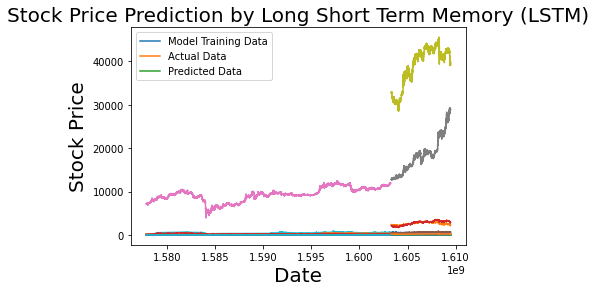

In [14]:
# train_window = [totimestamp("01/01/2020"), totimestamp("25/01/2020")]
# valid_window = [totimestamp("26/01/2020"), totimestamp("01/02/2020")]

train_window = [totimestamp("01/01/2020"), totimestamp("21/10/2020")]
valid_window = [totimestamp("22/10/2020"), totimestamp("01/01/2021")]

lstm_models = []

for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
    print(f'Train_model_for_{asset_name}')
    lstm_models.append(lstm_prediction(train_df, asset_id, train_window, valid_window))

In [1]:
clean_output()
for i, name in enumerate(asset_details.Asset_Name):
    save_model(lstm_models[i], name)
save_zip_file()

NameError: name 'clean_output' is not defined

## Tests <a class="anchor" id="7"></a>

[Back to Table of Contents](#0.1)

Еще один вариант предсказания

In [ ]:
api = API(train_df, use_window=LB_WINDOW)

start_time = time.time()

for i, (df_test, df_pred) in enumerate(tqdm(api)):
    df_test_merged = merge_infer_2(df_test, one_line)    
    history_merged = pd.concat([history_merged, df_test_merged])    
    x_test = get_features(history_merged, False)
    x_calc = x_test.iloc[-1]
    
    for j , (asset_id,row_id) in enumerate(zip(df_test['Asset_ID'].values,  df_test['row_id'].values)): 
        y_pred = 0       
        y_pred_list = []
        for split in range(n_fold):
            y_pred_list.append(models[asset_id][split].predict(x_calc[features]))
        y_pred = np.median(y_pred_list)     
        df_pred.loc[df_pred['row_id'] == row_id,'Target'] = y_pred

    history_merged = history_merged.tail(keep_hist)
    
    # Send submissions
    api.predict(df_pred)    
stop = time.time()
print(stop-start)

finish_time = time.time()

total_time = finish_time - start_time
iter_speed = api.init_num_times/total_time

print(f"    num_fold = {n_fold}")
print(f"Iterations/s = {round(iter_speed, 3)}")
print(f"s/Iterations = {round(1/iter_speed, 3)}")
test_iters = 60 * 24 * 100
print(f"Expected number of iterations in test set is approx. {test_iters}",
      f"which will take {round(test_iters / (iter_speed * 3600), 2)} hours",
      "using this API emulator while making dummy predictions.")

df, score = api.score()
print(f"Your LB score is {round(score, 5)}")

In [ ]:
# Prediction and submission
# not lgbm test
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

for i, (df_test, df_pred) in enumerate(iter_test):
    for j, row in df_test.iterrows():
        
        try:
            model = models[row['Asset_ID']]
            x_test = get_features(row)
            y_pred = model.predict([x_test])[0]

            df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
        
        except:
            print(f'{i}-th iteration of the test dataset, {j}-th row - there was the exception, then set Target = 0')
            df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = 0
            
        # Print just one sample row to get a feeling of what it looks like        
        if i == 0 and j == 0:
            print('Example of the x_test data')
            display(x_test)

    # Display the first prediction dataframe
    if i == 0:
        print('Example of the prediction for test data')
        display(df_pred)
    df_pred['Target'] = df_pred['Target'].fillna(0)

    # Send submissions
    env.predict(df_pred)

In [ ]:
import gresearch_crypto
env = gresearch_crypto.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
for (test_df, sample_prediction_df) in iter_test:
    # feature engineering
    test_df = get_row_feats(test_df)
    
    # inference
    sample_prediction_df['Target'] = model.predict(test_df[features])  # make your predictions here
    
    # register your predictions
    env.predict(sample_prediction_df)  

In [ ]:
api = API(train_df, use_window=LB_WINDOW)
# Пока тут только линейная модель
models = separete_lin_model
prediction = []

start_time = time.time()

for (df_test, df_pred) in tqdm(api):
    test_df = get_features(df_test)
    test_df.drop(['Asset name', 'timestamp'], axis=1, inplace=True)
    
    tmp = []
    for i in range(len(models)):
        tmp.append(models[i].predict(test_df))  # make your predictions here
    df_pred['Target'] = np.mean(tmp)
    # register your predictions
    api.predict(df_pred) 
    
stop = time.time()
print(stop - start)

finish_time = time.time()

total_time = finish_time - start_time
iter_speed = api.init_num_times/total_time

print(f"Iterations/s = {round(iter_speed, 3)}")
print(f"s/Iterations = {round(1/iter_speed, 3)}")
test_iters = 60 * 24 * 100
print(f"Expected number of iterations in test set is approx. {test_iters}",
      f"which will take {round(test_iters / (iter_speed * 3600), 2)} hours",
      "using this API emulator while making dummy predictions.")

df, score = api.score()
print(f"Your LB score is {round(score, 5)}")

[Go to Top](#0)